## Model and feature selection

### Imports for modelling

In [289]:
# !pip install imblearn
# !pip uninstall scikit-learn
# !pip install scikit-learn==1.2.2
from imblearn.over_sampling import SMOTENC
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
from tqdm import tqdm
import random
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

# !pip install category_encoders
import category_encoders as ce
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
sns.set_palette("tab20")

random_state = 42
np.random.seed(42)

### Set train and test data

In [59]:
df_train = pd.read_csv('Data/df_train_preprocessed.csv')
df_test = pd.read_csv('Data/df_test_preprocessed.csv')

### Important functions

In [41]:
def target_encoder(fit_data, transform_data, target, features_for_encoding, smoothing=100):
    target_encoder = ce.TargetEncoder(cols=features_for_encoding, smoothing=smoothing)  
    target_encoder.fit(fit_data[features_for_encoding], fit_data[target].astype(int))
    encoded_df = target_encoder.transform(transform_data[features_for_encoding])
    features_for_encoding_pass = [i + '_target' for i in features_for_encoding]
    transform_data[features_for_encoding_pass] = np.array(encoded_df)
    encoded_df = transform_data.drop(columns = features_for_encoding)
    # encoded_df =  pd.concat((transform_data[transform_data.columns.difference(features_for_encoding)],
    #                     pd.DataFrame(np.array(encoded_df), columns = features_for_encoding_pass)), axis=1)
    return encoded_df, features_for_encoding_pass

In [42]:
def scaler(fit_data, transform_data, features_for_scaling, scaling_type = 'minmax'):
    if scaling_type == 'minmax':
        sc = MinMaxScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1) 
        return scaled_df
    if scaling_type == 'standard':
        sc = StandardScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1)
        return scaled_df

In [43]:
def patient_features(df_train, df_test, multiclass = False):
    df_all = pd.concat([df_train, df_test])

    list_for_scaling = []
    
    # total visits of one patient in dataset, excluding current visit
    patient_total_visits = df_train[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_train = pd.merge(df_train, patient_total_visits, how = 'left', on = 'patient_id')
    df_train['patient_total_visits'].fillna(0, inplace = True)

    patient_total_visits = df_all[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_test = pd.merge(df_test, patient_total_visits, how = 'left', on = 'patient_id')
    df_test['patient_total_visits'].fillna(0, inplace = True)

    list_for_scaling.append('patient_total_visits')

    if multiclass == False:
        # check if we know that this person was readmitted on any other visit we know and calculate number of readmissions
        was_readmitted_encounter = df_train[['patient_id', 
                                   'encounter_id',
                                   'readmitted_binary']].groupby(['patient_id','encounter_id']).max(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_encounter'}).reset_index()
        was_readmitted_patient = df_train[['patient_id', 
                                       'readmitted_binary']].groupby(['patient_id']).sum(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_patient'}).reset_index()
        was_readmitted = pd.merge(was_readmitted_encounter, was_readmitted_patient, on = 'patient_id')
        was_readmitted['patient_num_readmitted'] = (was_readmitted['was_readmitted_patient'] - was_readmitted['was_readmitted_encounter']).astype('int')
        was_readmitted['patient_was_readmitted'] = was_readmitted['patient_num_readmitted'].apply(lambda x: 1 if x > 0 else 0).astype('category')
        df_train = pd.merge(df_train, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id')
        df_train[['patient_num_readmitted', 'patient_was_readmitted']] = df_train[['patient_num_readmitted', 'patient_was_readmitted']].fillna(0)
    
        df_test = pd.merge(df_test, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id')
        df_test[['patient_num_readmitted', 'patient_was_readmitted']] = df_test[['patient_num_readmitted', 'patient_was_readmitted']].fillna(0).astype(int)
        list_for_scaling.append('patient_num_readmitted')

    return df_train, df_test, list_for_scaling

In [44]:
def upsampler(data, 
              target,  
              upsample_type = 'simple', 
              upsample_size = 1):
    majority_class_label = data[target].value_counts().idxmax()
    minority_class_labels = data[target].value_counts().index.drop(majority_class_label)
    balanced_data = pd.DataFrame()
    if upsample_type == 'simple':
        for label in minority_class_labels:
            if len(data[data[target] == majority_class_label])*upsample_size > len(data[data[target] == label]):
                minority_upsampled = resample(data[data[target] == label], replace=True, n_samples=int(len(data[data[target] == majority_class_label])*upsample_size), 
                                                  random_state = random_state)
                balanced_data = pd.concat([balanced_data, minority_upsampled])
            else:
                balanced_data = pd.concat([balanced_data, data[data[target] == label]])
        balanced_data = pd.concat([balanced_data, data[data[target] == majority_class_label]])
    if upsample_type == 'SMOTE':
        X = data.drop(columns = target)
        categorical_features = X.select_dtypes(include='category').columns
        cat_ind = [X.columns.get_loc(col) for col in categorical_features]
        smote_nc = SMOTENC(categorical_features=cat_ind, random_state=random_state)
        X_resampled, y_resampled = smote_nc.fit_resample(X, data[target])  
        balanced_data = pd.concat([X_resampled, y_resampled], axis = 1)
    return balanced_data

In [45]:
def cross_validation(data, 
                     target, 
                     model, 
                     params, 
                     multiclass = False,
                     
                     scaling = False,
                     features_for_scaling_minmax = [],
                     features_for_scaling_standard = [],

                     target_encoding = False,
                     features_for_encoding = [],
                     smoothing = 100,
                     
                     upsample = False, 
                     upsample_size = 1,
                     upsample_type = 'simple', 
                     cv=5
                     ):
    # Defining some lists to collect data
    feature_imp = []
    f1 = []
    confusion_matrix_list = []
    precision_score_list = []
    recall_score_list = []
    roc_auc_score_list = []

    # A bit of resampling just to mix data
    data = data.sample(frac=1, random_state=random_state)
    data[target] = data[target].astype(int)

    # create stratified folds
    skf = StratifiedKFold(n_splits=cv, shuffle = True, random_state = random_state)
    split = list(skf.split(data.drop(columns = target), data[target]))
    all_train_index = [i[0] for i in split]
    all_val_index = [i[1] for i in split]
    
    for i in range(cv):
        val_index = all_val_index[i]
        train_index = all_train_index[i]
        train_data, val_data = data.loc[train_index], data.loc[val_index]

        #Target encoding
        if target_encoding == True:
                val_data = target_encoder(train_data, val_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)[0]
                train_data, features_for_encoding_pass = target_encoder(train_data, train_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)
                features_for_scaling_minmax_full = features_for_scaling_minmax + list(features_for_encoding_pass)
        else:
            features_for_scaling_minmax_full = features_for_scaling_minmax

        #creating features on patient level that we will use
        train_data, val_data, pat_features_scale = patient_features(train_data, val_data, multiclass = multiclass)
        features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale
 
        # Scaling features
        if scaling == True:
            if len(features_for_scaling_minmax) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            if len(features_for_scaling_standard) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_standard, scaling_type = 'standard')
                train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')
                
        # Upsampling only train data 
        if upsample == True:
            train_data = upsampler(train_data, target, upsample_type = upsample_type,  upsample_size = upsample_size)

        # Defining train and val datasets
        X_train = train_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_train = train_data[target]
        
        X_val = val_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_val = val_data[target]


        # Fit and predict
        model.set_params(**params)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        #Feature importances if our model can do this
        try:
            try:
                feature_imp.append(model.feature_importances_)
            except:
                pass
            try:
                feature_imp.append(model.coef_)
            except:
                pass
        except:
            pass

        # Calculating f1 scores and other metrics
        if multiclass == False:
            f1.append([f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
            recall_score_list.append([recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)])
            precision_score_list.append([precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)])
            roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)])
        if multiclass == True:
            f1.append([f1_score( y_train, y_pred_train, average = 'micro'), f1_score(y_val, y_pred_val, average = 'micro')])
            recall_score_list.append([recall_score( y_train, y_pred_train, average = 'micro'), recall_score(y_val, y_pred_val, average = 'micro')])
            precision_score_list.append([precision_score(y_train, y_pred_train, average = 'micro'), precision_score(y_val, y_pred_val, average = 'micro')])
            # roc_auc_score_list.append([roc_auc_score( y_train, y_pred_train.reshape(-1, 1), multi_class='ovr', average = 'micro'), roc_auc_score(y_val, y_pred_val.reshape(-1, 1), multi_class='ovr', average = 'micro')])

        
        confusion_matrix_list.append([confusion_matrix(y_train, y_pred_train), confusion_matrix(y_val, y_pred_val)])

    # Printing results
    print(model)
    print('F1 train: {:.3f}, F1_val: {:.3f}'.format(np.array(f1).mean(axis = 0)[0],
                                                   np.array(f1).mean(axis = 0)[1]))
    return [model.get_params(), 
            {'f1' : np.array(f1).mean(axis = 0), 
             'recall_score' : np.array(recall_score_list).mean(axis = 0),
             'precision_score' : np.array(precision_score_list).mean(axis = 0),
             'roc_auc_score' : np.array(roc_auc_score_list).mean(axis = 0)
            }, 
            {'f1' : f1, 
             'recall_score' : recall_score_list,
             'precision_score' : precision_score_list,
             'roc_auc_score' : roc_auc_score_list,
             'confusion_matrix': confusion_matrix_list
            },
            X_train.columns, 
            np.median(np.array(feature_imp), axis = 0),
            ]

In [46]:
def submit( X_train, 
            y_train, 
            X_test, 
            model,  
            scaling = False,
            features_for_scaling_minmax = [],
            features_for_scaling_standard = [],

            muliclass = False,
           
            target_encoding = False,
            features_for_encoding = [],
            smoothing = 100,
           
            upsample = False, 
            upsample_size = 1,
            upsample_type = 'simple'):
    
        train_data, test_data = pd.concat([X_train, y_train.astype(int)], axis = 1), X_test

        #Target encoding
        if target_encoding == True:
                test_data, _ = target_encoder(train_data, test_data, features_for_encoding = features_for_encoding, target = y_train.name, smoothing = smoothing)
                train_data, features_for_encoding_pass = target_encoder(train_data, train_data, features_for_encoding = features_for_encoding, target = y_train.name, smoothing = smoothing)
                features_for_scaling_minmax_full = features_for_scaling_minmax + list(features_for_encoding_pass)
        else:
            features_for_scaling_minmax_full = features_for_scaling_minmax
        # patient features
        train_data, test_data, pat_features_scale = patient_features(train_data, test_data, multiclass = multiclass)
        features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale

        # Scaling features
        if scaling == True:
            if len(features_for_scaling_minmax_full) > 0:
                test_data = scaler(train_data, test_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            if len(features_for_scaling_standard) > 0:
                test_data = scaler(train_data, test_data, features_for_scaling_standard, scaling_type = 'standard')
                train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')
    
        # Upsampling only train data 
        if upsample == True:
            train_data = upsampler(train_data, y_train.name, upsample_type = upsample_type,  upsample_size = upsample_size)
    
        # Defining train and test datasets
        y_train = train_data[y_train.name]
        X_train = train_data.drop(columns=y_train.name).drop(columns = ['encounter_id', 'patient_id'])
        
        X_test = test_data.drop(columns = ['encounter_id', 'patient_id'])
            
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)
    
        return (y_pred_test, y_pred_train, X_train)

In [ ]:
def plot_metrics(result, params, best_models, figsize_param = (30,40)):

    fig,ax = plt.subplots(ncols = len(result[0][1]), nrows = len(params), figsize = figsize_param)
    
    for m in range(len(result[0][1])):
        for key in range(len(list(params.keys()))):
            hyperparam = list(params.keys())[key]
            metric = list(result[0][1].keys())[m]
            hyperparam_df = pd.DataFrame([(best_models[i][0][hyperparam], best_models[i][1][metric][1]) for i in range(len(best_models))], 
                                         columns = ['hyperparameter', metric]).fillna('None')
            if hyperparam_df['hyperparameter'].dtype == 'O':
                hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
            hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
            
            ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
            labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
            patch_artist=True,
            widths=0.4,         
            medianprops=dict(color='darkblue'),
            boxprops=dict(facecolor='lightblue', edgecolor='black'),
             whiskerprops=dict(color='black'), 
             capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
                              ) 
            ax[key, m].tick_params(axis='x', labelsize=10)
            ax[key, m].set_title(hyperparam + ' - ' + metric)
    
            ax[key, m].xaxis.grid(False)
            ax[key, m].yaxis.grid(False)
    plt.tight_layout()
    
    # plt.savefig('rf_feature_selection_hyperparams.png')
    plt.show()

### Initialization of columns set

In [47]:
categorical_columns = ['race',
       'payer_code',  'admission_type',
       'medical_specialty',  'discharge_disposition',
       'admission_source', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       # 'readmitted_binary', 'readmitted_multiclass',
       'has_weight', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_nan', 'payer_code_HM', 'payer_code_MC',
       'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
       'payer_code_SP', 
       'more_than_one_lab_test', 'high_admission_source',
       'medium_admission_source', 'low_admission_source',
       'admission_type_big_share', 'admission_type_big_share_Elective',
       'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',
       'no_medical_specialty', 'high_medical_specialty',
       'medium_medical_specialty', 'low_medical_specialty',
       'discharged_home_hospice', 'expired', 'very_high_discharge_disposition', 'high_discharge_disposition',
       'medium_discharge_disposition', 'primary_diagnosis_category',
       'secondary_diagnosis_category', 'additional_diagnosis_category',
       'high_primary_diagnosis_category', 'medium_primary_diagnosis_category',
       'low_primary_diagnosis_category', 'high_secondary_diagnosis_category',
       'medium_secondary_diagnosis_category',
       'low_secondary_diagnosis_category',
       'high_additional_diagnosis_category',
       'medium_additional_diagnosis_category',
       'low_additional_diagnosis_category', 'diabetes_diagnosis',
       'diabetes_diagnosis_4_digits', 'diabetes_type',
       'diabetes_severity_group', 'diabetes_severity_group_Mild',
       'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
       'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
       'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
       'glucose_test_performed', 'a1c_test_performed', 
       'metformin', 'rosiglitazone', 'glyburide', 'insulin', 'glipizide',
       'repaglinide', 'glimepiride', 'pioglitazone',
        'high_primary_diagnosis',
       'medium_primary_diagnosis', 'low_primary_diagnosis',
       'high_secondary_diagnosis', 'medium_secondary_diagnosis',
       'low_secondary_diagnosis', 'high_additional_diagnosis',
       'medium_additional_diagnosis', 'low_additional_diagnosis']

df_train[categorical_columns] = df_train[categorical_columns].astype('category')
df_test[[i for i in categorical_columns if i not in ['readmitted_binary', 'readmitted_multiclass']]] = df_test[[i for i in categorical_columns if i not in ['readmitted_binary', 'readmitted_multiclass']]].astype('category')

In [62]:
#we dont use medium in any categorical since it has nothing to say about target
columns_to_use = ['encounter_id', 'patient_id', 
                  
                  'gender', 'age', 
                  'has_weight',
                  
                  
                  'outpatient_visits_in_previous_year',
                  'emergency_visits_in_previous_year',
                  'inpatient_visits_in_previous_year', 
                  'total_visits', 
                  'max_visits_of_one_type',
                  
                  'average_pulse_bpm', 
                  'length_of_stay_in_hospital', 
                  
                  'number_lab_tests', 'more_than_one_lab_test',
                  'non_lab_procedures', 
                  'number_of_medications', 
                  'number_diagnoses',
                  
                  'glucose_test_result', 'glucose_test_performed', 
                  'a1c_test_result','a1c_test_performed',
                  
                  'change_in_meds_during_hospitalization', 
                  'prescribed_diabetes_meds', 
                  
                  'race_Asian', 'race_Caucasian', 'race_Hispanic',
                  'race_Other', 'race_nan', 
                  
                  'payer_code_HM', 'payer_code_MC',
                  'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
                  'payer_code_SP', 
                  
                  'high_admission_source', 
                  'low_admission_source',
                  
                  'admission_type_big_share_Elective', 'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',
                  
                  'no_medical_specialty', 
                  
                  'high_medical_specialty',
                  'low_medical_specialty',
                  
                  'discharged_home_hospice', 'expired', 'very_high_discharge_disposition', 'high_discharge_disposition',


       'high_primary_diagnosis_category', 
                  
       'low_primary_diagnosis_category', 'high_secondary_diagnosis_category',

       'low_secondary_diagnosis_category',
       'high_additional_diagnosis_category',

       'low_additional_diagnosis_category',
                   
                  'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
                  'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
                  'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
                  'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
                  'rosiglitazone', 'glipizide', 
                  
                  'insulin',

                  'high_primary_diagnosis',
                   'low_primary_diagnosis',
       'high_secondary_diagnosis', 
       'low_secondary_diagnosis', 'high_additional_diagnosis',
 'low_additional_diagnosis',
                 ]

In [63]:
target = 'readmitted_binary'
# target = 'readmitted_multiclass'

features_for_encoding = [
    # 'admission_type',
    #    'medical_specialty', 'discharge_disposition',
    #    'admission_source', 
    'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis',
       #  'primary_diagnosis_category', 'secondary_diagnosis_category', 'additional_diagnosis_category'
                        ]

features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 
                               'glucose_test_result',
       'a1c_test_result'
                              ]
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

columns_to_use_full = columns_to_use #+ features_for_encoding

X_train = df_train[columns_to_use_full]
y_train = df_train[target]
X_test = df_test[columns_to_use_full]

data = pd.concat([X_train, y_train], axis = 1)



### Features selection

#### Random Forest MDI

In [67]:

model = RandomForestClassifier(random_state = random_state)
params = {
    'n_estimators': np.arange(50, 300, 20),
    'max_depth': np.arange(6, 30, 2),
    'min_samples_split': np.arange(0, 0.001, 0.0001) + 0.000001,
    'min_samples_leaf': np.arange(0, 0.002, 0.0002) + 0.000001,
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': np.arange(0.1,0.7,0.1),
}

result = []
for i in tqdm(range(100)):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params,
                     multiclass = False,
                                   # target_encoding= True,
                                   # features_for_encoding = features_for_encoding,
                                   
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,    
                     upsample = False,   
                     cv=5))

  1%|▍                                        | 1/100 [01:16<2:06:58, 76.96s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.001801, min_samples_split=0.000201,
                       n_estimators=150, random_state=42)
F1 train: 0.357, F1_val: 0.339


  2%|▊                                        | 2/100 [01:29<1:03:32, 38.90s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, max_features=0.1, min_samples_leaf=1e-06,
                       min_samples_split=0.000701, n_estimators=110,
                       random_state=42)
F1 train: 0.348, F1_val: 0.332


  3%|█▎                                         | 3/100 [01:44<45:33, 28.18s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.2,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=50, random_state=42)
F1 train: 0.581, F1_val: 0.340


  4%|█▋                                       | 4/100 [04:06<1:56:53, 73.06s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=18, max_features=0.6000000000000001,
                       min_samples_leaf=0.001201, min_samples_split=1e-06,
                       n_estimators=250, random_state=42)
F1 train: 0.372, F1_val: 0.342


  5%|██                                       | 5/100 [05:45<2:10:17, 82.28s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.5,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=210,
                       random_state=42)
F1 train: 0.417, F1_val: 0.348


  6%|██▍                                      | 6/100 [06:04<1:35:14, 60.79s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000201, n_estimators=90,
                       random_state=42)
F1 train: 0.333, F1_val: 0.329


  7%|██▊                                      | 7/100 [06:28<1:15:38, 48.81s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, max_features=0.6000000000000001,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=70,
                       random_state=42)
F1 train: 0.332, F1_val: 0.326


  8%|███▎                                     | 8/100 [07:41<1:26:57, 56.71s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, max_features=0.5,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=190, random_state=42)
F1 train: 0.355, F1_val: 0.337


  9%|███▋                                     | 9/100 [07:57<1:06:17, 43.71s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.1,
                       min_samples_leaf=0.001601, min_samples_split=0.000201,
                       n_estimators=110, random_state=42)
F1 train: 0.348, F1_val: 0.332


 10%|████▏                                     | 10/100 [08:06<49:33, 33.04s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.1,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=50,
                       random_state=42)
F1 train: 0.425, F1_val: 0.340


 11%|████▌                                     | 11/100 [08:38<48:29, 32.69s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.1,
                       min_samples_leaf=0.001401, min_samples_split=1e-06,
                       n_estimators=250, random_state=42)
F1 train: 0.350, F1_val: 0.334


 12%|█████                                     | 12/100 [09:02<44:15, 30.18s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=6, max_features=0.6000000000000001,
                       min_samples_leaf=0.001201, min_samples_split=0.000201,
                       n_estimators=70, random_state=42)
F1 train: 0.333, F1_val: 0.328


 13%|█████▏                                  | 13/100 [10:41<1:14:04, 51.09s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=22, max_features=0.30000000000000004,
                       min_samples_leaf=0.001001, min_samples_split=0.000201,
                       n_estimators=290, random_state=42)
F1 train: 0.375, F1_val: 0.342


 14%|█████▉                                    | 14/100 [11:00<59:07, 41.25s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=8, max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.000201, n_estimators=110,
                       random_state=42)
F1 train: 0.349, F1_val: 0.334


 15%|██████                                  | 15/100 [12:35<1:21:38, 57.63s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=28, max_features=0.5,
                       min_samples_leaf=0.001401, min_samples_split=0.000501,
                       n_estimators=210, random_state=42)
F1 train: 0.365, F1_val: 0.341


 16%|██████▍                                 | 16/100 [12:44<1:00:01, 42.88s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.1, min_samples_leaf=0.001401,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=50, random_state=42)
F1 train: 0.349, F1_val: 0.332


 17%|██████▊                                 | 17/100 [13:50<1:08:53, 49.80s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=14, max_features=0.4,
                       min_samples_leaf=0.000201, min_samples_split=0.000201,
                       n_estimators=150, random_state=42)
F1 train: 0.506, F1_val: 0.346


 18%|███████▏                                | 18/100 [16:19<1:48:56, 79.71s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.5, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=290, random_state=42)
F1 train: 0.410, F1_val: 0.349


 19%|███████▌                                | 19/100 [17:12<1:36:41, 71.62s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=6, max_features=0.6000000000000001,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000201, n_estimators=170,
                       random_state=42)
F1 train: 0.333, F1_val: 0.327


 20%|████████                                | 20/100 [18:30<1:37:59, 73.49s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=110, random_state=42)
F1 train: 0.629, F1_val: 0.338


 21%|████████▍                               | 21/100 [20:00<1:43:20, 78.49s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=6, max_features=0.6000000000000001,
                       min_samples_leaf=0.001801, min_samples_split=1e-06,
                       n_estimators=270, random_state=42)
F1 train: 0.333, F1_val: 0.328


 22%|████████▊                               | 22/100 [20:08<1:14:32, 57.34s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22, max_features=0.1,
                       min_samples_leaf=0.001001, min_samples_split=0.000701,
                       n_estimators=50, random_state=42)
F1 train: 0.364, F1_val: 0.333


 23%|█████████▏                              | 23/100 [21:46<1:29:22, 69.64s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=230,
                       random_state=42)
F1 train: 0.417, F1_val: 0.350


 24%|█████████▎                             | 24/100 [25:56<2:36:26, 123.51s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=26, max_features=0.6000000000000001,
                       min_samples_leaf=1e-06, min_samples_split=1e-06,
                       n_estimators=290, random_state=42)
F1 train: 1.000, F1_val: 0.019


 25%|█████████▊                             | 25/100 [27:00<2:12:19, 105.86s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=290,
                       random_state=42)
F1 train: 0.372, F1_val: 0.341


 26%|██████████▍                             | 26/100 [27:38<1:45:26, 85.50s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.6000000000000001,
                       min_samples_leaf=0.001601, min_samples_split=0.000501,
                       n_estimators=70, random_state=42)
F1 train: 0.361, F1_val: 0.339


 27%|██████████▊                             | 27/100 [28:46<1:37:33, 80.19s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.5, min_samples_leaf=0.001801,
                       min_samples_split=0.000701, n_estimators=150,
                       random_state=42)
F1 train: 0.356, F1_val: 0.337


 28%|███████████▏                            | 28/100 [29:18<1:18:58, 65.81s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=12, max_features=0.2,
                       min_samples_leaf=0.001001,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.364, F1_val: 0.339


 29%|███████████▌                            | 29/100 [29:54<1:07:22, 56.93s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.1, min_samples_leaf=1e-06,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=210, random_state=42)
F1 train: 0.445, F1_val: 0.342


 30%|████████████                            | 30/100 [31:23<1:17:20, 66.30s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=12, max_features=0.5,
                       min_samples_leaf=0.000201, min_samples_split=0.000701,
                       n_estimators=170, random_state=42)
F1 train: 0.426, F1_val: 0.345


 31%|████████████▍                           | 31/100 [31:58<1:05:38, 57.08s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=0.1,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.358, F1_val: 0.335


 32%|█████████████▍                            | 32/100 [32:18<51:53, 45.79s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.1,
                       min_samples_leaf=0.001001,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.364, F1_val: 0.335


 33%|█████████████▏                          | 33/100 [33:35<1:01:44, 55.29s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.4,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=190, random_state=42)
F1 train: 0.365, F1_val: 0.341


 34%|█████████████▌                          | 34/100 [35:37<1:22:43, 75.20s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.4, min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=270, random_state=42)
F1 train: 0.391, F1_val: 0.347


 35%|██████████████                          | 35/100 [37:47<1:39:15, 91.63s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=26, max_features=0.4, min_samples_leaf=1e-06,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.668, F1_val: 0.335


 36%|██████████████                         | 36/100 [39:47<1:46:54, 100.22s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.5, min_samples_leaf=1e-06,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.640, F1_val: 0.320


 37%|██████████████▍                        | 37/100 [41:34<1:47:27, 102.34s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.5,
                       min_samples_leaf=0.001601, min_samples_split=1e-06,
                       n_estimators=250, random_state=42)
F1 train: 0.358, F1_val: 0.339


 38%|███████████████▏                        | 38/100 [42:47<1:36:39, 93.54s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=190, random_state=42)
F1 train: 0.596, F1_val: 0.343


 39%|███████████████▌                        | 39/100 [43:28<1:18:53, 77.59s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=28, max_features=0.2,
                       min_samples_leaf=0.001801, min_samples_split=0.000501,
                       n_estimators=190, random_state=42)
F1 train: 0.349, F1_val: 0.336


 40%|████████████████                        | 40/100 [44:02<1:04:42, 64.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.6000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.0008010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.506, F1_val: 0.344


 41%|█████████████████▏                        | 41/100 [44:20<49:39, 50.50s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.30000000000000004,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.378, F1_val: 0.344


 42%|████████████████▊                       | 42/100 [45:52<1:01:04, 63.18s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=0.5,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=170, random_state=42)
F1 train: 0.467, F1_val: 0.353


 43%|██████████████████                        | 43/100 [46:53<59:19, 62.45s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.2, min_samples_leaf=1e-06,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=210, random_state=42)
F1 train: 0.570, F1_val: 0.344


 44%|██████████████████▍                       | 44/100 [47:27<50:08, 53.73s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.1,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=210,
                       random_state=42)
F1 train: 0.391, F1_val: 0.341


 45%|██████████████████▉                       | 45/100 [47:54<42:06, 45.94s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=16, max_features=0.4,
                       min_samples_leaf=0.001601, min_samples_split=1e-06,
                       n_estimators=70, random_state=42)
F1 train: 0.358, F1_val: 0.339


 46%|███████████████████▎                      | 46/100 [48:09<32:48, 36.46s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.1,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000201, n_estimators=90,
                       random_state=42)
F1 train: 0.374, F1_val: 0.338


 47%|███████████████████▋                      | 47/100 [50:17<56:31, 63.99s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.30000000000000004, min_samples_leaf=1e-06,
                       min_samples_split=0.000501, n_estimators=290,
                       random_state=42)
F1 train: 0.776, F1_val: 0.280


 48%|████████████████████▏                     | 48/100 [51:09<52:14, 60.29s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=0.2,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.353, F1_val: 0.336


 49%|████████████████████▌                     | 49/100 [51:25<40:05, 47.17s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.2,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=70, random_state=42)
F1 train: 0.354, F1_val: 0.337


 50%|█████████████████████                     | 50/100 [52:17<40:31, 48.63s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=190, random_state=42)
F1 train: 0.376, F1_val: 0.343


 51%|█████████████████████▍                    | 51/100 [52:34<32:01, 39.22s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.2,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=70,
                       random_state=42)
F1 train: 0.381, F1_val: 0.342


 52%|█████████████████████▊                    | 52/100 [53:03<28:52, 36.10s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=14, max_features=0.1,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=170, random_state=42)
F1 train: 0.352, F1_val: 0.332


 53%|██████████████████████▎                   | 53/100 [53:44<29:21, 37.49s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=110,
                       random_state=42)
F1 train: 0.437, F1_val: 0.349


 54%|██████████████████████▋                   | 54/100 [54:22<28:52, 37.67s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.1,
                       min_samples_leaf=0.001201, min_samples_split=0.000101,
                       n_estimators=270, random_state=42)
F1 train: 0.358, F1_val: 0.335


 55%|███████████████████████                   | 55/100 [55:23<33:34, 44.76s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.2,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=290, random_state=42)
F1 train: 0.357, F1_val: 0.338


 56%|███████████████████████▌                  | 56/100 [55:46<27:58, 38.15s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=0.1,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=190, random_state=42)
F1 train: 0.345, F1_val: 0.332


 57%|███████████████████████▉                  | 57/100 [56:20<26:20, 36.75s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=22, max_features=0.2,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=150, random_state=42)
F1 train: 0.361, F1_val: 0.339


 58%|████████████████████████▎                 | 58/100 [58:27<44:40, 63.81s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.6000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, n_estimators=190,
                       random_state=42)
F1 train: 0.494, F1_val: 0.351


 59%|██████████████████████▍               | 59/100 [1:01:09<1:03:47, 93.35s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18, max_features=0.5,
                       min_samples_leaf=1e-06, min_samples_split=1e-06,
                       n_estimators=250, random_state=42)
F1 train: 0.931, F1_val: 0.179


 60%|████████████████████████                | 60/100 [1:01:42<50:13, 75.35s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.1,
                       min_samples_leaf=0.000201, min_samples_split=0.000701,
                       n_estimators=190, random_state=42)
F1 train: 0.481, F1_val: 0.345


 61%|████████████████████████▍               | 61/100 [1:02:36<44:44, 68.83s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_features=0.30000000000000004,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000101, n_estimators=150,
                       random_state=42)
F1 train: 0.388, F1_val: 0.346


 62%|████████████████████████▊               | 62/100 [1:02:56<34:20, 54.22s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.30000000000000004, min_samples_leaf=1e-06,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=50, random_state=42)
F1 train: 0.696, F1_val: 0.295


 63%|█████████████████████████▏              | 63/100 [1:03:38<31:07, 50.47s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features=0.30000000000000004,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.356, F1_val: 0.337


 64%|█████████████████████████▌              | 64/100 [1:05:56<46:08, 76.92s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=16, max_features=0.6000000000000001,
                       min_samples_leaf=0.001001, min_samples_split=0.000501,
                       n_estimators=250, random_state=42)
F1 train: 0.382, F1_val: 0.344


 65%|██████████████████████████              | 65/100 [1:06:13<34:18, 58.83s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features=0.1,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.330, F1_val: 0.327


 66%|██████████████████████████▍             | 66/100 [1:07:52<40:13, 70.99s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.5,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000101, n_estimators=190,
                       random_state=42)
F1 train: 0.395, F1_val: 0.347


 67%|██████████████████████████▊             | 67/100 [1:08:24<32:31, 59.13s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.1,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=230, random_state=42)
F1 train: 0.349, F1_val: 0.332


 68%|███████████████████████████▏            | 68/100 [1:08:37<24:10, 45.31s/it]

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=0.1,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=150, random_state=42)
F1 train: 0.330, F1_val: 0.327


 69%|███████████████████████████▌            | 69/100 [1:09:57<28:47, 55.72s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.4, min_samples_leaf=0.001401,
                       min_samples_split=0.000701, n_estimators=230,
                       random_state=42)
F1 train: 0.356, F1_val: 0.338


 70%|████████████████████████████            | 70/100 [1:10:10<21:30, 43.02s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.1,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000101, n_estimators=70,
                       random_state=42)
F1 train: 0.407, F1_val: 0.341


 71%|████████████████████████████▍           | 71/100 [1:11:33<26:31, 54.89s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.4,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=170, random_state=42)
F1 train: 0.613, F1_val: 0.341


 72%|████████████████████████████▊           | 72/100 [1:12:03<22:13, 47.62s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=8, max_features=0.1, min_samples_leaf=0.001001,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=230, random_state=42)
F1 train: 0.340, F1_val: 0.330


 73%|█████████████████████████████▏          | 73/100 [1:13:56<30:13, 67.16s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=10, max_features=0.5, min_samples_leaf=1e-06,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=250, random_state=42)
F1 train: 0.392, F1_val: 0.342


 74%|█████████████████████████████▌          | 74/100 [1:14:53<27:44, 64.04s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.2, min_samples_leaf=0.001001,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=230, random_state=42)
F1 train: 0.369, F1_val: 0.341


 75%|██████████████████████████████          | 75/100 [1:16:21<29:38, 71.12s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=26, max_features=0.4,
                       min_samples_leaf=0.001001,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=210, random_state=42)
F1 train: 0.378, F1_val: 0.343


 76%|██████████████████████████████▍         | 76/100 [1:17:24<27:28, 68.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=24, max_features=0.30000000000000004,
                       min_samples_leaf=0.001201, min_samples_split=0.000201,
                       n_estimators=190, random_state=42)
F1 train: 0.366, F1_val: 0.341


 77%|██████████████████████████████▊         | 77/100 [1:18:07<23:25, 61.13s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.1, min_samples_leaf=0.001601,
                       min_samples_split=1e-06, n_estimators=270,
                       random_state=42)
F1 train: 0.349, F1_val: 0.332


 78%|███████████████████████████████▏        | 78/100 [1:19:59<28:02, 76.47s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26,
                       max_features=0.30000000000000004, min_samples_leaf=1e-06,
                       min_samples_split=0.000501, n_estimators=270,
                       random_state=42)
F1 train: 0.798, F1_val: 0.276


 79%|███████████████████████████████▌        | 79/100 [1:21:04<25:29, 72.83s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.5, min_samples_leaf=0.001201,
                       min_samples_split=0.000501, n_estimators=130,
                       random_state=42)
F1 train: 0.371, F1_val: 0.342


 80%|████████████████████████████████        | 80/100 [1:21:42<20:48, 62.42s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=14, max_features=0.2,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000701, n_estimators=150,
                       random_state=42)
F1 train: 0.378, F1_val: 0.343


 81%|████████████████████████████████▍       | 81/100 [1:22:38<19:09, 60.48s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=8, max_features=0.6000000000000001,
                       min_samples_leaf=0.001001, min_samples_split=0.000501,
                       n_estimators=130, random_state=42)
F1 train: 0.348, F1_val: 0.335


 82%|████████████████████████████████▊       | 82/100 [1:23:35<17:53, 59.65s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_features=0.4,
                       min_samples_leaf=0.001801, min_samples_split=1e-06,
                       n_estimators=150, random_state=42)
F1 train: 0.354, F1_val: 0.337


 83%|█████████████████████████████████▏      | 83/100 [1:25:05<19:26, 68.62s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=26, max_features=0.6000000000000001,
                       min_samples_leaf=0.001801, min_samples_split=0.000701,
                       n_estimators=170, random_state=42)
F1 train: 0.357, F1_val: 0.338


 84%|█████████████████████████████████▌      | 84/100 [1:25:33<15:04, 56.51s/it]

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=0.1,
                       min_samples_leaf=0.001001, min_samples_split=1e-06,
                       n_estimators=270, random_state=42)
F1 train: 0.340, F1_val: 0.331


 85%|██████████████████████████████████      | 85/100 [1:28:02<21:01, 84.13s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.4, min_samples_leaf=1e-06,
                       min_samples_split=0.000701, n_estimators=270,
                       random_state=42)
F1 train: 0.708, F1_val: 0.319


 86%|██████████████████████████████████▍     | 86/100 [1:28:11<14:23, 61.69s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=26, max_features=0.1,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0009010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.424, F1_val: 0.341


 87%|██████████████████████████████████▊     | 87/100 [1:30:04<16:43, 77.19s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.001401, min_samples_split=0.000201,
                       n_estimators=250, random_state=42)
F1 train: 0.359, F1_val: 0.339


 88%|███████████████████████████████████▏    | 88/100 [1:31:43<16:42, 83.54s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=8, max_features=0.5, min_samples_leaf=0.001601,
                       min_samples_split=0.000201, n_estimators=270,
                       random_state=42)
F1 train: 0.346, F1_val: 0.335


 89%|███████████████████████████████████▌    | 89/100 [1:32:20<12:46, 69.71s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.1, min_samples_leaf=0.001601,
                       min_samples_split=0.000501, n_estimators=230,
                       random_state=42)
F1 train: 0.349, F1_val: 0.332


 90%|████████████████████████████████████    | 90/100 [1:34:34<14:48, 88.80s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.6000000000000001,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.368, F1_val: 0.342


 91%|████████████████████████████████████▍   | 91/100 [1:35:59<13:10, 87.81s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.5,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=170,
                       random_state=42)
F1 train: 0.412, F1_val: 0.347


 92%|████████████████████████████████████▊   | 92/100 [1:37:16<11:16, 84.58s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=16, max_features=0.30000000000000004,
                       min_samples_leaf=0.001801, min_samples_split=0.000101,
                       n_estimators=250, random_state=42)
F1 train: 0.353, F1_val: 0.336


 93%|█████████████████████████████████████▏  | 93/100 [1:38:23<09:14, 79.15s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, max_features=0.4,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=1e-06, n_estimators=270,
                       random_state=42)
F1 train: 0.332, F1_val: 0.328


 94%|█████████████████████████████████████▌  | 94/100 [1:39:16<07:09, 71.53s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.4,
                       min_samples_leaf=0.001401, min_samples_split=0.000201,
                       n_estimators=150, random_state=42)
F1 train: 0.361, F1_val: 0.339


 95%|██████████████████████████████████████  | 95/100 [1:39:44<04:52, 58.48s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=22, max_features=0.1,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.349, F1_val: 0.331


 96%|██████████████████████████████████████▍ | 96/100 [1:40:18<03:23, 50.88s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.4, min_samples_leaf=0.001601,
                       min_samples_split=0.000501, n_estimators=130,
                       random_state=42)
F1 train: 0.333, F1_val: 0.328


 97%|██████████████████████████████████████▊ | 97/100 [1:40:38<02:05, 41.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=28, max_features=0.1,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000201, n_estimators=110,
                       random_state=42)
F1 train: 0.374, F1_val: 0.338


 98%|███████████████████████████████████████▏| 98/100 [1:41:06<01:15, 37.55s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.4, min_samples_leaf=0.000201,
                       min_samples_split=1e-06, n_estimators=110,
                       random_state=42)
F1 train: 0.334, F1_val: 0.328


 99%|███████████████████████████████████████▌| 99/100 [1:41:20<00:30, 30.48s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=8, max_features=0.1, min_samples_leaf=0.001001,
                       min_samples_split=0.000701, n_estimators=130,
                       random_state=42)
F1 train: 0.340, F1_val: 0.330


100%|███████████████████████████████████████| 100/100 [1:42:27<00:00, 61.47s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, max_features=0.5,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.357, F1_val: 0.338


In [68]:
import pickle


# Store the list using pickle
with open('Learning_results/rf_feature_selection.pkl', 'wb') as file:
    pickle.dump(result, file)

pick n best models of RF and build average rankings of features used there - then pick n best features

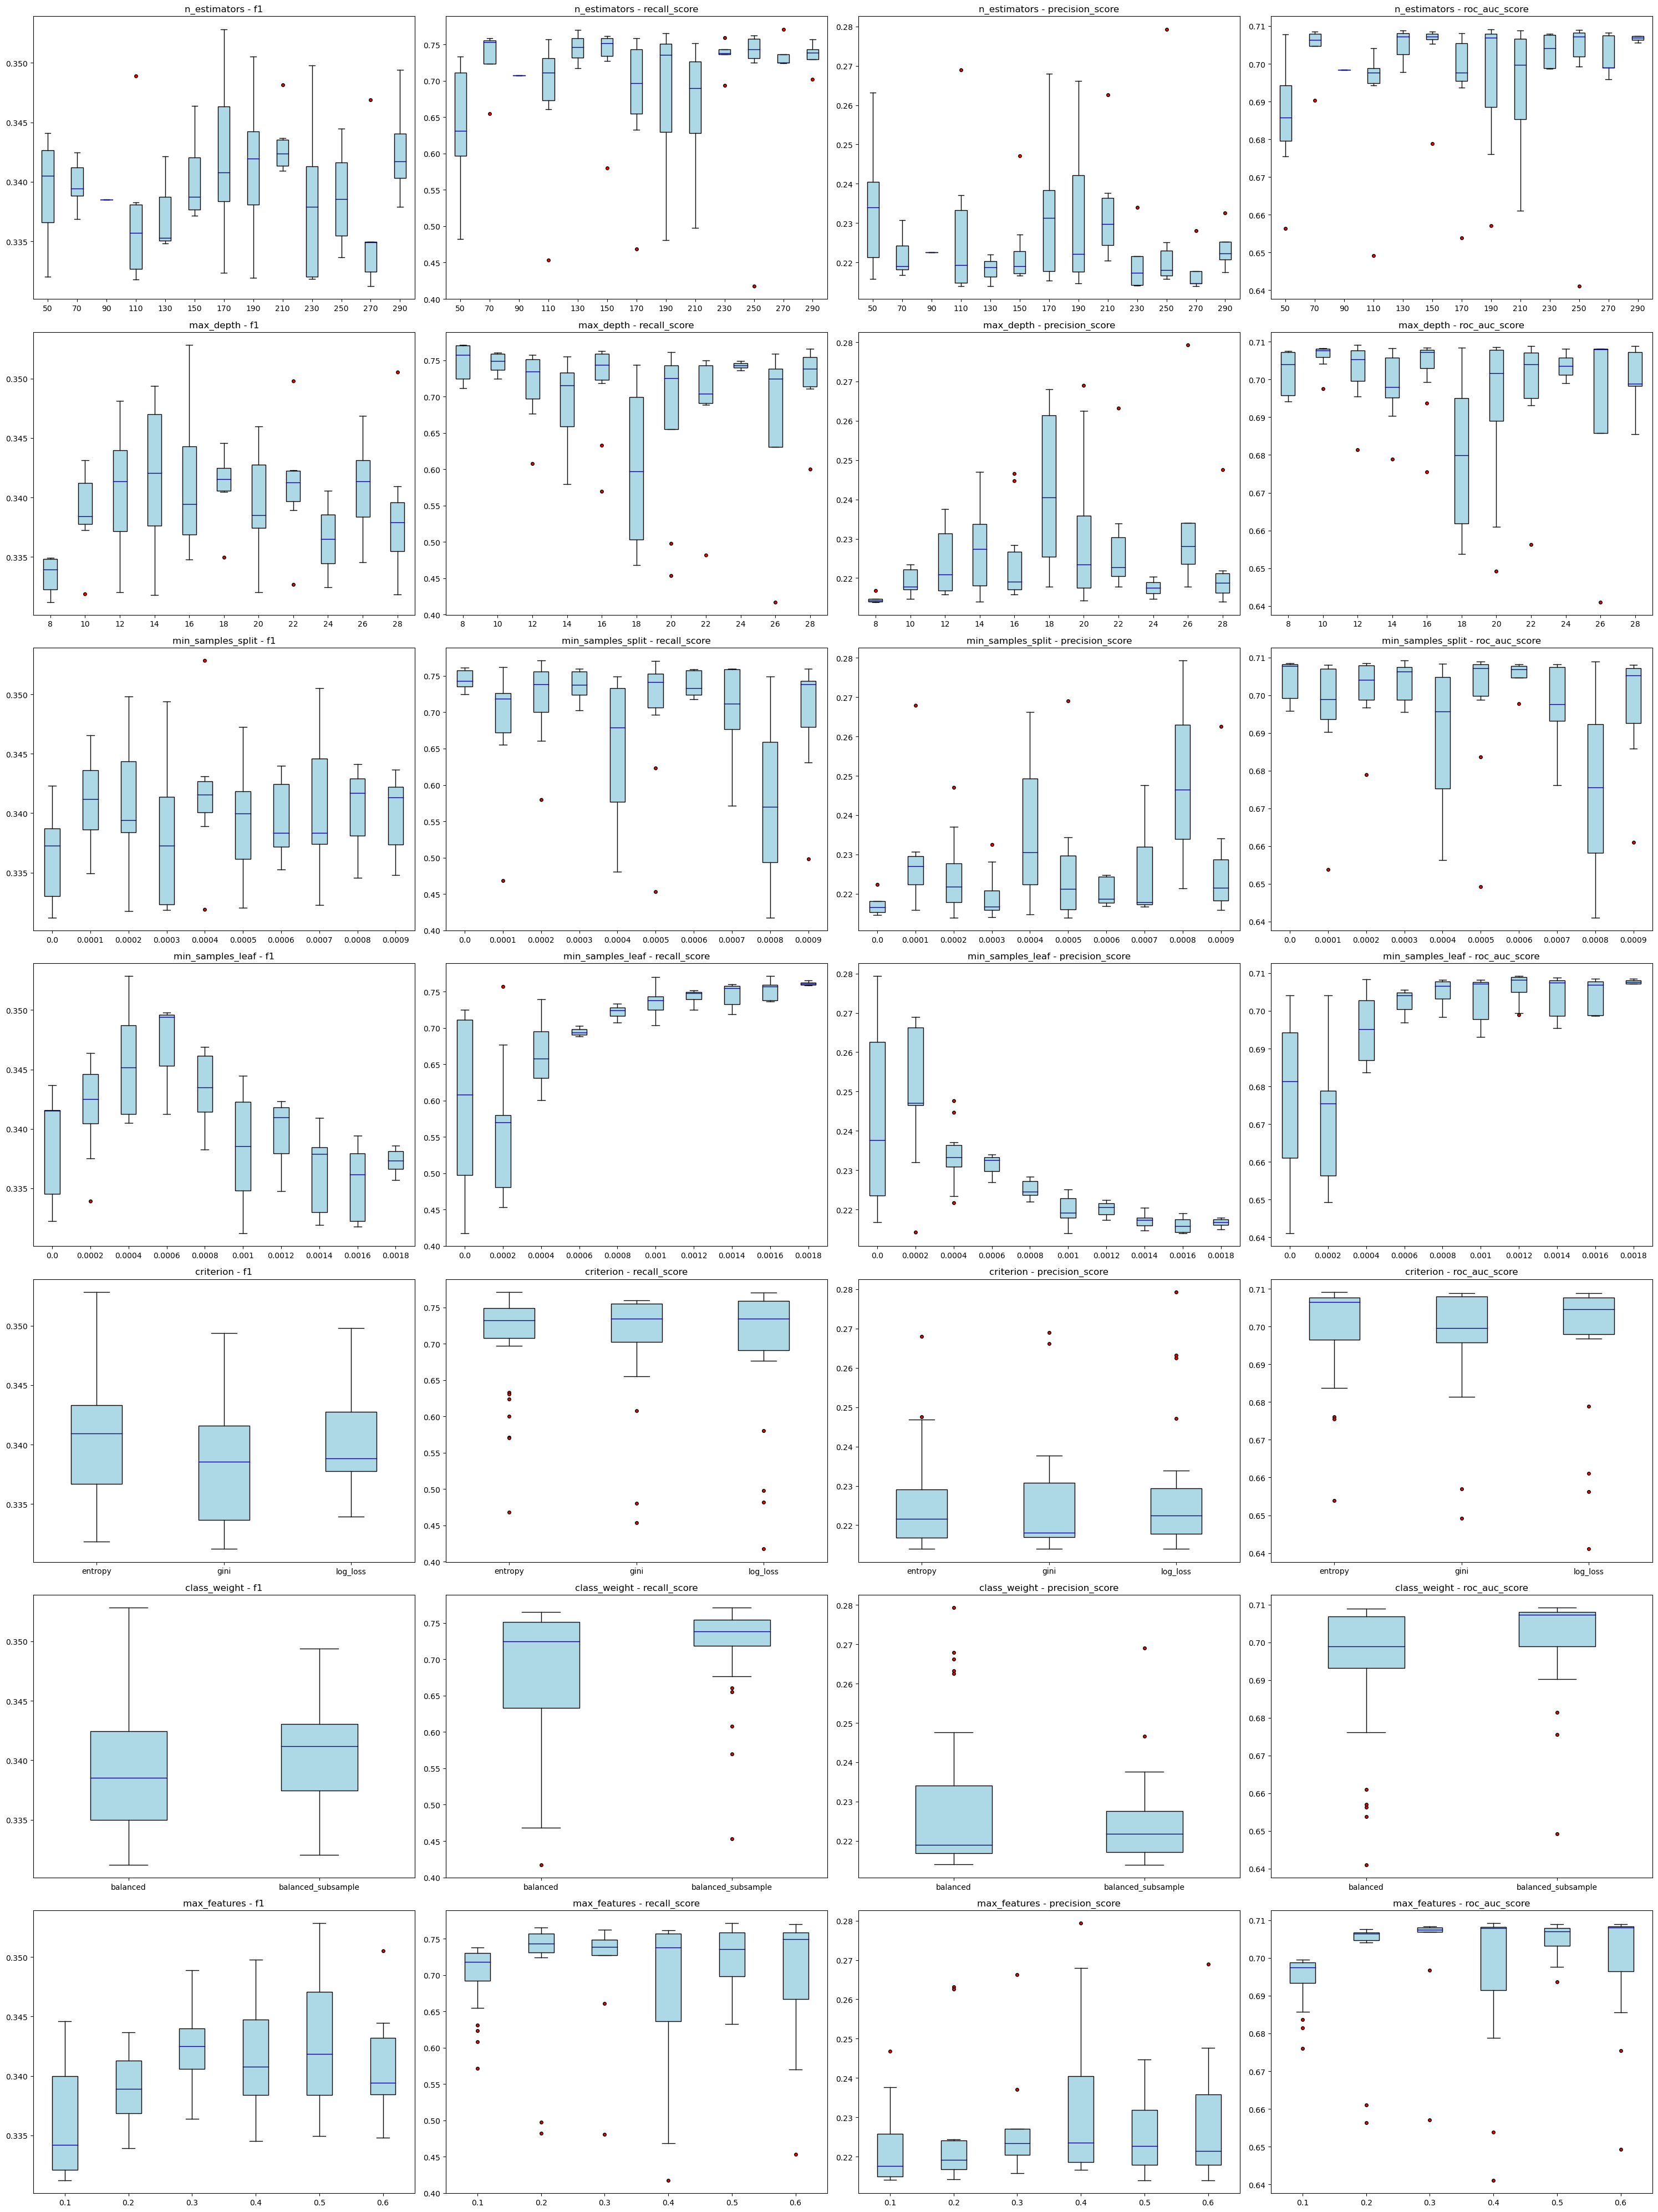

In [74]:
num_best_models = 80

best_models = sorted(result, key = lambda x: -x[1]['f1'][1])[:num_best_models]
fig,ax = plt.subplots(ncols = len(result[0][1]), nrows = len(params), figsize = (30,40))

plot_metrics(result, params, best_models, figsize_param = (30,40))

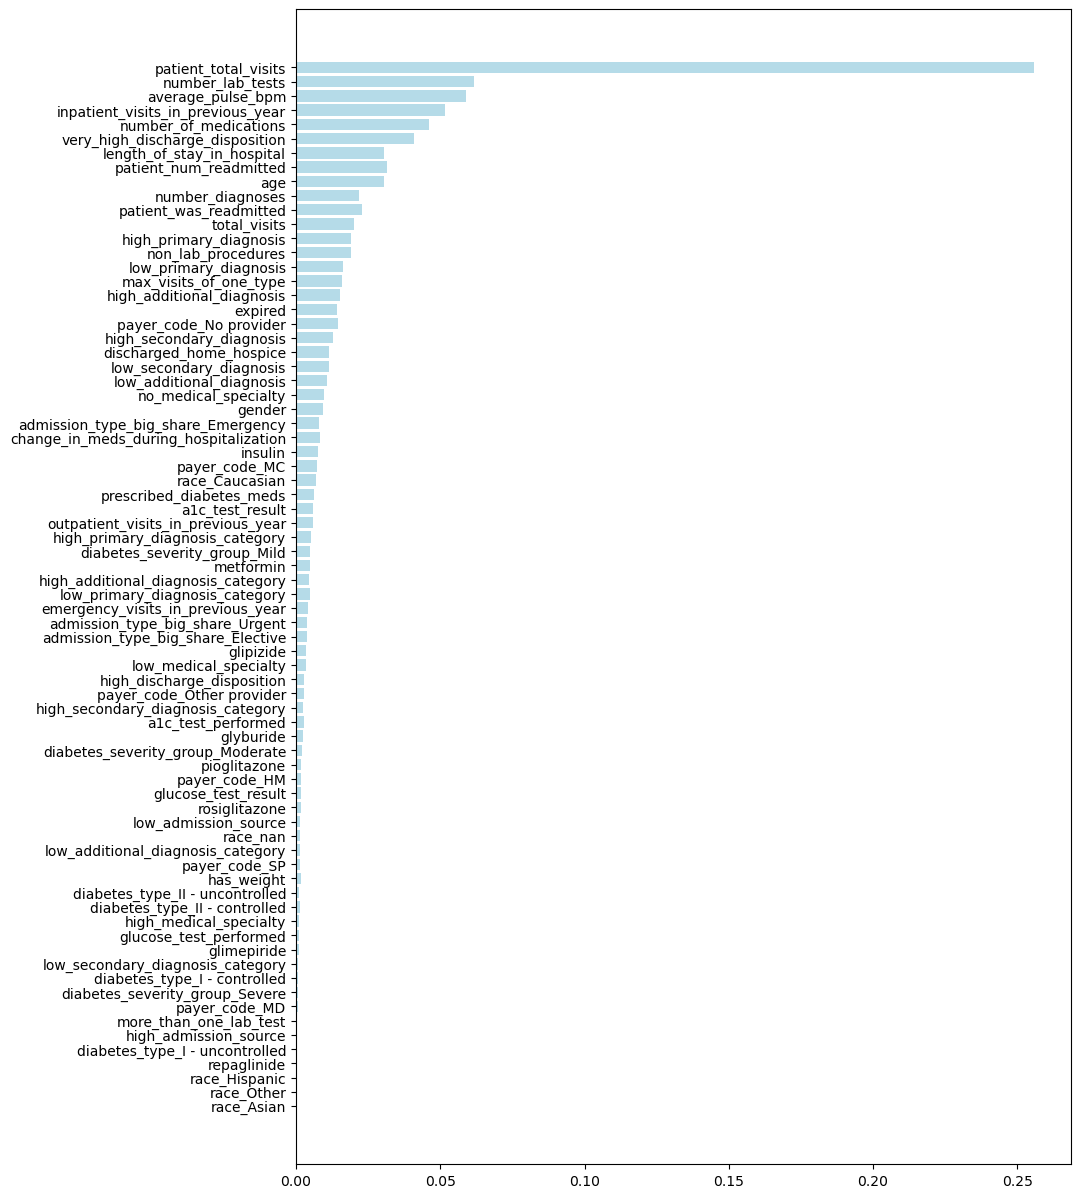

In [75]:
num_best_models = 10

best_models = sorted(result, key = lambda x: -x[1]['f1'][1])[:num_best_models]



fdf = pd.DataFrame(np.array([best_models[k][4] for k in range(len(best_models))]).T)
fdf['features'] = best_models[0][3]
fdf.set_index('features', inplace = True)
ranked_df = fdf.rank(ascending=False)
ranked_df['median_rank'] = ranked_df.median(axis=1)
ranked_df['median_feature_importance'] = fdf.median(axis=1)
ranked_df.reset_index(inplace = True)
ranked_df = ranked_df[['features', 'median_rank', 'median_feature_importance']]
features = ranked_df.sort_values(by = 'median_rank').head(30)['features']


plt.figure(figsize=(10, 15))
plt.barh(ranked_df.sort_values(by = 'median_rank', ascending = False)['features'], 
         ranked_df.sort_values(by = 'median_rank', ascending = False)['median_feature_importance'],
         color='lightblue',  alpha=0.9, linewidth=0, height=0.8, align='center')
         
# plt.tight_layout()
plt.show()

In [85]:
#since we see that all patient level features are important we will not change function of it anyhow
# we will check on n random models what is best amount of features
target = 'readmitted_binary'
    
model = RandomForestClassifier(random_state = random_state)
params = {
    'n_estimators': np.arange(50, 100, 10),
    'max_depth': np.arange(15, 25, 2),
    'min_samples_split': np.arange(0, 0.001, 0.0002) + 0.000001,
    'min_samples_leaf': np.arange(0.0004, 0.0008, 0.0002) + 0.000001,
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': np.arange(0.3,0.5,0.1),
}

result_feature_selection = []
for i in tqdm(range(10)):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
        
    for j in tqdm(range(0,80, 10)):

        features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
        features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))

        columns_to_use_full = list(set(columns_to_use).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
        columns_to_use_full.extend(['patient_id', 'encounter_id'])
                                   
        X_train = df_train[columns_to_use_full]
        y_train = df_train[target]
        X_test = df_test[columns_to_use_full]

        data = pd.concat([X_train, y_train], axis = 1)
    
        result_feature_selection.append(
            (
                len(ranked_df)- j,
             cross_validation(data, 
                     target, 
                     model, 
                     random_params,
                                   
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                              
                     upsample = False,   
                     cv=5)[1]
            )
        )

 12%|█████▋                                       | 1/8 [00:33<03:54, 33.47s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.415, F1_val: 0.350



 25%|███████████▎                                 | 2/8 [01:05<03:15, 32.52s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.414, F1_val: 0.351



 38%|████████████████▉                            | 3/8 [01:35<02:36, 31.30s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.414, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [02:02<01:59, 29.76s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.412, F1_val: 0.350



 62%|████████████████████████████▏                | 5/8 [02:27<01:23, 27.86s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.409, F1_val: 0.348



 75%|█████████████████████████████████▊           | 6/8 [02:46<00:50, 25.16s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.401, F1_val: 0.348



 88%|███████████████████████████████████████▍     | 7/8 [03:02<00:22, 22.15s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.389, F1_val: 0.338



 10%|████▎                                      | 1/10 [03:12<28:55, 192.85s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.353, F1_val: 0.331



 12%|█████▋                                       | 1/8 [00:22<02:40, 22.88s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.467, F1_val: 0.350



 25%|███████████▎                                 | 2/8 [00:44<02:12, 22.08s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.469, F1_val: 0.350



 38%|████████████████▉                            | 3/8 [01:04<01:45, 21.13s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.468, F1_val: 0.351



 50%|██████████████████████▌                      | 4/8 [01:22<01:20, 20.10s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.467, F1_val: 0.350



 62%|████████████████████████████▏                | 5/8 [01:39<00:56, 18.79s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.460, F1_val: 0.350



 75%|█████████████████████████████████▊           | 6/8 [01:52<00:34, 17.00s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.446, F1_val: 0.348



 88%|███████████████████████████████████████▍     | 7/8 [02:03<00:15, 15.01s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.427, F1_val: 0.340



 20%|████████▌                                  | 2/10 [05:23<20:51, 156.40s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.368, F1_val: 0.330



 12%|█████▋                                       | 1/8 [00:27<03:10, 27.19s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.462, F1_val: 0.350



 25%|███████████▎                                 | 2/8 [00:52<02:36, 26.02s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.462, F1_val: 0.348



 38%|████████████████▉                            | 3/8 [01:16<02:04, 24.96s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.464, F1_val: 0.349



 50%|██████████████████████▌                      | 4/8 [01:37<01:34, 23.71s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.462, F1_val: 0.349



 62%|████████████████████████████▏                | 5/8 [01:57<01:06, 22.19s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.457, F1_val: 0.351



 75%|█████████████████████████████████▊           | 6/8 [02:13<00:40, 20.07s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.445, F1_val: 0.349



 88%|███████████████████████████████████████▍     | 7/8 [02:25<00:17, 17.63s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.424, F1_val: 0.340



 30%|████████████▉                              | 3/10 [07:57<18:06, 155.15s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.366, F1_val: 0.331



 12%|█████▋                                       | 1/8 [00:23<02:46, 23.86s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.462, F1_val: 0.349



 25%|███████████▎                                 | 2/8 [00:46<02:18, 23.13s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.463, F1_val: 0.347



 38%|████████████████▉                            | 3/8 [01:07<01:51, 22.23s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.464, F1_val: 0.351



 50%|██████████████████████▌                      | 4/8 [01:28<01:27, 21.78s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.462, F1_val: 0.351



 62%|████████████████████████████▏                | 5/8 [01:47<01:01, 20.63s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.457, F1_val: 0.351



 75%|█████████████████████████████████▊           | 6/8 [02:02<00:37, 18.83s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.444, F1_val: 0.348



 88%|███████████████████████████████████████▍     | 7/8 [02:15<00:16, 16.71s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.423, F1_val: 0.340



 40%|█████████████████▏                         | 4/10 [10:20<15:02, 150.41s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.365, F1_val: 0.331



 12%|█████▋                                       | 1/8 [00:38<04:28, 38.31s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.451, F1_val: 0.350



 25%|███████████▎                                 | 2/8 [01:13<03:39, 36.59s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.453, F1_val: 0.348



 38%|████████████████▉                            | 3/8 [01:47<02:55, 35.11s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.456, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [02:18<02:14, 33.55s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.454, F1_val: 0.351



 62%|████████████████████████████▏                | 5/8 [02:45<01:34, 31.38s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.452, F1_val: 0.349



 75%|█████████████████████████████████▊           | 6/8 [03:08<00:56, 28.44s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.437, F1_val: 0.350



 88%|███████████████████████████████████████▍     | 7/8 [03:26<00:25, 25.12s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.418, F1_val: 0.340



 50%|█████████████████████▌                     | 5/10 [13:59<14:35, 175.00s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.363, F1_val: 0.332



 12%|█████▋                                       | 1/8 [00:18<02:12, 18.94s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.453, F1_val: 0.350



 25%|███████████▎                                 | 2/8 [00:36<01:49, 18.27s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.454, F1_val: 0.350



 38%|████████████████▉                            | 3/8 [00:53<01:27, 17.51s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.455, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [01:08<01:06, 16.64s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.454, F1_val: 0.349



 62%|████████████████████████████▏                | 5/8 [01:22<00:46, 15.62s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.449, F1_val: 0.350



 75%|█████████████████████████████████▊           | 6/8 [01:33<00:28, 14.19s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.436, F1_val: 0.349



 88%|███████████████████████████████████████▍     | 7/8 [01:43<00:12, 12.63s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.415, F1_val: 0.338



 60%|█████████████████████████▊                 | 6/10 [15:48<10:10, 152.62s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.363, F1_val: 0.330



 12%|█████▋                                       | 1/8 [00:28<03:18, 28.35s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.414, F1_val: 0.349



 25%|███████████▎                                 | 2/8 [00:54<02:43, 27.32s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.414, F1_val: 0.349



 38%|████████████████▉                            | 3/8 [01:19<02:10, 26.06s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.415, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [01:42<01:38, 24.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.413, F1_val: 0.349



 62%|████████████████████████████▏                | 5/8 [02:02<01:09, 23.16s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.409, F1_val: 0.348



 75%|█████████████████████████████████▊           | 6/8 [02:19<00:42, 21.02s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.401, F1_val: 0.346



 88%|███████████████████████████████████████▍     | 7/8 [02:33<00:18, 18.64s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.389, F1_val: 0.339



 70%|██████████████████████████████             | 7/10 [18:30<07:47, 155.80s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.352, F1_val: 0.330



 12%|█████▋                                       | 1/8 [00:36<04:18, 36.94s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.415, F1_val: 0.349



 25%|███████████▎                                 | 2/8 [01:12<03:35, 36.00s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.415, F1_val: 0.349



 38%|████████████████▉                            | 3/8 [01:44<02:52, 34.41s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.415, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [02:14<02:10, 32.65s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.412, F1_val: 0.350



 62%|████████████████████████████▏                | 5/8 [02:41<01:31, 30.55s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.409, F1_val: 0.349



 75%|█████████████████████████████████▊           | 6/8 [03:03<00:55, 27.76s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.400, F1_val: 0.348



 88%|███████████████████████████████████████▍     | 7/8 [03:22<00:24, 24.66s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.390, F1_val: 0.338



 80%|██████████████████████████████████▍        | 8/10 [22:04<05:48, 174.40s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.352, F1_val: 0.330



 12%|█████▋                                       | 1/8 [00:21<02:32, 21.73s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.409, F1_val: 0.349



 25%|███████████▎                                 | 2/8 [00:42<02:05, 20.88s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.410, F1_val: 0.348



 38%|████████████████▉                            | 3/8 [01:00<01:39, 19.94s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.409, F1_val: 0.347



 50%|██████████████████████▌                      | 4/8 [01:18<01:15, 18.90s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.408, F1_val: 0.347



 62%|████████████████████████████▏                | 5/8 [01:33<00:53, 17.67s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.406, F1_val: 0.347



 75%|█████████████████████████████████▊           | 6/8 [01:46<00:31, 15.98s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.399, F1_val: 0.347



 88%|███████████████████████████████████████▍     | 7/8 [01:56<00:14, 14.02s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.385, F1_val: 0.339



 90%|██████████████████████████████████████▋    | 9/10 [24:07<02:38, 158.16s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.350, F1_val: 0.330



 12%|█████▋                                       | 1/8 [00:22<02:40, 22.91s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.461, F1_val: 0.351



 25%|███████████▎                                 | 2/8 [00:44<02:11, 21.96s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.461, F1_val: 0.350



 38%|████████████████▉                            | 3/8 [01:04<01:44, 20.99s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.458, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [01:22<01:19, 19.91s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.456, F1_val: 0.351



 62%|████████████████████████████▏                | 5/8 [01:39<00:56, 18.78s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.450, F1_val: 0.350



 75%|█████████████████████████████████▊           | 6/8 [01:52<00:34, 17.08s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.437, F1_val: 0.349



 88%|███████████████████████████████████████▍     | 7/8 [02:04<00:15, 15.23s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.419, F1_val: 0.341



100%|██████████████████████████████████████████| 10/10 [26:18<00:00, 157.90s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.366, F1_val: 0.329


In [ ]:
import pickle


# Store the list using pickle
with open('Learning_results/rf_feature_selection_num_features.pkl', 'wb') as file:
    pickle.dump(result_feature_selection, file)

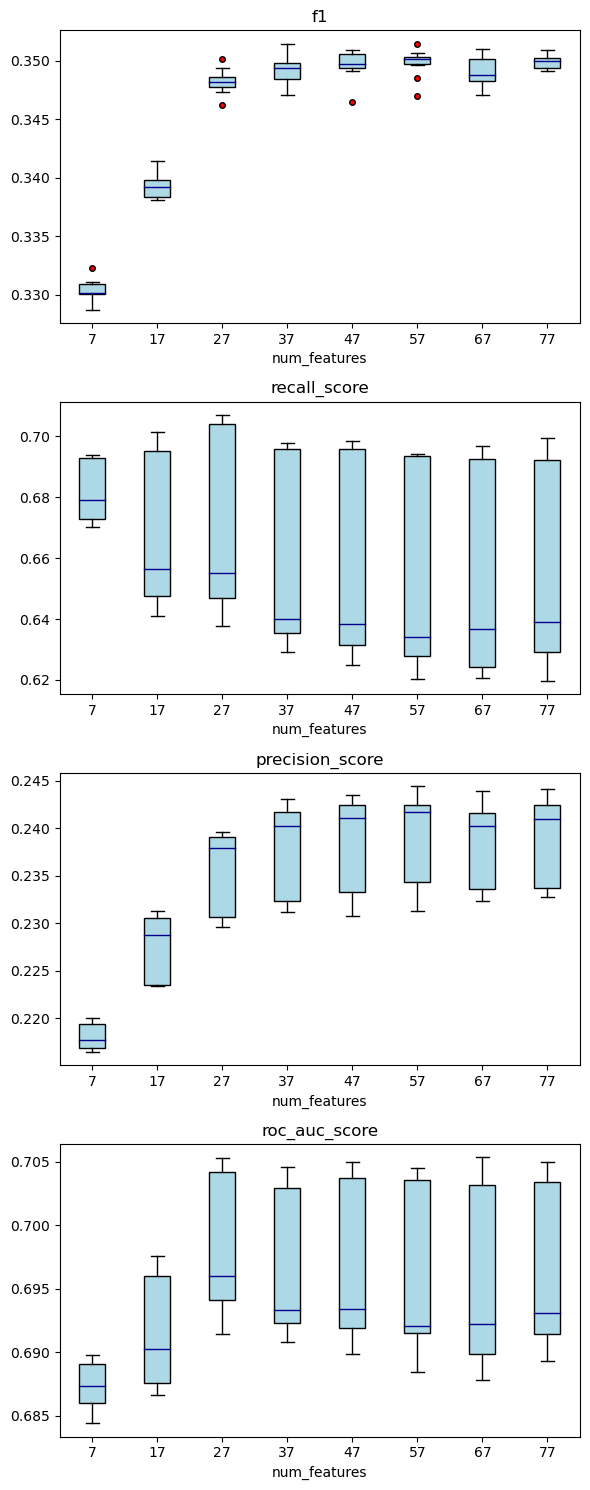

In [86]:
result_feature_selection_df = pd.DataFrame(result_feature_selection)

result_feature_selection_df[list(result_feature_selection_df[1][0].keys())] = pd.DataFrame(result_feature_selection_df[1].apply(lambda x: [x[i][1] for i in x.keys()]).apply(pd.Series)
)

result_feature_selection_df.rename(columns={0: 'num_features'}, inplace=True)
fig,ax = plt.subplots( nrows = len(list(result_feature_selection_df[1][0].keys())), figsize = (6,15))
result_feature_selection_df = result_feature_selection_df.sort_values(by='num_features')

for m in range(len(list(result_feature_selection_df[1][0].keys()))):
    metric = list(result_feature_selection_df[1][0].keys())[m]
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).max())
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).min())
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).median())

    ax[m].boxplot([group[1][metric].values for group in result_feature_selection_df.groupby('num_features')],
            labels = result_feature_selection_df['num_features'].unique()+3,
            patch_artist=True,
            widths=0.4,         
            medianprops=dict(color='darkblue'),
            boxprops=dict(facecolor='lightblue', edgecolor='black'),
             whiskerprops=dict(color='black'), 
             capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=4) )
                       
    ax[m].set_title(metric)
    ax[m].set_xlabel('num_features')

plt.tight_layout()
plt.show()

In [240]:
#We gonna go for 40 best features according to plot, since this amount tends to give more stable results 
# and there is no real improve further
# Redefine data with new selected columns
features =  list(set(list(ranked_df.sort_values(by = 'median_rank').head(40)['features'])).intersection(set(columns_to_use)))
features.extend(['encounter_id', 'patient_id'])
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]

features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(set(features)))
features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(set(features)))

data = pd.concat([X_train, y_train], axis = 1)

target = 'readmitted_binary'

with open('Learning_results/selected_features_rf.pkl', 'wb') as file:
    pickle.dump(features, file)

#### Logreg Lasso Coef

In [162]:
features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result','a1c_test_result'
                              ]
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

columns_to_use_full = columns_to_use #+ features_for_encoding

X_train = df_train[columns_to_use_full]
y_train = df_train[target]
X_test = df_test[columns_to_use_full]

data = pd.concat([X_train, y_train], axis = 1)

target = 'readmitted_binary'

In [164]:
model = LogisticRegression(solver='saga', max_iter = 200, 
                           class_weight = 'balanced', random_state = random_state )
params = {
    'penalty': 'l1',
    'max_iter': 1000
}

result_log_reg = []
result_log_reg.append(cross_validation(data, 
                 target, 
                 model, 
                 params,                
                 scaling = True,
                 features_for_scaling_minmax = features_for_scaling_minmax,
                 features_for_scaling_standard = features_for_scaling_standard,
                 cv=5))

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.315, F1_val: 0.316


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


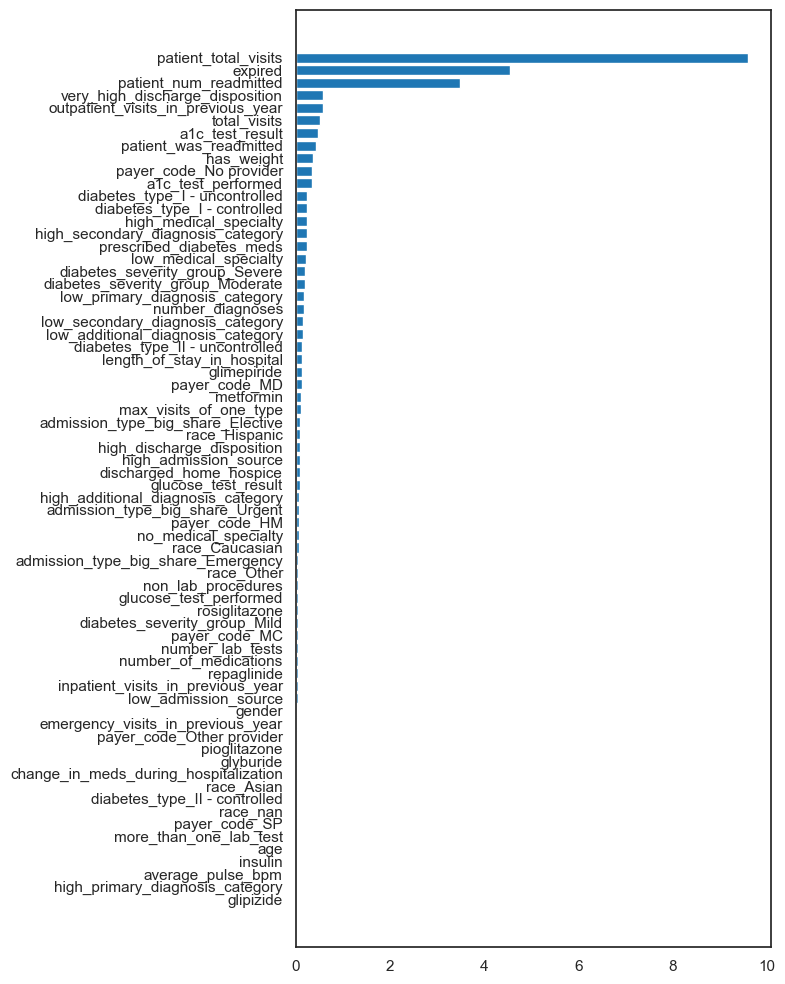

In [167]:

fdf = pd.DataFrame(np.abs(result_log_reg[0][-1][0]), columns = ['coef'])
fdf['features'] = result_log_reg[0][3]
fdf.set_index('features', inplace = True)
fdf['rank'] = fdf.rank(ascending=False)
fdf.reset_index(inplace = True)

plt.figure(figsize=(8, 10))
plt.barh(fdf.sort_values(by = 'rank', ascending = False)['features'], fdf.sort_values(by = 'rank', ascending = False)['coef'])
plt.tight_layout()
plt.show()

In [180]:
model = LogisticRegression(solver='saga', max_iter = 200, 
                           class_weight = 'balanced', random_state = random_state )
params = {
    'penalty': 'l1',
    'max_iter': 1000
}
result_feature_selection = []

for j in tqdm(range(40,70, 3)):

    features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
    features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))

    columns_to_use_full = list(set(columns_to_use).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
    columns_to_use_full.extend(['patient_id', 'encounter_id'])
                               
    X_train = df_train[columns_to_use_full]
    y_train = df_train[target]
    X_test = df_test[columns_to_use_full]

    data = pd.concat([X_train, y_train], axis = 1)

    result_feature_selection.append(
        (
            len(ranked_df)- j,
         cross_validation(data, 
                 target, 
                 model, 
                 params,
                               
                 scaling = True,
                 features_for_scaling_minmax = features_for_scaling_minmax,
                 features_for_scaling_standard = features_for_scaling_standard,
                          
                 upsample = False,   
                 cv=5)[1]
        )
    )

  0%|                                                    | 0/10 [00:00<?, ?it/s]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.313, F1_val: 0.317


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|████████▊           

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.314, F1_val: 0.317


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|█████████████▏      

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.314, F1_val: 0.318


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|█████████████████▌  

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.314, F1_val: 0.316


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████████████████████

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.306, F1_val: 0.311


 60%|██████████████████████████▍                 | 6/10 [04:05<02:07, 31.82s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.301, F1_val: 0.307


 70%|██████████████████████████████▊             | 7/10 [04:11<01:10, 23.61s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.302, F1_val: 0.309


 80%|███████████████████████████████████▏        | 8/10 [04:17<00:35, 17.77s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.304, F1_val: 0.311


 90%|███████████████████████████████████████▌    | 9/10 [04:21<00:13, 13.61s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.297, F1_val: 0.298


100%|███████████████████████████████████████████| 10/10 [04:22<00:00, 26.29s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.312, F1_val: 0.313


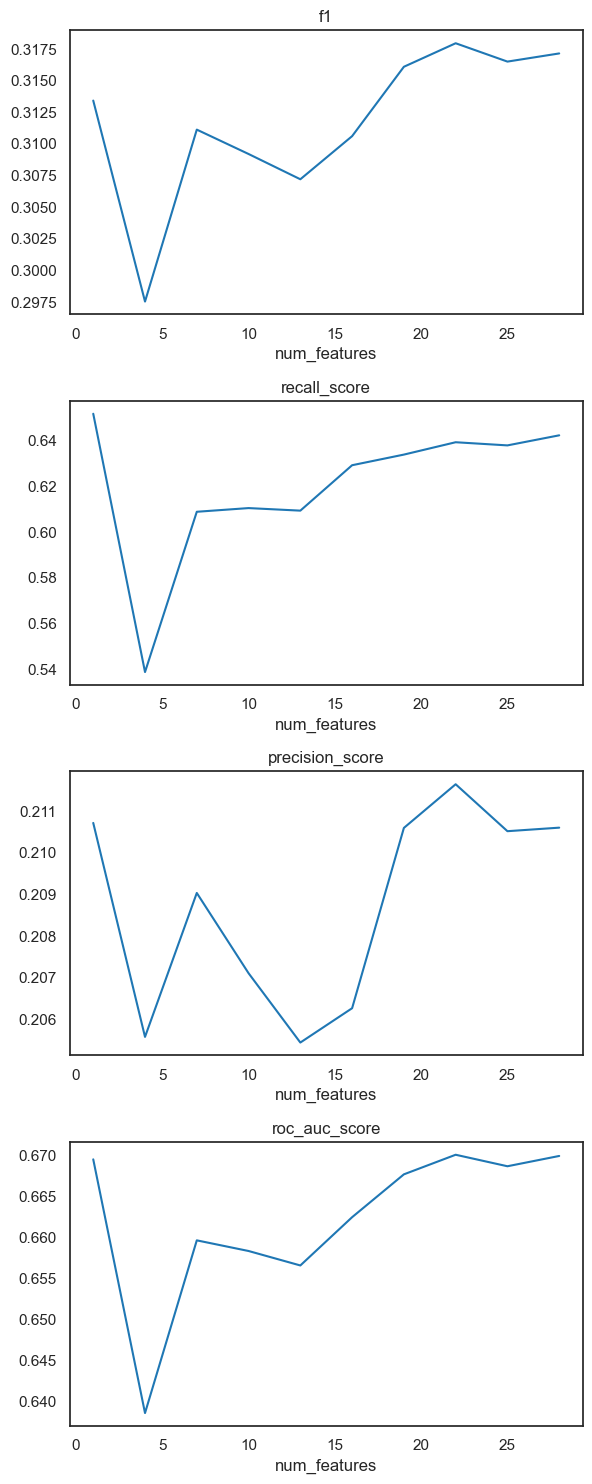

In [181]:
result_feature_selection_df = pd.DataFrame(result_feature_selection)

result_feature_selection_df[list(result_feature_selection_df[1][0].keys())] = pd.DataFrame(result_feature_selection_df[1].apply(lambda x: [x[i][1] for i in x.keys()]).apply(pd.Series)
)

result_feature_selection_df.rename(columns={0: 'num_features'}, inplace=True)
fig,ax = plt.subplots( nrows = len(list(result_feature_selection_df[1][0].keys())), figsize = (6,15))
result_feature_selection_df = result_feature_selection_df.sort_values(by='num_features')

for m in range(len(list(result_feature_selection_df[1][0].keys()))):
    metric = list(result_feature_selection_df[1][0].keys())[m]
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).max())
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).min())
    ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).median())

    # ax[m].boxplot([group[1][metric].values for group in result_feature_selection_df.groupby('num_features')],
    #         labels = result_feature_selection_df['num_features'].unique(),
    #         patch_artist=True,
    #         widths=0.4,         
    #         medianprops=dict(color='darkblue'),
    #         boxprops=dict(facecolor='lightblue', edgecolor='black'),
    #          whiskerprops=dict(color='black'), 
    #          capprops=dict(color='black'),
    #         flierprops=dict(markerfacecolor='red', marker='o', markersize=4) )
                       
    ax[m].set_title(metric)
    ax[m].set_xlabel('num_features')

plt.tight_layout()
plt.show()

### Model selection

#### RF

In [214]:
#change grid based on knowledge from feature selection

model = RandomForestClassifier(random_state = random_state)
rf_params = {
    'n_estimators': np.arange(150, 200, 10),
    'max_depth': np.arange(10, 30, 2),
    'min_samples_split': np.arange(0.0002, 0.001, 0.0001),
    'min_samples_leaf': np.arange(0.0002, 0.001, 0.0001),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': np.arange(0.3,0.9,0.1),
}

rf_result = []
for i in tqdm(range(100)):
    random_params = {}
    for key, values in rf_params.items():
        random_params[key] = random.choice(values)
    rf_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params,
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,    
                     upsample = False,   
                     cv=5))

  1%|▍                                        | 1/100 [00:36<1:00:47, 36.85s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.3,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.369, F1_val: 0.341


  2%|▊                                        | 2/100 [02:12<1:57:05, 71.69s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=14, max_features=0.8000000000000002,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.460, F1_val: 0.348


  3%|█▏                                       | 3/100 [03:16<1:49:39, 67.83s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=0.4,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0005, n_estimators=170,
                       random_state=42)
F1 train: 0.502, F1_val: 0.350


  4%|█▋                                       | 4/100 [05:05<2:14:43, 84.20s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=12, max_features=0.9000000000000001,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.394, F1_val: 0.345


  5%|██                                       | 5/100 [06:02<1:57:42, 74.34s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_features=0.3,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0002, n_estimators=190,
                       random_state=42)
F1 train: 0.505, F1_val: 0.351


  6%|██▍                                      | 6/100 [08:01<2:20:17, 89.55s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.8000000000000002,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=190, random_state=42)
F1 train: 0.463, F1_val: 0.349


  7%|██▊                                      | 7/100 [09:21<2:13:58, 86.44s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=28, max_features=0.4, min_samples_leaf=0.0002,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=190, random_state=42)
F1 train: 0.649, F1_val: 0.337


  8%|███▎                                     | 8/100 [10:59<2:18:25, 90.28s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=24, max_features=0.7000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.427, F1_val: 0.350


  9%|███▌                                    | 9/100 [13:02<2:32:25, 100.50s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=26, max_features=0.8000000000000002,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.500, F1_val: 0.350


 10%|████                                    | 10/100 [14:09<2:15:11, 90.13s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=14, max_features=0.5,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.411, F1_val: 0.349


 11%|████▍                                   | 11/100 [14:57<1:54:25, 77.14s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=26, max_features=0.3, min_samples_leaf=0.0002,
                       min_samples_split=0.0002, n_estimators=150,
                       random_state=42)
F1 train: 0.622, F1_val: 0.340


 12%|████▊                                   | 12/100 [15:54<1:44:08, 71.01s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=26, max_features=0.3,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0002, n_estimators=180,
                       random_state=42)
F1 train: 0.461, F1_val: 0.350


 13%|█████▏                                  | 13/100 [17:04<1:42:19, 70.57s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.5,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0002, n_estimators=170,
                       random_state=42)
F1 train: 0.385, F1_val: 0.345


 14%|█████▌                                  | 14/100 [18:46<1:54:44, 80.05s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.9000000000000001,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0002, n_estimators=150,
                       random_state=42)
F1 train: 0.497, F1_val: 0.346


 15%|██████                                  | 15/100 [19:34<1:39:48, 70.45s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=16, max_features=0.3, min_samples_leaf=0.0005,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.424, F1_val: 0.352


 16%|██████▍                                 | 16/100 [21:20<1:53:45, 81.25s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.9000000000000001, min_samples_leaf=0.0002,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.400, F1_val: 0.341


 17%|██████▊                                 | 17/100 [22:11<1:39:43, 72.09s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.3, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=190,
                       random_state=42)
F1 train: 0.386, F1_val: 0.344


 18%|███████▏                                | 18/100 [22:51<1:25:30, 62.56s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=0.3,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.385, F1_val: 0.346


 19%|███████▌                                | 19/100 [24:28<1:38:08, 72.70s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28,
                       max_features=0.7000000000000002,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=190, random_state=42)
F1 train: 0.398, F1_val: 0.347


 20%|████████                                | 20/100 [26:04<1:46:26, 79.83s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.8000000000000002,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=160, random_state=42)
F1 train: 0.414, F1_val: 0.349


 21%|████████▍                               | 21/100 [26:51<1:31:59, 69.87s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=10, max_features=0.3,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=190, random_state=42)
F1 train: 0.372, F1_val: 0.340


 22%|████████▊                               | 22/100 [28:43<1:47:20, 82.57s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.8000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=180, random_state=42)
F1 train: 0.427, F1_val: 0.350


 23%|█████████▏                              | 23/100 [30:43<2:00:18, 93.74s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=24, max_features=0.9000000000000001,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.459, F1_val: 0.351


 24%|█████████▎                             | 24/100 [32:42<2:08:39, 101.57s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=18, max_features=0.9000000000000001,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.416, F1_val: 0.348


 25%|██████████                              | 25/100 [34:12<2:02:23, 97.91s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.395, F1_val: 0.348


 26%|██████████▍                             | 26/100 [34:55<1:40:30, 81.50s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.4,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=160, random_state=42)
F1 train: 0.369, F1_val: 0.340


 27%|██████████▊                             | 27/100 [35:55<1:31:26, 75.15s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=28, max_features=0.4, min_samples_leaf=0.0005,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.436, F1_val: 0.351


 28%|███████████▏                            | 28/100 [37:20<1:33:39, 78.04s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.6000000000000001,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.387, F1_val: 0.346


 29%|███████████▌                            | 29/100 [38:26<1:27:55, 74.30s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, max_features=0.7000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.374, F1_val: 0.341


 30%|████████████                            | 30/100 [39:07<1:15:09, 64.43s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features=0.3,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=170,
                       random_state=42)
F1 train: 0.385, F1_val: 0.345


 31%|████████████▍                           | 31/100 [40:30<1:20:24, 69.92s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features=0.8000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0005, n_estimators=150,
                       random_state=42)
F1 train: 0.400, F1_val: 0.345


 32%|████████████▊                           | 32/100 [41:14<1:10:26, 62.16s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=22, max_features=0.3,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=150,
                       random_state=42)
F1 train: 0.397, F1_val: 0.348


 33%|█████████████▏                          | 33/100 [43:23<1:31:47, 82.21s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.8000000000000002,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=190, random_state=42)
F1 train: 0.545, F1_val: 0.348


 34%|█████████████▌                          | 34/100 [44:38<1:27:58, 79.98s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24,
                       max_features=0.7000000000000002,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.388, F1_val: 0.345


 35%|██████████████                          | 35/100 [45:56<1:26:05, 79.47s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.387, F1_val: 0.346


 36%|██████████████▍                         | 36/100 [47:02<1:20:26, 75.41s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.4, min_samples_leaf=0.0005,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.434, F1_val: 0.350


 37%|██████████████▊                         | 37/100 [48:20<1:20:04, 76.26s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.4, min_samples_leaf=0.0002,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.588, F1_val: 0.342


 38%|███████████████▏                        | 38/100 [49:46<1:21:50, 79.21s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=22, max_features=0.6000000000000001,
                       min_samples_leaf=0.0002, min_samples_split=0.0005,
                       n_estimators=150, random_state=42)
F1 train: 0.650, F1_val: 0.334


 39%|███████████████▌                        | 39/100 [50:53<1:16:47, 75.53s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.393, F1_val: 0.346


 40%|████████████████                        | 40/100 [53:01<1:31:20, 91.34s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_features=0.8000000000000002,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.559, F1_val: 0.345


 41%|████████████████▍                       | 41/100 [54:44<1:33:10, 94.76s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features=0.8000000000000002,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.400, F1_val: 0.346


 42%|████████████████▍                      | 42/100 [56:58<1:42:58, 106.53s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.9000000000000001, min_samples_leaf=0.0005,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=190, random_state=42)
F1 train: 0.455, F1_val: 0.349


 43%|████████████████▊                      | 43/100 [58:26<1:35:52, 100.92s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=0.9000000000000001,
                       min_samples_leaf=0.0005, min_samples_split=0.0005,
                       n_estimators=160, random_state=42)
F1 train: 0.377, F1_val: 0.341


 44%|█████████████████▌                      | 44/100 [59:12<1:18:44, 84.36s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.3, min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0002, n_estimators=190,
                       random_state=42)
F1 train: 0.364, F1_val: 0.340


 45%|█████████████████                     | 45/100 [1:00:37<1:17:43, 84.79s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.8000000000000002,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0002, n_estimators=150,
                       random_state=42)
F1 train: 0.394, F1_val: 0.345


 46%|█████████████████▍                    | 46/100 [1:01:23<1:05:49, 73.14s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.3, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=160,
                       random_state=42)
F1 train: 0.395, F1_val: 0.346


 47%|█████████████████▊                    | 47/100 [1:02:30<1:02:50, 71.14s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.4,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.467, F1_val: 0.352


 48%|██████████████████▏                   | 48/100 [1:04:00<1:06:40, 76.92s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=26, max_features=0.7000000000000002,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0002, n_estimators=150,
                       random_state=42)
F1 train: 0.556, F1_val: 0.347


 49%|██████████████████▌                   | 49/100 [1:04:58<1:00:30, 71.19s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=14, max_features=0.4,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=170, random_state=42)
F1 train: 0.452, F1_val: 0.351


 50%|████████████████████                    | 50/100 [1:06:09<59:19, 71.19s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=0.7000000000000002,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.383, F1_val: 0.340


 51%|████████████████████▍                   | 51/100 [1:07:20<57:57, 70.96s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=12, max_features=0.5, min_samples_leaf=0.0002,
                       min_samples_split=0.0002, n_estimators=170,
                       random_state=42)
F1 train: 0.454, F1_val: 0.343


 52%|████████████████████▊                   | 52/100 [1:08:13<52:34, 65.72s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=0.4,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.390, F1_val: 0.346


 53%|█████████████████████▏                  | 53/100 [1:09:45<57:32, 73.45s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.7000000000000002,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0002, n_estimators=150,
                       random_state=42)
F1 train: 0.494, F1_val: 0.349


 54%|█████████████████████▌                  | 54/100 [1:10:34<50:38, 66.05s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=0.4,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.407, F1_val: 0.348


 55%|██████████████████████                  | 55/100 [1:12:18<58:15, 77.67s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=24, max_features=0.8000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0002, n_estimators=170,
                       random_state=42)
F1 train: 0.429, F1_val: 0.349


 56%|██████████████████████▍                 | 56/100 [1:13:13<51:58, 70.88s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.4, min_samples_leaf=0.0005,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=150, random_state=42)
F1 train: 0.433, F1_val: 0.351


 57%|██████████████████████▊                 | 57/100 [1:15:03<59:03, 82.41s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=28, max_features=0.8000000000000002,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.500, F1_val: 0.350


 58%|███████████████████████▏                | 58/100 [1:16:31<58:50, 84.07s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22,
                       max_features=0.6000000000000001, min_samples_leaf=0.0002,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.597, F1_val: 0.341


 59%|███████████████████████▌                | 59/100 [1:18:04<59:16, 86.74s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features=0.8000000000000002,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.453, F1_val: 0.344


 60%|████████████████████████                | 60/100 [1:18:48<49:20, 74.00s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=14, max_features=0.3,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.464, F1_val: 0.350


 61%|████████████████████████▍               | 61/100 [1:19:50<45:46, 70.43s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features=0.5, min_samples_leaf=0.0002,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.453, F1_val: 0.345


 62%|████████████████████████▊               | 62/100 [1:21:42<52:34, 83.02s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=26, max_features=0.8000000000000002,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.456, F1_val: 0.350


 63%|█████████████████████████▏              | 63/100 [1:23:50<59:29, 96.47s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=24, max_features=0.9000000000000001,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.432, F1_val: 0.348


 64%|█████████████████████████▌              | 64/100 [1:25:06<54:09, 90.26s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=16, max_features=0.5,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0002, n_estimators=180,
                       random_state=42)
F1 train: 0.404, F1_val: 0.349


 65%|████████████████████████             | 65/100 [1:27:19<1:00:12, 103.21s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=26, max_features=0.8000000000000002,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.705, F1_val: 0.323


 66%|██████████████████████████▍             | 66/100 [1:28:48<55:58, 98.77s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.8000000000000002,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=150, random_state=42)
F1 train: 0.401, F1_val: 0.347


 67%|██████████████████████████▏            | 67/100 [1:30:54<58:54, 107.10s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=20, max_features=0.9000000000000001,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0002, n_estimators=190,
                       random_state=42)
F1 train: 0.393, F1_val: 0.346


 68%|██████████████████████████▌            | 68/100 [1:32:32<55:39, 104.37s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.7000000000000002,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=170, random_state=42)
F1 train: 0.485, F1_val: 0.351


 69%|███████████████████████████▌            | 69/100 [1:33:29<46:30, 90.02s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, max_features=0.5,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=170, random_state=42)
F1 train: 0.381, F1_val: 0.341


 70%|████████████████████████████            | 70/100 [1:35:32<49:54, 99.82s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=0.9000000000000001,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0002, n_estimators=190,
                       random_state=42)
F1 train: 0.402, F1_val: 0.347


 71%|███████████████████████████▋           | 71/100 [1:37:39<52:15, 108.11s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.9000000000000001,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0005, n_estimators=170,
                       random_state=42)
F1 train: 0.557, F1_val: 0.343


 72%|████████████████████████████           | 72/100 [1:39:57<54:39, 117.12s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=24, max_features=0.9000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0005, n_estimators=190,
                       random_state=42)
F1 train: 0.504, F1_val: 0.350


 73%|█████████████████████████████▏          | 73/100 [1:40:45<43:20, 96.31s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.3,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.430, F1_val: 0.348


 74%|█████████████████████████████▌          | 74/100 [1:41:31<35:13, 81.30s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.3,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.408, F1_val: 0.351


 75%|██████████████████████████████          | 75/100 [1:42:14<29:05, 69.81s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=18, max_features=0.3,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.386, F1_val: 0.346


 76%|██████████████████████████████▍         | 76/100 [1:42:54<24:17, 60.74s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=16, max_features=0.3,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=150, random_state=42)
F1 train: 0.395, F1_val: 0.347


 77%|██████████████████████████████▊         | 77/100 [1:43:50<22:48, 59.51s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features=0.4,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=190, random_state=42)
F1 train: 0.381, F1_val: 0.344


 78%|███████████████████████████████▏        | 78/100 [1:45:09<23:53, 65.14s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.387, F1_val: 0.346


 79%|███████████████████████████████▌        | 79/100 [1:46:24<23:50, 68.10s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.6000000000000001,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0002, n_estimators=160,
                       random_state=42)
F1 train: 0.387, F1_val: 0.345


 80%|████████████████████████████████        | 80/100 [1:48:25<28:02, 84.13s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.9000000000000001, min_samples_leaf=0.0002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.585, F1_val: 0.341


 81%|████████████████████████████████▍       | 81/100 [1:49:22<24:04, 76.04s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=14, max_features=0.4,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0002, n_estimators=170,
                       random_state=42)
F1 train: 0.381, F1_val: 0.344


 82%|████████████████████████████████▊       | 82/100 [1:50:21<21:12, 70.72s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22, max_features=0.4,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.401, F1_val: 0.348


 83%|█████████████████████████████████▏      | 83/100 [1:51:44<21:07, 74.57s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=0.6000000000000001,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.393, F1_val: 0.347


 84%|█████████████████████████████████▌      | 84/100 [1:52:42<18:30, 69.40s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=26, max_features=0.4,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.383, F1_val: 0.346


 85%|██████████████████████████████████      | 85/100 [1:53:35<16:10, 64.67s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.4, min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.412, F1_val: 0.349


 86%|██████████████████████████████████▍     | 86/100 [1:55:28<18:28, 79.21s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=12, max_features=0.9000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.421, F1_val: 0.346


 87%|██████████████████████████████████▊     | 87/100 [1:56:19<15:18, 70.68s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.4, min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0005, n_estimators=150,
                       random_state=42)
F1 train: 0.382, F1_val: 0.344


 88%|███████████████████████████████████▏    | 88/100 [1:58:08<16:26, 82.24s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=24, max_features=0.9000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=150, random_state=42)
F1 train: 0.504, F1_val: 0.350


 89%|███████████████████████████████████▌    | 89/100 [1:58:52<12:56, 70.60s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.3,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.408, F1_val: 0.350


 90%|████████████████████████████████████    | 90/100 [1:59:31<10:11, 61.19s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.3,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.386, F1_val: 0.345


 91%|████████████████████████████████████▍   | 91/100 [2:00:24<08:47, 58.62s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.4, min_samples_leaf=0.0005,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.436, F1_val: 0.352


 92%|████████████████████████████████████▊   | 92/100 [2:01:20<07:42, 57.84s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26, max_features=0.4,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.382, F1_val: 0.344


 93%|█████████████████████████████████████▏  | 93/100 [2:02:34<07:20, 62.87s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.7000000000000002,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.388, F1_val: 0.345


 94%|█████████████████████████████████████▌  | 94/100 [2:03:50<06:40, 66.79s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.6000000000000001,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.387, F1_val: 0.346


 95%|██████████████████████████████████████  | 95/100 [2:04:55<05:30, 66.12s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features=0.5,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=180, random_state=42)
F1 train: 0.380, F1_val: 0.342


 96%|██████████████████████████████████████▍ | 96/100 [2:05:54<04:15, 63.93s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=14, max_features=0.4,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.381, F1_val: 0.344


 97%|██████████████████████████████████████▊ | 97/100 [2:06:40<02:55, 58.54s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.3,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=160, random_state=42)
F1 train: 0.387, F1_val: 0.344


 98%|███████████████████████████████████████▏| 98/100 [2:08:48<02:38, 79.43s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=22, max_features=0.8000000000000002,
                       min_samples_leaf=0.0002, min_samples_split=0.0002,
                       n_estimators=180, random_state=42)
F1 train: 0.701, F1_val: 0.325


 99%|███████████████████████████████████████▌| 99/100 [2:09:38<01:10, 70.80s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_features=0.3,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.379, F1_val: 0.344


100%|███████████████████████████████████████| 100/100 [2:10:31<00:00, 78.32s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.5,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.389, F1_val: 0.342


In [215]:
with open('Learning_results/rf_model_selection.pkl', 'wb') as file:
    pickle.dump(rf_result, file)

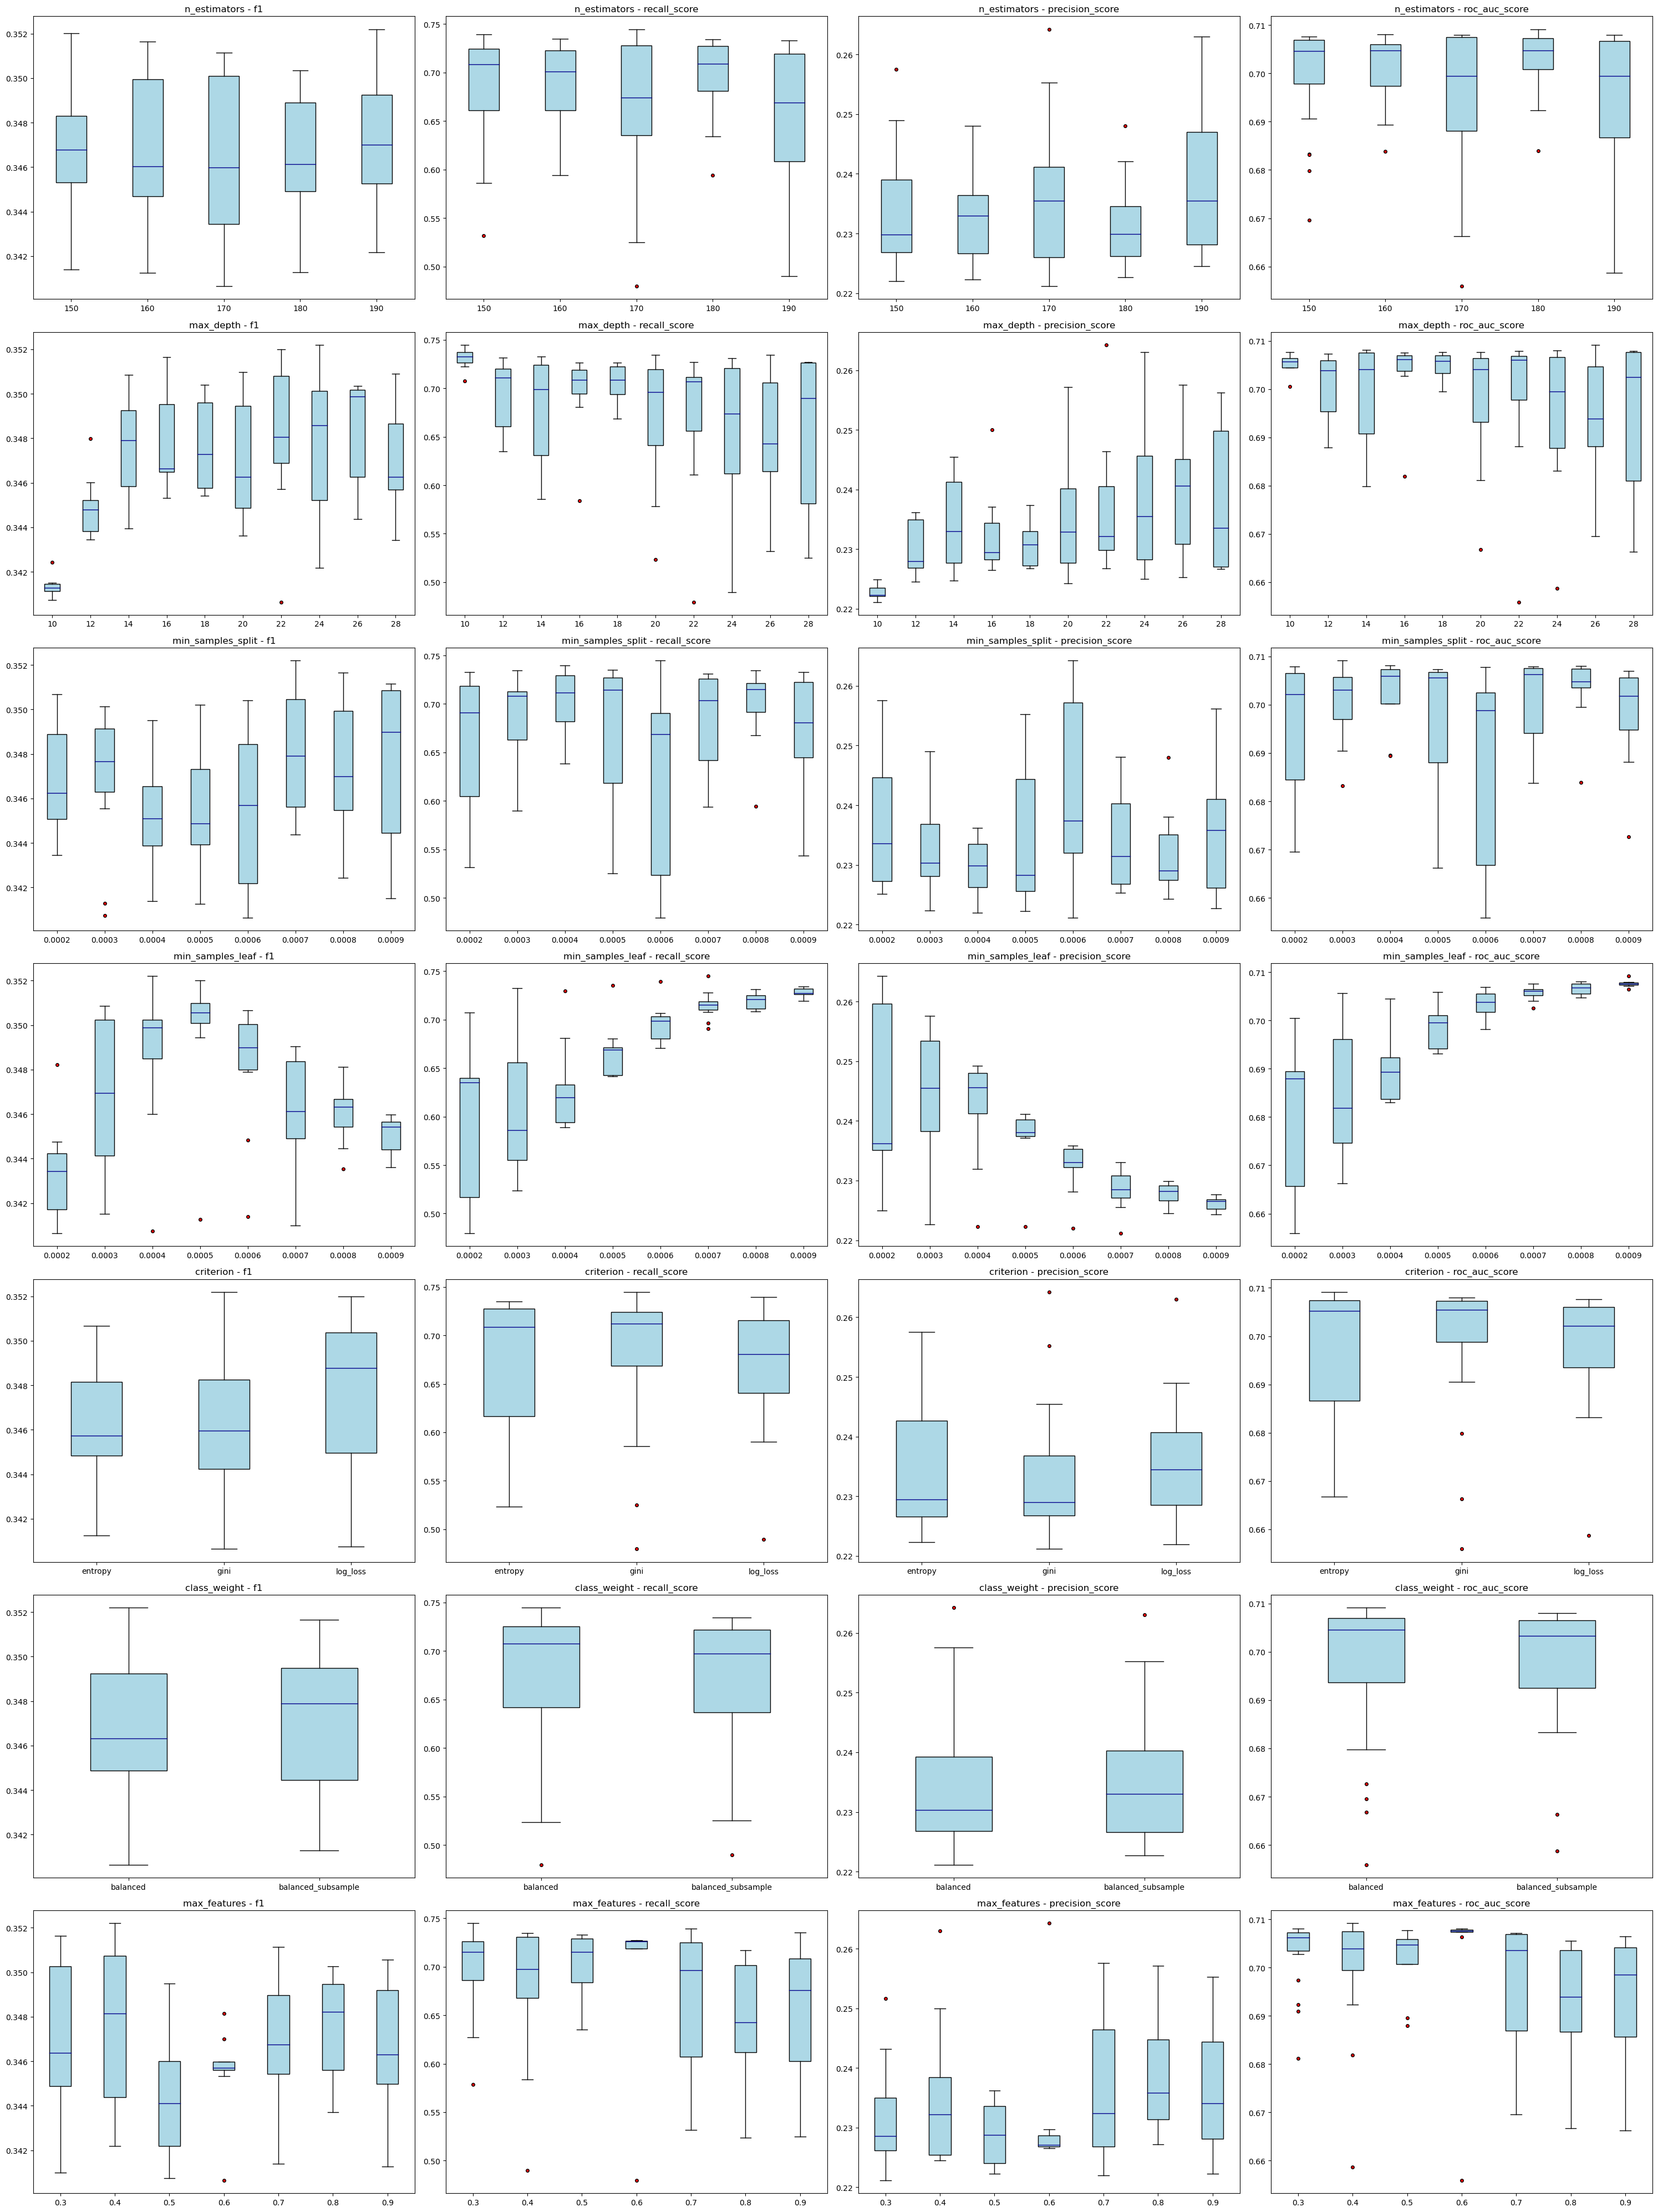

In [216]:
num_best_models = 90

best_models = sorted(rf_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

plot_metrics(rf_result, rf_params, best_models, figsize_param = (30,40))

In [217]:
best_rf = sorted(rf_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(RandomForestClassifier(**best_rf[0])))
print('F1: {}'.format(round(best_rf[1]['f1'][1],4)))

Best Model: RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.4,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42)
F1: 0.3522


#### GB

In [218]:
model = GradientBoostingClassifier(random_state = random_state)

gb_params = {
    'n_estimators': np.arange(50, 300, 20),
    'max_depth': np.arange(1, 10, 1),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.5,1.0,0.1),
    'min_samples_split': np.arange(0, 0.001, 0.0001) + 0.000001,
    'min_samples_leaf': np.arange(0, 0.002, 0.0002) + 0.000001,
    'loss': ['exponential', 'log_loss'],
    'max_features': np.arange(0.1,0.7,0.1),
}

gb_upsample_params = []
gb_result = []
for i in tqdm(range(30)):
    random_params = {}
    for key, values in gb_params.items():
        random_params[key] = random.choice(values)
        
    upsample = random.choice([True,False])
    if upsample == True:
       upsample_type = random.choice(['simple', 'SMOTE'])
    else:
       upsample_type = None
    gb_upsample_params.append([upsample, upsample_type])
    print(upsample, upsample_type)
    gb_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = upsample, 
                     upsample_type = upsample_type,
                     cv=5))
    

  0%|                                                    | 0/30 [00:00<?, ?it/s]

False None


  3%|█▍                                          | 1/30 [00:12<06:01, 12.47s/it]

GradientBoostingClassifier(max_depth=4, max_features=0.2,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000201, n_estimators=150,
                           random_state=42, subsample=0.5)
F1 train: 0.070, F1_val: 0.011
True simple


  7%|██▉                                         | 2/30 [01:27<23:02, 49.39s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=7, max_features=0.5,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000101, n_estimators=130,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.720, F1_val: 0.330
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, loss='exponential',
                           max_features=0.2, min_samples_leaf=0.001201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42, subsample=0.5)
F1 train: 0.000, F1_val: 0.000
True simple


 13%|█████▊                                      | 4/30 [02:04<12:43, 29.37s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=1,
                           max_features=0.5, min_samples_leaf=0.001801,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.677, F1_val: 0.327
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, max_depth=7, max_features=0.1,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.000201, n_estimators=210,
                           random_state=42, subsample=0.6)
F1 train: 0.000, F1_val: 0.000
True SMOTE


 20%|████████▊                                   | 6/30 [04:47<26:06, 65.28s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000201, n_estimators=230,
                           random_state=42, subsample=0.5)
F1 train: 0.848, F1_val: 0.201
True simple


 23%|██████████▎                                 | 7/30 [05:33<22:37, 59.01s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=5,
                           max_features=0.2, min_samples_leaf=0.001601,
                           min_samples_split=0.000701, n_estimators=270,
                           random_state=42, subsample=0.5)
F1 train: 0.794, F1_val: 0.326
True simple


 27%|███████████▋                                | 8/30 [06:35<22:02, 60.10s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           max_features=0.4, min_samples_leaf=0.001401,
                           min_samples_split=0.000701, n_estimators=250,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.734, F1_val: 0.332
True SMOTE


 30%|█████████████▏                              | 9/30 [07:44<22:01, 62.95s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=230, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.744, F1_val: 0.238
False None


 33%|██████████████▎                            | 10/30 [08:04<16:35, 49.76s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=2,
                           max_features=0.4, min_samples_leaf=0.001401,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=230, random_state=42, subsample=0.7)
F1 train: 0.067, F1_val: 0.033
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                           max_features=0.30000000000000004,
                           min_samples_leaf=1e-06, min_samples_split=1e-06,
                           n_estimators=50, random_state=42, subsample=0.7)
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=5,
                           max_features=0.30000000000000004,
                           min_samples_leaf=1e-06,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.000, F1_val: 0.000
False None


 43%|██████████████████▋                        | 13/30 [09:06<09:03, 31.96s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=2,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.000701, n_estimators=290,
                           random_state=42, subsample=0.5)
F1 train: 0.064, F1_val: 0.031
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=9,
                           max_features=0.5, min_samples_leaf=1e-06,
                           min_samples_split=0.000101, n_estimators=70,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=4,
                           max_features=0.1, min_samples_leaf=0.001001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7)
F1 train: 0.000, F1_val: 0.000
True SMOTE


 53%|██████████████████████▉                    | 16/30 [10:50<08:22, 35.91s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=90, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.784, F1_val: 0.222
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 57%|████████████████████████▎                  | 17/30 [11:03<06:1

GradientBoostingClassifier(loss='exponential', max_depth=2, max_features=0.4,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000701, n_estimators=150,
                           random_state=42, subsample=0.7)
F1 train: 0.031, F1_val: 0.002
True SMOTE


 60%|█████████████████████████▊                 | 18/30 [11:52<07:00, 35.04s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, max_features=0.4,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=230, random_state=42, subsample=0.5)
F1 train: 0.896, F1_val: 0.174
False None


 63%|███████████████████████████▏               | 19/30 [12:20<06:00, 32.78s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=6,
                           max_features=0.4, min_samples_leaf=0.001001,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=130, random_state=42, subsample=0.7)
F1 train: 0.183, F1_val: 0.072
False None


 67%|████████████████████████████▋              | 20/30 [12:35<04:34, 27.48s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           max_features=0.4,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=110, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.076, F1_val: 0.028
True SMOTE


 70%|██████████████████████████████             | 21/30 [13:55<06:31, 43.45s/it]

GradientBoostingClassifier(max_depth=8, max_features=0.30000000000000004,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=130, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.924, F1_val: 0.177
False None


 73%|███████████████████████████████▌           | 22/30 [15:46<08:29, 63.74s/it]

GradientBoostingClassifier(max_depth=9, max_features=0.6000000000000001,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=270, random_state=42, subsample=0.7)
F1 train: 0.575, F1_val: 0.104
True simple


 77%|████████████████████████████████▉          | 23/30 [15:55<05:30, 47.27s/it]

GradientBoostingClassifier(max_features=0.2, min_samples_leaf=0.001001,
                           min_samples_split=0.000701, n_estimators=50,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.704, F1_val: 0.330
True SMOTE


 80%|██████████████████████████████████▍        | 24/30 [17:00<05:15, 52.56s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features=0.5,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.000201, n_estimators=150,
                           random_state=42, subsample=0.5)
F1 train: 0.851, F1_val: 0.219
False None


 83%|███████████████████████████████████▊       | 25/30 [17:33<03:53, 46.62s/it]

GradientBoostingClassifier(loss='exponential', max_depth=4, max_features=0.5,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=170, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.065, F1_val: 0.012
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, max_features=0.1,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000201, n_estimators=90,
                           random_state=42, subsample=0.6)
F1 train: 0.000, F1_val: 0.000
True SMOTE


 90%|██████████████████████████████████████▋    | 27/30 [18:11<01:41, 33.81s/it]

GradientBoostingClassifier(loss='exponential', max_features=0.5,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000701, n_estimators=50,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.863, F1_val: 0.220
True SMOTE


 93%|████████████████████████████████████████▏  | 28/30 [19:54<01:49, 54.60s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=5, max_features=0.4,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.000701, n_estimators=270,
                           random_state=42, subsample=0.7)
F1 train: 0.925, F1_val: 0.188
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, max_depth=2, max_features=0.5,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=130, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|███████████████████████████████████████████| 30/30 [20:19<00:00, 40.63s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential',
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001201, min_samples_split=1e-06,
                           n_estimators=70, random_state=42, subsample=0.5)
F1 train: 0.047, F1_val: 0.009


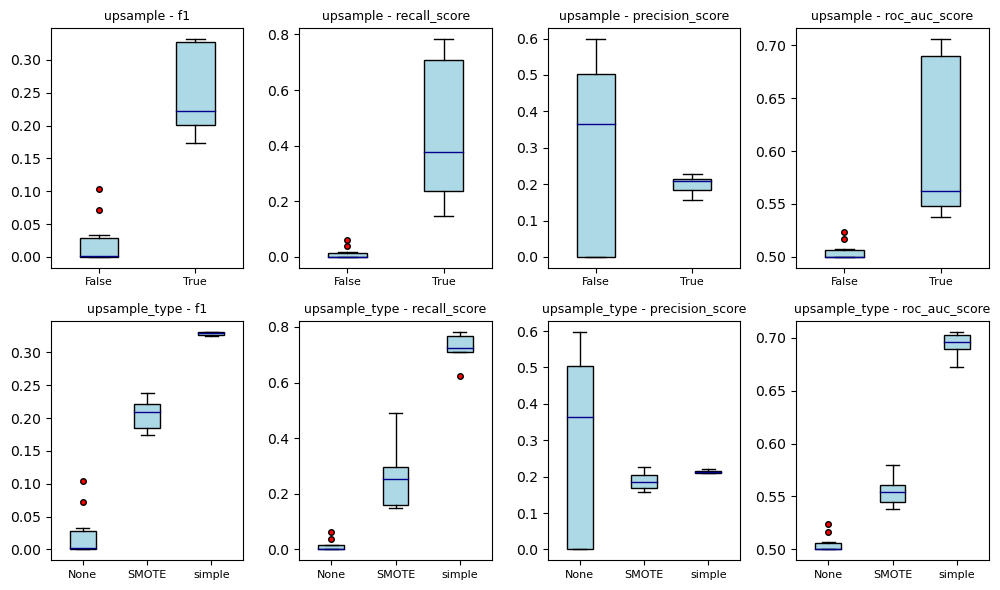

In [219]:
upsample_list = ['upsample', 'upsample_type']

fig,ax = plt.subplots(ncols = len(gb_result[0][1]), nrows = len(upsample_list), figsize = (10,6))
    
for m in range(len(gb_result[0][1])):
    for key in range(len(upsample_list)):
        hyperparam = upsample_list[key]
        metric = list(gb_result[0][1].keys())[m]
        hyperparam_df = pd.DataFrame(list(zip([i[key] for i in gb_upsample_params], [( gb_result[i][1][metric][1]) for i in range(len(gb_result))])),
                                     columns = ['hyperparameter', metric]).fillna('None')
        if hyperparam_df['hyperparameter'].dtype == 'O':
            hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
        hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
        
        ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
        labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
        patch_artist=True,
        widths=0.4,         
        medianprops=dict(color='darkblue'),
        boxprops=dict(facecolor='lightblue', edgecolor='black'),
         whiskerprops=dict(color='black'), 
         capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
                          ) 
        ax[key, m].tick_params(axis='x', labelsize=8)
        ax[key, m].set_title(hyperparam + ' - ' + metric, fontsize=9)

        ax[key, m].xaxis.grid(False)
        ax[key, m].yaxis.grid(False)
plt.tight_layout()
plt.savefig('Images/gradient_boosting_upsample_results.png')
plt.show()

In [221]:
#simple upsampling is the best approach here

model = GradientBoostingClassifier(random_state = random_state)

gb_params = {
    'n_estimators': np.arange(50, 300, 20),
    'max_depth': np.arange(1, 10, 1),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.5,1.1,0.1),
    'min_samples_split': np.arange(0, 0.001, 0.0001) + 0.000001,
    'min_samples_leaf': np.arange(0, 0.002, 0.0002) + 0.000001,
    'loss': ['exponential', 'log_loss'],
    'max_features': np.arange(0.1,0.7,0.1),
}

gb_result = []
for i in tqdm(range(100)):
    random_params = {}
    for key, values in gb_params.items():
        random_params[key] = random.choice(values)
        
    gb_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = True, 
                     upsample_type = 'simple',
                     cv=5))
    

  1%|▍                                          | 1/100 [00:32<54:03, 32.77s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=2,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=230, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.711, F1_val: 0.331


  2%|▊                                        | 2/100 [01:12<1:00:29, 37.03s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=1e-06, n_estimators=230,
                           random_state=42, subsample=0.5)
F1 train: 0.717, F1_val: 0.332


  3%|█▎                                         | 3/100 [01:46<57:13, 35.39s/it]

GradientBoostingClassifier(learning_rate=0.3, max_features=0.5,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000701, n_estimators=110,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.725, F1_val: 0.331


  4%|█▋                                       | 4/100 [03:24<1:36:18, 60.19s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=8,
                           max_features=0.5, min_samples_leaf=0.001201,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=150, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.737, F1_val: 0.336


  5%|██                                       | 5/100 [03:41<1:10:40, 44.63s/it]

GradientBoostingClassifier(max_features=0.1, min_samples_leaf=0.001401,
                           min_samples_split=0.000701, n_estimators=150,
                           random_state=42, subsample=0.7)
F1 train: 0.706, F1_val: 0.331


  6%|██▌                                        | 6/100 [03:48<50:04, 31.96s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=1,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=70, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.672, F1_val: 0.326


  7%|███                                        | 7/100 [04:28<53:13, 34.33s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=8,
                           max_features=0.4,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000701, n_estimators=70,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.834, F1_val: 0.335


  8%|███▍                                       | 8/100 [04:35<39:22, 25.68s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=4,
                           max_features=0.1,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=50, random_state=42, subsample=0.7)
F1 train: 0.709, F1_val: 0.330


  9%|███▊                                       | 9/100 [04:54<35:50, 23.63s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=4,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=90, random_state=42, subsample=0.6)
F1 train: 0.731, F1_val: 0.332


 10%|████▏                                     | 10/100 [05:48<49:28, 32.99s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=9,
                           max_features=0.1, min_samples_leaf=0.001001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=210, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.961, F1_val: 0.296


 11%|████▌                                     | 11/100 [06:18<47:27, 31.99s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features=0.1,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000701, n_estimators=130,
                           random_state=42, subsample=0.7)
F1 train: 0.723, F1_val: 0.334


 12%|█████                                     | 12/100 [06:31<38:36, 26.33s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=4, max_features=0.4,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000701, n_estimators=50,
                           random_state=42, subsample=0.6)
F1 train: 0.693, F1_val: 0.321


 13%|█████▍                                    | 13/100 [07:22<48:53, 33.72s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=6, max_features=0.5,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000701, n_estimators=110,
                           random_state=42, subsample=0.7)
F1 train: 0.715, F1_val: 0.327


 14%|█████▌                                  | 14/100 [08:23<1:00:21, 42.11s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7)
F1 train: 0.751, F1_val: 0.340


 15%|██████                                  | 15/100 [09:42<1:15:31, 53.32s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential',
                           max_features=0.5, min_samples_leaf=0.001201,
                           min_samples_split=0.000701, n_estimators=290,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.732, F1_val: 0.332


 16%|██████▋                                   | 16/100 [09:55<57:16, 40.92s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=2,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=90, random_state=42, subsample=0.6)
F1 train: 0.667, F1_val: 0.317


 17%|███████▏                                  | 17/100 [10:42<59:31, 43.03s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=7,
                           max_features=0.1, min_samples_leaf=0.001201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=270, random_state=42, subsample=0.5)
F1 train: 0.703, F1_val: 0.327


 18%|███████▏                                | 18/100 [12:34<1:26:45, 63.48s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=270, random_state=42, subsample=0.5)
F1 train: 0.725, F1_val: 0.335


 19%|███████▌                                | 19/100 [14:03<1:36:08, 71.21s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=8,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=250, random_state=42, subsample=0.6)
F1 train: 0.736, F1_val: 0.338


 20%|████████                                | 20/100 [14:11<1:09:51, 52.40s/it]

GradientBoostingClassifier(learning_rate=0.3, max_features=0.2,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=50, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.712, F1_val: 0.331


 21%|████████▍                               | 21/100 [15:06<1:09:52, 53.07s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=8, max_features=0.1,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=270, random_state=42, subsample=0.6)
F1 train: 0.937, F1_val: 0.293


 22%|████████▊                               | 22/100 [15:52<1:06:11, 50.91s/it]

GradientBoostingClassifier(learning_rate=0.2, max_features=0.4,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000101, n_estimators=250,
                           random_state=42, subsample=0.5)
F1 train: 0.732, F1_val: 0.333


 23%|█████████▋                                | 23/100 [16:11<53:03, 41.35s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=4,
                           max_features=0.1,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000701, n_estimators=150,
                           random_state=42, subsample=0.6)
F1 train: 0.670, F1_val: 0.323


 24%|██████████                                | 24/100 [16:24<41:35, 32.84s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=1, max_features=0.4,
                           min_samples_leaf=0.000201, min_samples_split=1e-06,
                           n_estimators=110, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.678, F1_val: 0.326


 25%|██████████▌                               | 25/100 [17:16<48:10, 38.54s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=7,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.000101, n_estimators=70,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.792, F1_val: 0.336


 26%|██████████▍                             | 26/100 [19:34<1:24:34, 68.58s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=7,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=230, random_state=42, subsample=0.7)
F1 train: 0.962, F1_val: 0.291


 27%|██████████▊                             | 27/100 [21:02<1:30:30, 74.39s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=4,
                           max_features=0.5, min_samples_leaf=0.001601,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=230, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.708, F1_val: 0.327


 28%|███████████▏                            | 28/100 [21:42<1:16:50, 64.03s/it]

GradientBoostingClassifier(max_depth=2, max_features=0.5,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=250, random_state=42, subsample=0.5)
F1 train: 0.707, F1_val: 0.330


 29%|███████████▌                            | 29/100 [22:02<1:00:11, 50.87s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000201, n_estimators=110,
                           random_state=42, subsample=0.7)
F1 train: 0.721, F1_val: 0.333


 30%|████████████                            | 30/100 [23:44<1:16:58, 65.98s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=8,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=230, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.945, F1_val: 0.298


 31%|█████████████                             | 31/100 [23:55<57:08, 49.69s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=2,
                           max_features=0.1, min_samples_leaf=0.001801,
                           min_samples_split=0.000501, n_estimators=130,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.653, F1_val: 0.318


 32%|█████████████▍                            | 32/100 [24:07<43:31, 38.40s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=1, max_features=0.4,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=110, random_state=42, subsample=0.6)
F1 train: 0.677, F1_val: 0.327


 33%|█████████████▊                            | 33/100 [24:25<35:54, 32.16s/it]

GradientBoostingClassifier(loss='exponential', max_depth=1, max_features=0.1,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=270, random_state=42, subsample=0.7)
F1 train: 0.674, F1_val: 0.326


 34%|██████████████▎                           | 34/100 [25:06<38:22, 34.89s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=130, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.726, F1_val: 0.333


 35%|██████████████▋                           | 35/100 [25:20<30:59, 28.60s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=1,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=150, random_state=42, subsample=0.6)
F1 train: 0.661, F1_val: 0.316


 36%|██████████████▍                         | 36/100 [27:33<1:03:57, 59.96s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=6,
                           max_features=0.4, min_samples_leaf=0.001401,
                           min_samples_split=0.000101, n_estimators=290,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.725, F1_val: 0.334


 37%|███████████████▌                          | 37/100 [27:53<50:08, 47.76s/it]

GradientBoostingClassifier(max_depth=1, max_features=0.2,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=230, random_state=42, subsample=0.6)
F1 train: 0.677, F1_val: 0.326


 38%|███████████████▉                          | 38/100 [28:15<41:26, 40.10s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001201, min_samples_split=1e-06,
                           n_estimators=170, random_state=42, subsample=0.6)
F1 train: 0.668, F1_val: 0.317


 39%|████████████████▍                         | 39/100 [29:41<54:46, 53.88s/it]

GradientBoostingClassifier(learning_rate=0.3, max_features=0.6000000000000001,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=270, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.747, F1_val: 0.329


 40%|████████████████▊                         | 40/100 [30:39<55:03, 55.06s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=4,
                           max_features=0.5, min_samples_leaf=1e-06,
                           min_samples_split=0.000501, n_estimators=150,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.704, F1_val: 0.323


 41%|████████████████▍                       | 41/100 [32:37<1:12:57, 74.19s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=4,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000201, n_estimators=270,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.759, F1_val: 0.332


 42%|█████████████████▋                        | 42/100 [32:59<56:35, 58.55s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=1,
                           max_features=0.5,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=1e-06, n_estimators=190,
                           random_state=42, subsample=0.7)
F1 train: 0.679, F1_val: 0.328


 43%|██████████████████                        | 43/100 [33:43<51:27, 54.16s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=7,
                           max_features=0.1,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000701, n_estimators=230,
                           random_state=42, subsample=0.7)
F1 train: 0.889, F1_val: 0.315


 44%|██████████████████▍                       | 44/100 [34:58<56:13, 60.23s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=9, max_features=0.2,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=270, random_state=42, subsample=0.5)
F1 train: 0.951, F1_val: 0.302


 45%|██████████████████▉                       | 45/100 [35:10<42:03, 45.89s/it]

GradientBoostingClassifier(max_depth=4, max_features=0.1,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=90, random_state=42, subsample=0.7)
F1 train: 0.709, F1_val: 0.330


 46%|███████████████████▎                      | 46/100 [35:37<36:04, 40.09s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           max_features=0.4, min_samples_leaf=1e-06,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=150, random_state=42, subsample=0.5)
F1 train: 0.726, F1_val: 0.331


 47%|███████████████████▋                      | 47/100 [36:20<36:10, 40.95s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=130, random_state=42, subsample=0.6)
F1 train: 0.853, F1_val: 0.324


 48%|████████████████████▏                     | 48/100 [37:19<40:11, 46.38s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=4,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=230, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.746, F1_val: 0.332


 49%|████████████████████▌                     | 49/100 [37:59<37:52, 44.55s/it]

GradientBoostingClassifier(max_depth=5, max_features=0.4,
                           min_samples_leaf=0.001601, min_samples_split=1e-06,
                           n_estimators=110, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.735, F1_val: 0.337


 50%|█████████████████████                     | 50/100 [39:23<47:00, 56.41s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=9,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000501, n_estimators=150,
                           random_state=42, subsample=0.5)
F1 train: 0.946, F1_val: 0.300


 51%|█████████████████████▍                    | 51/100 [40:02<41:50, 51.23s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=8, max_features=0.1,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7)
F1 train: 0.713, F1_val: 0.330


 52%|█████████████████████▊                    | 52/100 [41:12<45:20, 56.68s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=8,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=190, random_state=42, subsample=0.6)
F1 train: 0.722, F1_val: 0.332


 53%|█████████████████████▏                  | 53/100 [43:35<1:04:46, 82.68s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=8,
                           max_features=0.4, min_samples_leaf=0.001801,
                           min_samples_split=0.000101, n_estimators=290,
                           random_state=42, subsample=0.7)
F1 train: 0.934, F1_val: 0.309


 54%|██████████████████████▋                   | 54/100 [43:52<48:23, 63.11s/it]

GradientBoostingClassifier(learning_rate=0.3, max_features=0.2,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.000201, n_estimators=110,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.722, F1_val: 0.332


 55%|███████████████████████                   | 55/100 [45:21<52:58, 70.63s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=6,
                           max_features=0.4, min_samples_leaf=0.001401,
                           min_samples_split=0.000501, n_estimators=210,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.825, F1_val: 0.332


 56%|██████████████████████▍                 | 56/100 [47:47<1:08:31, 93.45s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=5,
                           max_features=0.6000000000000001,
                           min_samples_leaf=1e-06, min_samples_split=0.000501,
                           n_estimators=270, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.710, F1_val: 0.320


 57%|███████████████████████▉                  | 57/100 [48:09<51:31, 71.89s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=70, random_state=42, subsample=0.5)
F1 train: 0.783, F1_val: 0.335


 58%|████████████████████████▎                 | 58/100 [48:17<36:55, 52.74s/it]

GradientBoostingClassifier(max_depth=1, max_features=0.1,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=110, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.665, F1_val: 0.324


 59%|████████████████████████▊                 | 59/100 [48:40<30:02, 43.97s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.000201, n_estimators=130,
                           random_state=42, subsample=0.5)
F1 train: 0.670, F1_val: 0.318


 60%|█████████████████████████▏                | 60/100 [49:21<28:37, 42.93s/it]

GradientBoostingClassifier(max_depth=2, max_features=0.5,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=210, random_state=42, subsample=0.7)
F1 train: 0.706, F1_val: 0.329


 61%|█████████████████████████▌                | 61/100 [51:22<43:07, 66.35s/it]

GradientBoostingClassifier(max_depth=8, max_features=0.5,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=230, random_state=42, subsample=0.6)
F1 train: 0.876, F1_val: 0.334


 62%|██████████████████████████                | 62/100 [53:12<50:21, 79.51s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=250, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.738, F1_val: 0.336


 63%|██████████████████████████▍               | 63/100 [54:40<50:39, 82.14s/it]

GradientBoostingClassifier(loss='exponential', max_depth=6, max_features=0.4,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.000101, n_estimators=190,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.771, F1_val: 0.340


 64%|██████████████████████████▉               | 64/100 [56:25<53:19, 88.87s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=4,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=250, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.770, F1_val: 0.331


 65%|███████████████████████████▎              | 65/100 [56:45<39:46, 68.19s/it]

GradientBoostingClassifier(max_features=0.5, min_samples_leaf=0.001801,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=90, random_state=42, subsample=0.5)
F1 train: 0.713, F1_val: 0.332


 66%|███████████████████████████▋              | 66/100 [57:09<31:04, 54.82s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=9, max_features=0.4,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.000501, n_estimators=50,
                           random_state=42, subsample=0.5)
F1 train: 0.895, F1_val: 0.308


 67%|████████████████████████████▏             | 67/100 [58:30<34:29, 62.70s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.000101, n_estimators=270,
                           random_state=42, subsample=0.5)
F1 train: 0.711, F1_val: 0.329


 68%|████████████████████████████▌             | 68/100 [59:03<28:43, 53.85s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=9, max_features=0.5,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=50, random_state=42, subsample=0.7)
F1 train: 0.832, F1_val: 0.334


 69%|████████████████████████████▉             | 69/100 [59:37<24:47, 47.99s/it]

GradientBoostingClassifier(max_depth=1, max_features=0.6000000000000001,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=270, random_state=42, subsample=0.6)
F1 train: 0.679, F1_val: 0.326


 70%|████████████████████████████            | 70/100 [1:01:13<31:14, 62.47s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=8, max_features=0.4,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=210, random_state=42, subsample=0.6)
F1 train: 0.989, F1_val: 0.257


 71%|████████████████████████████▍           | 71/100 [1:01:31<23:39, 48.97s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=4, max_features=0.1,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=130, random_state=42, subsample=0.7)
F1 train: 0.671, F1_val: 0.321


 72%|████████████████████████████▊           | 72/100 [1:03:01<28:34, 61.24s/it]

GradientBoostingClassifier(max_depth=7, max_features=0.5,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.000201, n_estimators=170,
                           random_state=42, subsample=0.7)
F1 train: 0.818, F1_val: 0.336


 73%|█████████████████████████████▏          | 73/100 [1:03:31<23:25, 52.07s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=2,
                           max_features=0.4,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42, subsample=0.7)
F1 train: 0.664, F1_val: 0.317


 74%|█████████████████████████████▌          | 74/100 [1:04:19<21:56, 50.63s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=8,
                           max_features=0.2, min_samples_leaf=0.001401,
                           min_samples_split=0.000101, n_estimators=170,
                           random_state=42, subsample=0.6)
F1 train: 0.863, F1_val: 0.327


 75%|██████████████████████████████          | 75/100 [1:05:38<24:42, 59.29s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=4,
                           max_features=0.4,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=290, random_state=42, subsample=0.7)
F1 train: 0.697, F1_val: 0.321


 76%|██████████████████████████████▍         | 76/100 [1:05:51<18:09, 45.41s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.000701, n_estimators=70,
                           random_state=42, subsample=0.5)
F1 train: 0.661, F1_val: 0.316


 77%|██████████████████████████████▊         | 77/100 [1:07:47<25:31, 66.59s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=6,
                           max_features=0.4, min_samples_leaf=1e-06,
                           min_samples_split=1e-06, n_estimators=250,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.726, F1_val: 0.334


 78%|███████████████████████████████▏        | 78/100 [1:10:30<34:58, 95.39s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=9,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=190, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.995, F1_val: 0.264


 79%|██████████████████████████████▊        | 79/100 [1:12:24<35:23, 101.14s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=5,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=230, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.817, F1_val: 0.322


 80%|████████████████████████████████        | 80/100 [1:12:36<24:45, 74.28s/it]

GradientBoostingClassifier(loss='exponential', max_depth=2, max_features=0.1,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=130, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.689, F1_val: 0.327


 81%|████████████████████████████████▍       | 81/100 [1:13:46<23:08, 73.08s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=210, random_state=42, subsample=0.6)
F1 train: 0.729, F1_val: 0.336


 82%|████████████████████████████████▊       | 82/100 [1:15:32<24:49, 82.75s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=5,
                           max_features=0.5,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000101, n_estimators=270,
                           random_state=42, subsample=0.7)
F1 train: 0.710, F1_val: 0.321


 83%|█████████████████████████████████▏      | 83/100 [1:16:02<19:00, 67.10s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=8,
                           max_features=0.1,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000701, n_estimators=150,
                           random_state=42, subsample=0.6)
F1 train: 0.884, F1_val: 0.314


 84%|█████████████████████████████████▌      | 84/100 [1:16:13<13:25, 50.35s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=6,
                           max_features=0.2, min_samples_leaf=1e-06,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=50, random_state=42, subsample=0.5)
F1 train: 0.711, F1_val: 0.327


 85%|██████████████████████████████████      | 85/100 [1:17:10<13:02, 52.15s/it]

GradientBoostingClassifier(learning_rate=0.001, max_features=0.6000000000000001,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.000501, n_estimators=190,
                           random_state=42, subsample=0.7)
F1 train: 0.678, F1_val: 0.320


 86%|██████████████████████████████████▍     | 86/100 [1:17:34<10:10, 43.63s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=2, max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000101, n_estimators=230,
                           random_state=42, subsample=0.5)
F1 train: 0.657, F1_val: 0.318


 87%|██████████████████████████████████▊     | 87/100 [1:18:31<10:21, 47.83s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.000501, n_estimators=170,
                           random_state=42, subsample=0.6)
F1 train: 0.731, F1_val: 0.335


 88%|███████████████████████████████████▏    | 88/100 [1:18:56<08:12, 41.02s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=5,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000201, n_estimators=90,
                           random_state=42, subsample=0.7)
F1 train: 0.708, F1_val: 0.328


 89%|███████████████████████████████████▌    | 89/100 [1:20:46<11:16, 61.53s/it]

GradientBoostingClassifier(loss='exponential', max_depth=9,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=270, random_state=42, subsample=0.6)
F1 train: 0.946, F1_val: 0.317


 90%|████████████████████████████████████    | 90/100 [1:22:32<12:30, 75.04s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=250, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.730, F1_val: 0.337


 91%|████████████████████████████████████▍   | 91/100 [1:23:46<11:13, 74.79s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=9,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=130, random_state=42, subsample=0.5)
F1 train: 0.731, F1_val: 0.333


 92%|████████████████████████████████████▊   | 92/100 [1:24:29<08:41, 65.14s/it]

GradientBoostingClassifier(max_depth=4, max_features=0.2,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.000701, n_estimators=210,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.732, F1_val: 0.336


 93%|█████████████████████████████████████▏  | 93/100 [1:24:48<05:58, 51.15s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=2, max_features=0.1,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000501, n_estimators=210,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.640, F1_val: 0.313


 94%|█████████████████████████████████████▌  | 94/100 [1:24:54<03:46, 37.67s/it]

GradientBoostingClassifier(max_features=0.1,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=50, random_state=42, subsample=0.6)
F1 train: 0.689, F1_val: 0.325


 95%|██████████████████████████████████████  | 95/100 [1:25:57<03:46, 45.33s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential',
                           max_features=0.4,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=270, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.731, F1_val: 0.332


 96%|██████████████████████████████████████▍ | 96/100 [1:26:38<02:56, 44.06s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=9, max_features=0.4,
                           min_samples_leaf=1e-06,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=70, random_state=42, subsample=0.7)
F1 train: 0.758, F1_val: 0.337


 97%|██████████████████████████████████████▊ | 97/100 [1:27:06<01:57, 39.30s/it]

GradientBoostingClassifier(loss='exponential', max_features=0.1,
                           min_samples_leaf=0.001001, min_samples_split=1e-06,
                           n_estimators=270, random_state=42, subsample=0.7)
F1 train: 0.712, F1_val: 0.332


 98%|███████████████████████████████████████▏| 98/100 [1:27:19<01:02, 31.37s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=1, max_features=0.1,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42, subsample=0.7)
F1 train: 0.636, F1_val: 0.315


 99%|███████████████████████████████████████▌| 99/100 [1:28:07<00:36, 36.21s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=6,
                           max_features=0.2, min_samples_leaf=0.001401,
                           min_samples_split=0.000101, n_estimators=190,
                           random_state=42, subsample=0.7)
F1 train: 0.709, F1_val: 0.328


100%|███████████████████████████████████████| 100/100 [1:28:35<00:00, 53.16s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, max_features=0.2,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=250, random_state=42, subsample=0.7)
F1 train: 0.707, F1_val: 0.330


In [222]:
with open('Learning_results/gb_model_selection.pkl', 'wb') as file:
    pickle.dump(gb_result, file)

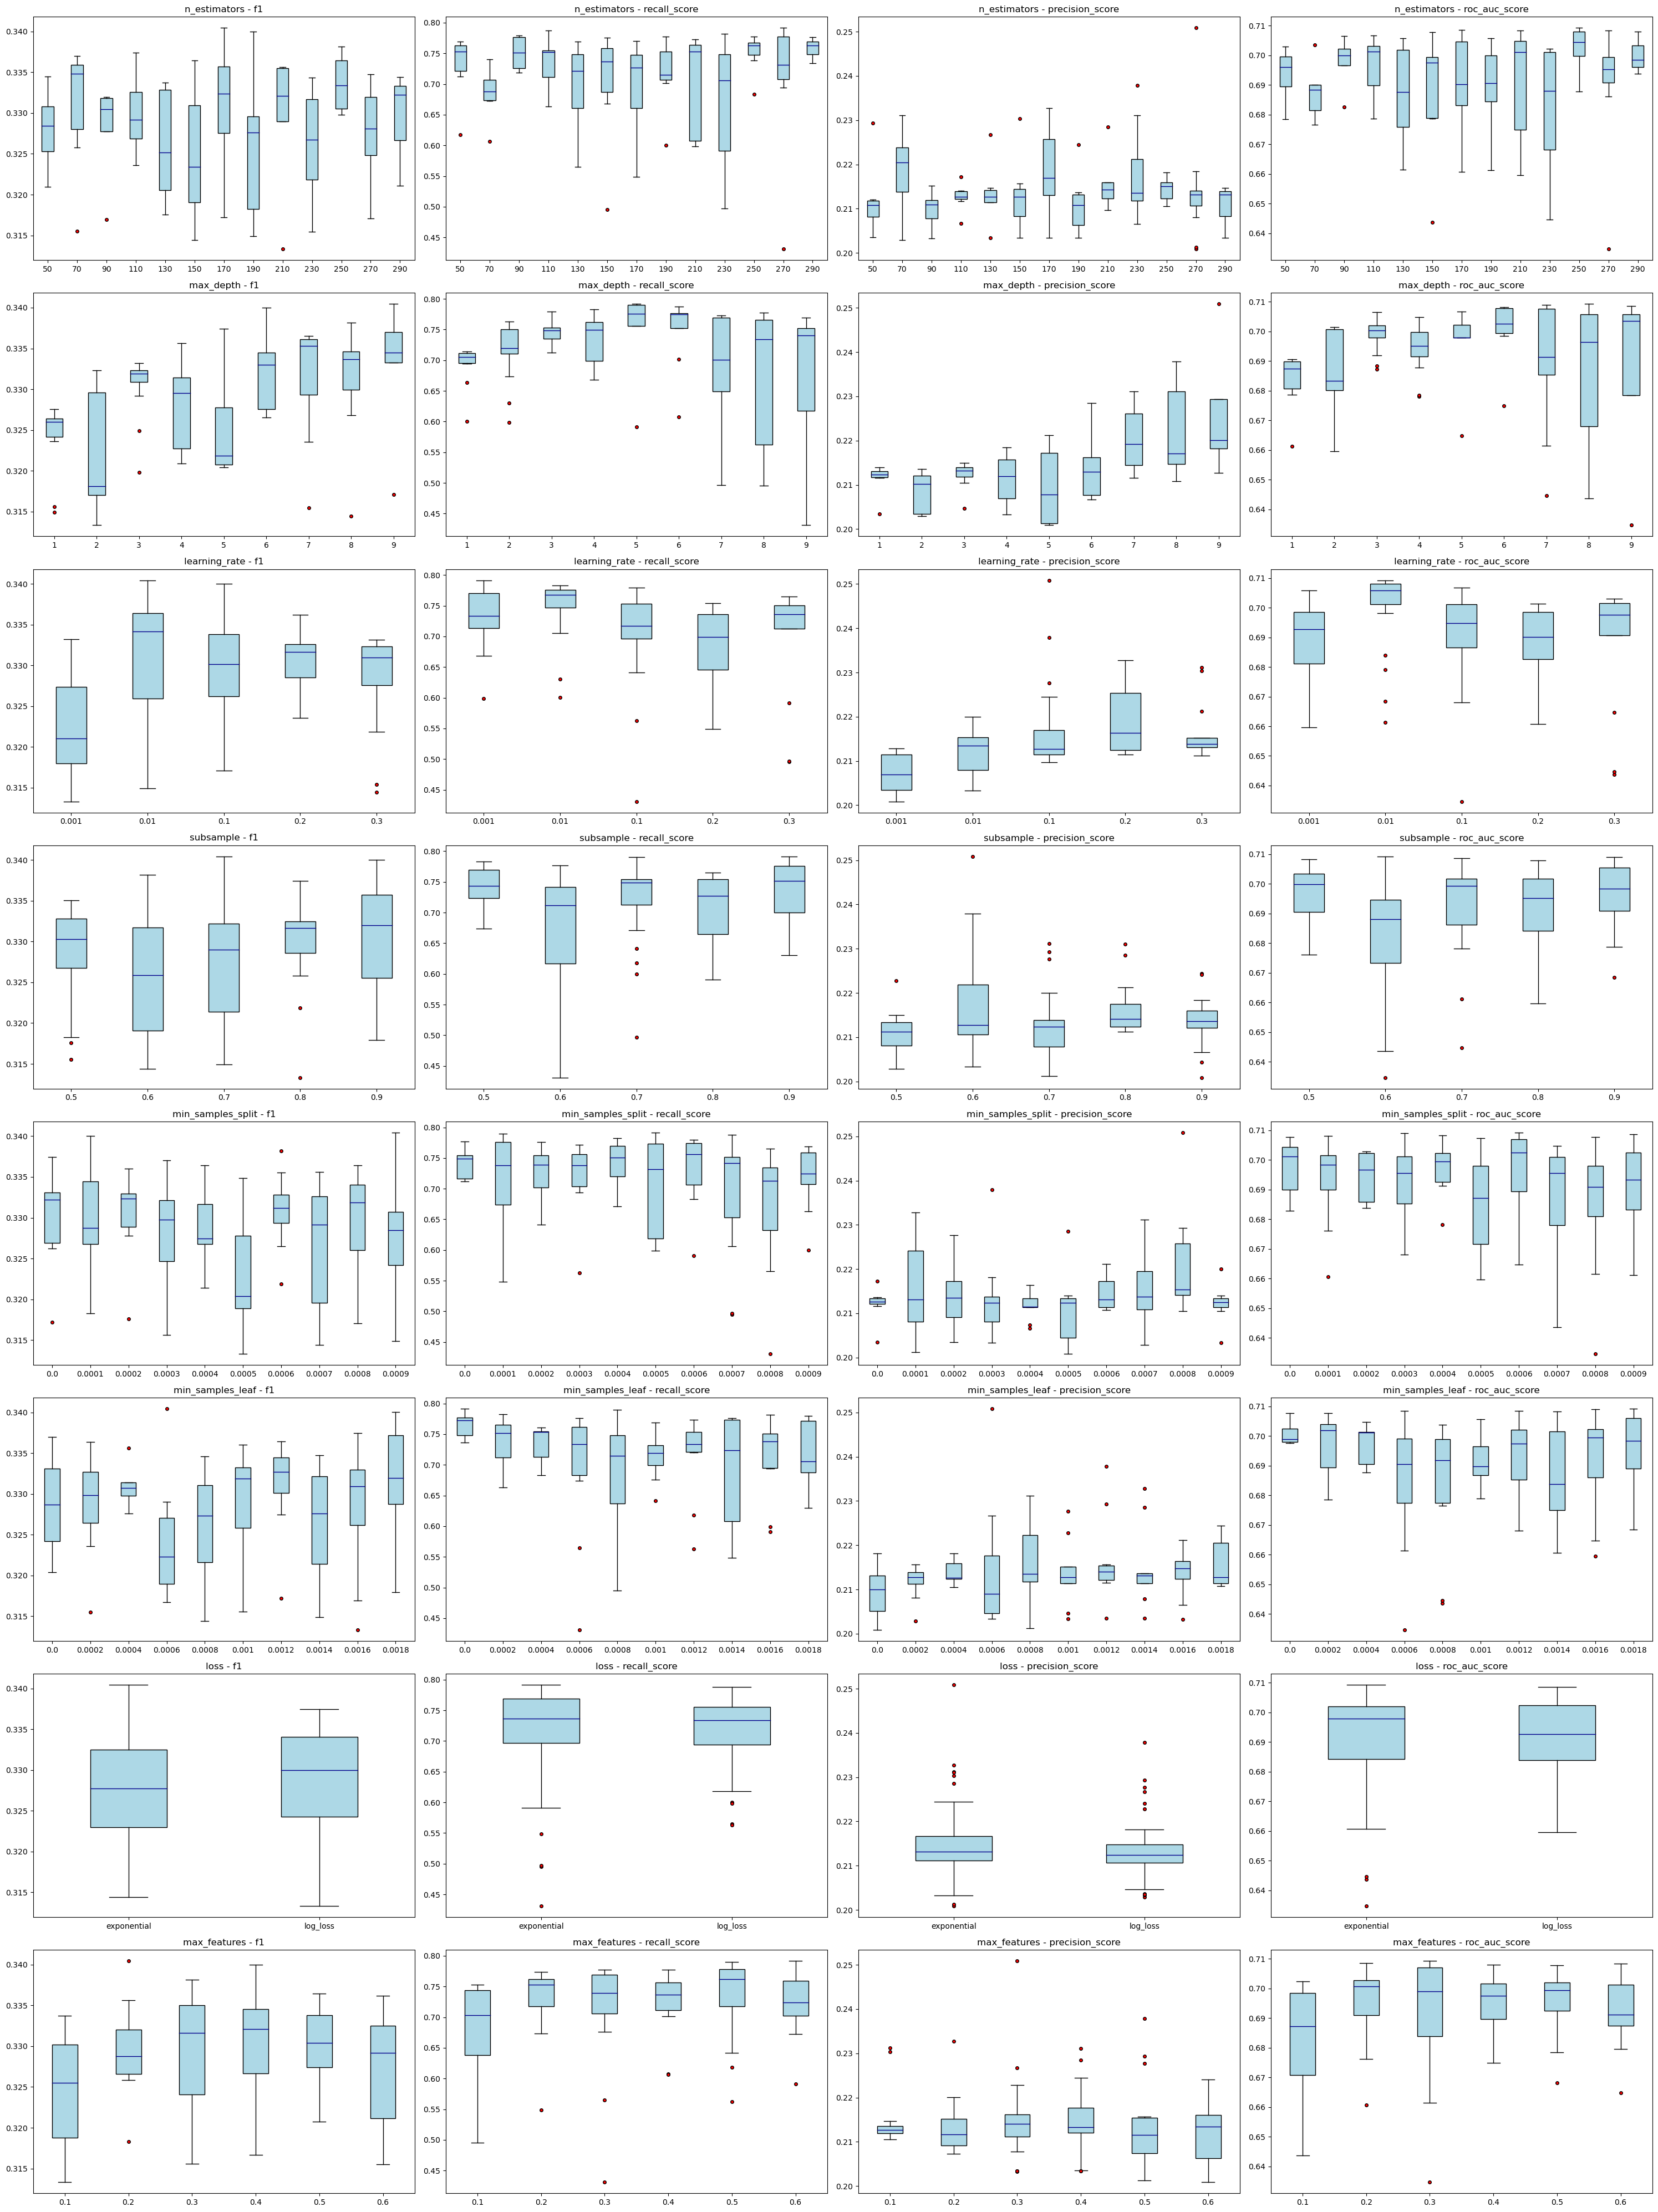

In [223]:
num_best_models = 90

best_models = sorted(gb_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

plot_metrics(gb_result, gb_params, best_models, figsize_param = (30,40))

In [224]:
best_gb = sorted(gb_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(GradientBoostingClassifier(**best_gb[0])))
print('F1: {}'.format(round(best_gb[1]['f1'][1],4)))

Best Model: GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7)
F1: 0.3404


#### Adaboost

In [234]:
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(random_state = random_state, estimator = DecisionTreeClassifier())


adaboost_params = {
    'n_estimators': np.arange(50, 200, 10),
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
    'estimator__max_depth': np.arange(1, 10, 1),  # Adjust based on your base estimator
    'estimator__min_samples_split': np.arange(0.0002, 0.001, 0.0001),  # Adjust based on your base estimator
    'estimator__min_samples_leaf': np.arange(0.0002, 0.001, 0.0001),  # Adjust based on your base estimator
}


adaboost_upsample_params = []
adaboost_result = []
for i in tqdm(range(30)):
    random_params = {}
    for key, values in adaboost_params.items():
        random_params[key] = random.choice(values)
        
    upsample = random.choice([True,False])
    if upsample == True:
       upsample_type = random.choice(['simple', 'SMOTE'])
    else:
       upsample_type = None
    adaboost_upsample_params.append([upsample, upsample_type])
    print(upsample, upsample_type)
    adaboost_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     scaling = False,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = upsample, 
                     upsample_type = upsample_type,
                     cv=5))
   

  0%|                                                    | 0/30 [00:00<?, ?it/s]

False None


  3%|█▍                                          | 1/30 [00:46<22:36, 46.77s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0004000000000000001),
                   learning_rate=0.01, n_estimators=60, random_state=42)
F1 train: 0.064, F1_val: 0.015
False None


  7%|██▉                                         | 2/30 [01:59<28:59, 62.11s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0009000000000000002),
                   learning_rate=1, n_estimators=90, random_state=42)
F1 train: 0.990, F1_val: 0.176
True SMOTE


 10%|████▍                                       | 3/30 [03:56<39:16, 87.27s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0004000000000000001),
                   learning_rate=0.001, n_estimators=130, random_state=42)
F1 train: 0.776, F1_val: 0.224
False None


 13%|█████▊                                      | 4/30 [05:02<34:05, 78.69s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=6,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0007000000000000001),
                   learning_rate=0.5, n_estimators=110, random_state=42)
F1 train: 0.139, F1_val: 0.078
True simple


 17%|███████▎                                    | 5/30 [06:25<33:27, 80.30s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, n_estimators=140, random_state=42)
F1 train: 0.697, F1_val: 0.329
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|████████▊                                   | 6/30 [07:25<29:24, 73.52s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=6,
                                                    min_samples_leaf=0.0008000000000000001,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.001, n_estimators=100, random_state=42)
F1 train: 0.048, F1_val: 0.005
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0004000000000000001),
                   learning_rate=0.1, n_estimators=100, random_state=42)
F1 train: 0.021, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 27%|███████████▋                                | 8/30 [09:14<24:13, 66.05s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=6,
                                                    min_samples_leaf=0.0008000000000000001,
                                                    min_samples_split=0.0009000000000000002),
                   learning_rate=0.01, n_estimators=140, random_state=42)
F1 train: 0.040, F1_val: 0.003
False None


 30%|█████████████▏                              | 9/30 [10:26<23:42, 67.75s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=9,
                                                    min_samples_leaf=0.0009000000000000002,
                                                    min_samples_split=0.0005),
                   learning_rate=0.1, n_estimators=80, random_state=42)
F1 train: 0.346, F1_val: 0.047
False None


 33%|██████████████▎                            | 10/30 [12:03<25:37, 76.88s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=7,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0007000000000000001),
                   learning_rate=0.1, n_estimators=140, random_state=42)
F1 train: 0.118, F1_val: 0.050
True SMOTE


 37%|███████████████▍                          | 11/30 [15:25<36:26, 115.06s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0002),
                   learning_rate=0.5, n_estimators=160, random_state=42)
F1 train: 0.945, F1_val: 0.199
True SMOTE


 40%|████████████████▊                         | 12/30 [18:58<43:26, 144.79s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0009000000000000002),
                   learning_rate=0.001, n_estimators=170, random_state=42)
F1 train: 0.811, F1_val: 0.212
False None


 43%|██████████████████▏                       | 13/30 [19:33<31:38, 111.69s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.1, n_estimators=80, random_state=42)
F1 train: 0.051, F1_val: 0.021
False None


 47%|████████████████████                       | 14/30 [19:58<22:47, 85.46s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, n_estimators=100, random_state=42)
F1 train: 0.060, F1_val: 0.022
True simple


 50%|█████████████████████                     | 15/30 [22:49<27:46, 111.11s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.001, n_estimators=120, random_state=42)
F1 train: 0.720, F1_val: 0.326
False None


 53%|██████████████████████▍                   | 16/30 [24:21<24:34, 105.35s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=9,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=100, random_state=42)
F1 train: 1.000, F1_val: 0.139
True simple


 57%|███████████████████████▊                  | 17/30 [25:49<21:42, 100.16s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0008000000000000001),
                   learning_rate=1, n_estimators=60, random_state=42)
F1 train: 0.865, F1_val: 0.281
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 60%|█████████████████████████▊                 | 18/30 [26:16<15:39, 78.33s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0004000000000000001),
                   learning_rate=0.5, n_estimators=120, random_state=42)
F1 train: 0.046, F1_val: 0.005
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0005),
                   learning_rate=0.001, n_estimators=110, random_state=42)
F1 train: 0.028, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.01, n_estimators=90, random_state=42)
F1 train: 0.023, F1_val: 0.000
False None


 70%|██████████████████████████████             | 21/30 [28:20<07:39, 51.04s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0009000000000000002,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.5, n_estimators=80, random_state=42)
F1 train: 0.052, F1_val: 0.014
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0007000000000000001),
                   learning_rate=0.001, n_estimators=100, random_state=42)
F1 train: 0.019, F1_val: 0.000
False None


 77%|████████████████████████████████▉          | 23/30 [30:06<06:09, 52.84s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=9,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0007000000000000001),
                   learning_rate=0.5, n_estimators=70, random_state=42)
F1 train: 0.288, F1_val: 0.121
True simple


 80%|██████████████████████████████████▍        | 24/30 [30:34<04:32, 45.47s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.01, n_estimators=60, random_state=42)
F1 train: 0.672, F1_val: 0.320
True SMOTE


 83%|███████████████████████████████████▊       | 25/30 [32:02<04:50, 58.15s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0009000000000000002,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.001, n_estimators=110, random_state=42)
F1 train: 0.743, F1_val: 0.233
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0007000000000000001,
                                                    min_samples_split=0.0009000000000000002),
                   learning_rate=0.01, n_estimators=100, random_state=42)
F1 train: 0.009, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0009000000000000002,
                                                    min_samples_split=0.0005),
                   learning_rate=0.1, n_estimators=110, random_state=42)
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0005),
                   learning_rate=1, random_state=42)
F1 train: 0.001, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 97%|█████████████████████████████████████████▌ | 29/30 [34:53<00:54, 54.02s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=7,
                                                    min_samples_leaf=0.0008000000000000001,
                                                    min_samples_split=0.0009000000000000002),
                   learning_rate=0.01, n_estimators=150, random_state=42)
F1 train: 0.052, F1_val: 0.002
True SMOTE


100%|███████████████████████████████████████████| 30/30 [36:19<00:00, 72.66s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0002),
                   learning_rate=0.01, n_estimators=150, random_state=42)
F1 train: 0.809, F1_val: 0.217


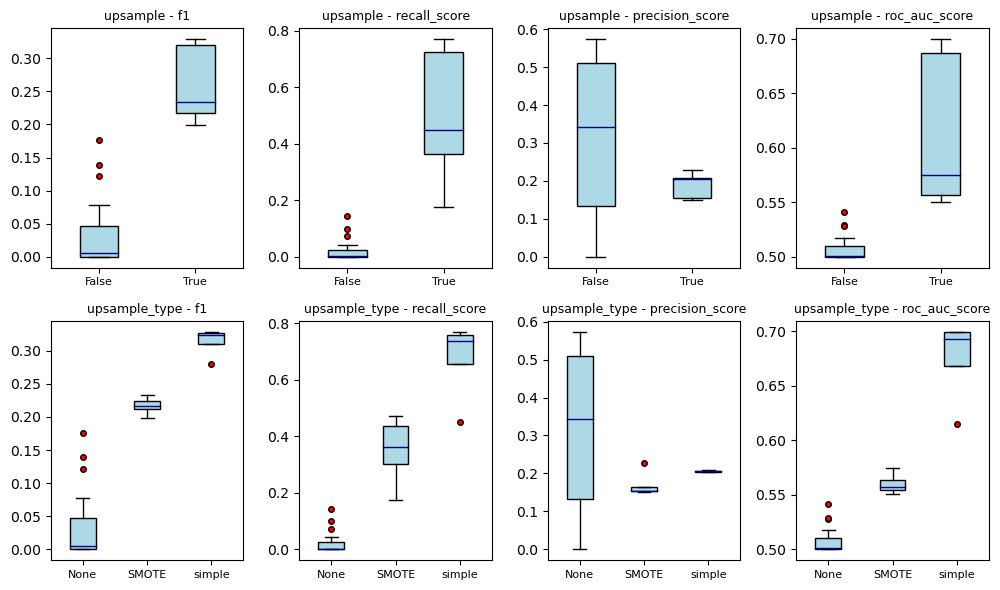

In [235]:
upsample_list = ['upsample', 'upsample_type']

fig,ax = plt.subplots(ncols = len(adaboost_result[0][1]), nrows = len(upsample_list), figsize = (10,6))
    
for m in range(len(adaboost_result[0][1])):
    for key in range(len(upsample_list)):
        hyperparam = upsample_list[key]
        metric = list(adaboost_result[0][1].keys())[m]
        hyperparam_df = pd.DataFrame(list(zip([i[key] for i in adaboost_upsample_params], [( adaboost_result[i][1][metric][1]) for i in range(len(adaboost_result))])),
                                     columns = ['hyperparameter', metric]).fillna('None')
        if hyperparam_df['hyperparameter'].dtype == 'O':
            hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
        hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
        
        ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
        labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
        patch_artist=True,
        widths=0.4,         
        medianprops=dict(color='darkblue'),
        boxprops=dict(facecolor='lightblue', edgecolor='black'),
         whiskerprops=dict(color='black'), 
         capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
                          ) 
        ax[key, m].tick_params(axis='x', labelsize=8)
        ax[key, m].set_title(hyperparam + ' - ' + metric, fontsize=9)

        ax[key, m].xaxis.grid(False)
        ax[key, m].yaxis.grid(False)
plt.tight_layout()
plt.savefig('Images/adaboost_upsample_results.png')
plt.show()

In [236]:
#simple upsampling is the best approach here

model = AdaBoostClassifier(random_state = random_state, estimator = DecisionTreeClassifier())


adaboost_params = {
    'n_estimators': np.arange(10, 200, 20),
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
    'estimator__max_depth': np.arange(1, 5, 1),  # Adjust based on your base estimator
    'estimator__min_samples_split': np.arange(0.0001, 0.001, 0.0001),  # Adjust based on your base estimator
    'estimator__min_samples_leaf': np.arange(0.0001, 0.001, 0.0001),  # Adjust based on your base estimator
}


adaboost_result = []
for i in tqdm(range(100)):
    random_params = {}
    for key, values in adaboost_params.items():
        random_params[key] = random.choice(values)
        
    adaboost_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     scaling = False,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = True, 
                     upsample_type = 'simple',
                     cv=5))

  1%|▍                                          | 1/100 [00:22<36:36, 22.19s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0005),
                   learning_rate=0.1, random_state=42)
F1 train: 0.684, F1_val: 0.318


  2%|▊                                          | 2/100 [00:35<27:48, 17.02s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0004),
                   learning_rate=0.001, random_state=42)
F1 train: 0.661, F1_val: 0.316


  3%|█▎                                         | 3/100 [00:53<28:08, 17.41s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0002),
                   learning_rate=0.5, n_estimators=70, random_state=42)
F1 train: 0.674, F1_val: 0.319


  4%|█▋                                       | 4/100 [02:41<1:24:55, 53.07s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0007),
                   learning_rate=1, n_estimators=170, random_state=42)
F1 train: 0.752, F1_val: 0.318


  5%|██                                       | 5/100 [03:13<1:12:12, 45.61s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=1, n_estimators=70, random_state=42)
F1 train: 0.708, F1_val: 0.327


  6%|██▍                                      | 6/100 [03:44<1:03:41, 40.65s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=0.01, random_state=42)
F1 train: 0.689, F1_val: 0.315


  7%|██▊                                      | 7/100 [05:11<1:26:37, 55.89s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=190, random_state=42)
F1 train: 0.706, F1_val: 0.327


  8%|███▎                                     | 8/100 [06:07<1:25:34, 55.81s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0008),
                   learning_rate=0.5, n_estimators=130, random_state=42)
F1 train: 0.698, F1_val: 0.320


  9%|███▋                                     | 9/100 [06:48<1:17:39, 51.20s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0008),
                   learning_rate=0.5, random_state=42)
F1 train: 0.737, F1_val: 0.328


 10%|████                                    | 10/100 [08:48<1:48:43, 72.49s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0001),
                   learning_rate=1, n_estimators=190, random_state=42)
F1 train: 0.758, F1_val: 0.313


 11%|████▍                                   | 11/100 [09:24<1:31:00, 61.36s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=130, random_state=42)
F1 train: 0.676, F1_val: 0.325


 12%|████▊                                   | 12/100 [11:19<1:53:35, 77.45s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=190, random_state=42)
F1 train: 0.699, F1_val: 0.325


 13%|█████▏                                  | 13/100 [11:22<1:19:53, 55.10s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0008),
                   learning_rate=1, n_estimators=10, random_state=42)
F1 train: 0.678, F1_val: 0.322


 14%|█████▌                                  | 14/100 [12:04<1:13:19, 51.16s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=170, random_state=42)
F1 train: 0.662, F1_val: 0.316


 15%|██████                                  | 15/100 [13:27<1:25:46, 60.55s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.01, n_estimators=190, random_state=42)
F1 train: 0.681, F1_val: 0.317


 16%|██████▍                                 | 16/100 [13:47<1:07:38, 48.31s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=30, random_state=42)
F1 train: 0.718, F1_val: 0.329


 17%|███████▏                                  | 17/100 [13:50<48:17, 34.90s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0008),
                   learning_rate=1, n_estimators=10, random_state=42)
F1 train: 0.678, F1_val: 0.322


 18%|███████▏                                | 18/100 [15:11<1:06:37, 48.75s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.1, n_estimators=190, random_state=42)
F1 train: 0.690, F1_val: 0.322


 19%|███████▌                                | 19/100 [15:49<1:01:26, 45.52s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0008),
                   learning_rate=0.01, n_estimators=150, random_state=42)
F1 train: 0.661, F1_val: 0.316


 20%|████████                                | 20/100 [17:12<1:15:28, 56.61s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0008),
                   learning_rate=0.001, n_estimators=190, random_state=42)
F1 train: 0.682, F1_val: 0.311


 21%|████████▍                               | 21/100 [19:29<1:46:30, 80.89s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=170, random_state=42)
F1 train: 0.792, F1_val: 0.317


 22%|████████▊                               | 22/100 [21:31<2:01:10, 93.21s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0004),
                   learning_rate=1, n_estimators=150, random_state=42)
F1 train: 0.799, F1_val: 0.299


 23%|█████████▏                              | 23/100 [21:46<1:29:20, 69.61s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0002),
                   learning_rate=0.5, random_state=42)
F1 train: 0.678, F1_val: 0.328


 24%|█████████▌                              | 24/100 [22:27<1:17:22, 61.09s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, random_state=42)
F1 train: 0.737, F1_val: 0.328


 25%|██████████                              | 25/100 [24:09<1:31:39, 73.32s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0002),
                   learning_rate=1, n_estimators=170, random_state=42)
F1 train: 0.699, F1_val: 0.327


 26%|██████████▍                             | 26/100 [24:51<1:18:47, 63.89s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=170, random_state=42)
F1 train: 0.677, F1_val: 0.321


 27%|██████████▊                             | 27/100 [25:36<1:10:52, 58.25s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0007),
                   learning_rate=0.01, n_estimators=70, random_state=42)
F1 train: 0.691, F1_val: 0.322


 28%|███████████▊                              | 28/100 [25:56<56:09, 46.79s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=70, random_state=42)
F1 train: 0.679, F1_val: 0.326


 29%|████████████▏                             | 29/100 [26:03<41:19, 34.93s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, n_estimators=10, random_state=42)
F1 train: 0.711, F1_val: 0.326


 30%|████████████                            | 30/100 [28:05<1:11:17, 61.10s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0004),
                   learning_rate=1, n_estimators=150, random_state=42)
F1 train: 0.798, F1_val: 0.304


 31%|████████████▍                           | 31/100 [29:13<1:12:24, 62.96s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0005),
                   learning_rate=0.01, n_estimators=110, random_state=42)
F1 train: 0.694, F1_val: 0.317


 32%|█████████████▍                            | 32/100 [29:35<57:27, 50.70s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, random_state=42)
F1 train: 0.684, F1_val: 0.318


 33%|█████████████▊                            | 33/100 [29:38<40:52, 36.60s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0008),
                   learning_rate=0.1, n_estimators=10, random_state=42)
F1 train: 0.661, F1_val: 0.316


 34%|█████████████▌                          | 34/100 [31:35<1:06:48, 60.73s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0008),
                   learning_rate=0.001, n_estimators=150, random_state=42)
F1 train: 0.704, F1_val: 0.316


 35%|██████████████                          | 35/100 [32:44<1:08:23, 63.13s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0007),
                   learning_rate=0.1, n_estimators=150, random_state=42)
F1 train: 0.703, F1_val: 0.325


 36%|███████████████                           | 36/100 [33:09<55:08, 51.69s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0002),
                   learning_rate=0.1, n_estimators=30, random_state=42)
F1 train: 0.714, F1_val: 0.331


 37%|██████████████▊                         | 37/100 [34:28<1:02:53, 59.90s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0005),
                   learning_rate=0.001, n_estimators=130, random_state=42)
F1 train: 0.686, F1_val: 0.315


 38%|███████████████▏                        | 38/100 [36:40<1:24:18, 81.60s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.001, n_estimators=170, random_state=42)
F1 train: 0.704, F1_val: 0.316


 39%|███████████████▌                        | 39/100 [36:48<1:00:17, 59.30s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.01, n_estimators=10, random_state=42)
F1 train: 0.691, F1_val: 0.317


 40%|████████████████▊                         | 40/100 [37:43<57:59, 57.99s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=0.001, n_estimators=90, random_state=42)
F1 train: 0.688, F1_val: 0.316


 41%|████████████████▍                       | 41/100 [38:55<1:01:17, 62.34s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.1, n_estimators=170, random_state=42)
F1 train: 0.690, F1_val: 0.321


 42%|█████████████████▋                        | 42/100 [39:17<48:32, 50.22s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.5, random_state=42)
F1 train: 0.697, F1_val: 0.319


 43%|█████████████████▏                      | 43/100 [41:18<1:07:45, 71.33s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.1, n_estimators=190, random_state=42)
F1 train: 0.722, F1_val: 0.333


 44%|█████████████████▌                      | 44/100 [42:10<1:01:17, 65.68s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.1, n_estimators=190, random_state=42)
F1 train: 0.677, F1_val: 0.326


 45%|██████████████████▉                       | 45/100 [42:34<48:45, 53.20s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=1, n_estimators=30, random_state=42)
F1 train: 0.704, F1_val: 0.325


 46%|██████████████████▍                     | 46/100 [44:16<1:00:56, 67.71s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.001, n_estimators=130, random_state=42)
F1 train: 0.704, F1_val: 0.316


 47%|███████████████████▋                      | 47/100 [44:46<49:56, 56.55s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=70, random_state=42)
F1 train: 0.685, F1_val: 0.318


 48%|████████████████████▏                     | 48/100 [45:33<46:25, 53.57s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.5, n_estimators=190, random_state=42)
F1 train: 0.673, F1_val: 0.323


 49%|████████████████████▌                     | 49/100 [46:43<49:52, 58.67s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=0.1, n_estimators=90, random_state=42)
F1 train: 0.710, F1_val: 0.328


 50%|█████████████████████                     | 50/100 [47:16<42:18, 50.77s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0002),
                   learning_rate=1, random_state=42)
F1 train: 0.720, F1_val: 0.327


 51%|█████████████████████▍                    | 51/100 [49:09<56:50, 69.59s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=1, n_estimators=190, random_state=42)
F1 train: 0.698, F1_val: 0.328


 52%|█████████████████████▊                    | 52/100 [50:00<51:13, 64.02s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.001, n_estimators=110, random_state=42)
F1 train: 0.676, F1_val: 0.316


 53%|██████████████████████▎                   | 53/100 [50:24<40:35, 51.82s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0002),
                   learning_rate=0.001, n_estimators=90, random_state=42)
F1 train: 0.661, F1_val: 0.316


 54%|██████████████████████▋                   | 54/100 [51:37<44:41, 58.30s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0005),
                   learning_rate=0.001, n_estimators=170, random_state=42)
F1 train: 0.682, F1_val: 0.311


 55%|███████████████████████                   | 55/100 [52:55<48:12, 64.27s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0005),
                   learning_rate=1, n_estimators=130, random_state=42)
F1 train: 0.699, F1_val: 0.327


 56%|███████████████████████▌                  | 56/100 [54:07<48:51, 66.63s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.5, n_estimators=170, random_state=42)
F1 train: 0.698, F1_val: 0.321


 57%|███████████████████████▉                  | 57/100 [55:16<48:17, 67.37s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0004),
                   learning_rate=0.01, n_estimators=150, random_state=42)
F1 train: 0.674, F1_val: 0.321


 58%|████████████████████████▎                 | 58/100 [55:53<40:37, 58.03s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0007),
                   learning_rate=0.1, n_estimators=130, random_state=42)
F1 train: 0.676, F1_val: 0.325


 59%|████████████████████████▊                 | 59/100 [57:38<49:25, 72.34s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, n_estimators=130, random_state=42)
F1 train: 0.770, F1_val: 0.323


 60%|█████████████████████████▏                | 60/100 [59:26<55:19, 82.99s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0005),
                   learning_rate=0.1, n_estimators=170, random_state=42)
F1 train: 0.721, F1_val: 0.332


 61%|█████████████████████████▌                | 61/100 [59:32<38:46, 59.66s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=1, n_estimators=10, random_state=42)
F1 train: 0.684, F1_val: 0.310


 62%|████████████████████████▊               | 62/100 [1:00:03<32:20, 51.06s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0002),
                   learning_rate=0.01, random_state=42)
F1 train: 0.689, F1_val: 0.315


 63%|█████████████████████████▏              | 63/100 [1:01:48<41:29, 67.27s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0005),
                   learning_rate=0.001, n_estimators=130, random_state=42)
F1 train: 0.707, F1_val: 0.316


 64%|█████████████████████████▌              | 64/100 [1:03:44<49:15, 82.08s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0004),
                   learning_rate=0.001, n_estimators=150, random_state=42)
F1 train: 0.704, F1_val: 0.316


 65%|██████████████████████████              | 65/100 [1:04:26<40:47, 69.93s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, n_estimators=170, random_state=42)
F1 train: 0.677, F1_val: 0.321


 66%|██████████████████████████▍             | 66/100 [1:04:40<30:12, 53.30s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0004),
                   learning_rate=1, n_estimators=30, random_state=42)
F1 train: 0.706, F1_val: 0.324


 67%|██████████████████████████▊             | 67/100 [1:06:52<42:12, 76.75s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=170, random_state=42)
F1 train: 0.711, F1_val: 0.330


 68%|███████████████████████████▏            | 68/100 [1:08:21<42:52, 80.39s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=0.001, n_estimators=110, random_state=42)
F1 train: 0.707, F1_val: 0.316


 69%|███████████████████████████▌            | 69/100 [1:08:26<29:55, 57.92s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0005),
                   learning_rate=1, n_estimators=10, random_state=42)
F1 train: 0.696, F1_val: 0.317


 70%|████████████████████████████            | 70/100 [1:09:46<32:18, 64.61s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=190, random_state=42)
F1 train: 0.698, F1_val: 0.322


 71%|████████████████████████████▍           | 71/100 [1:10:05<24:36, 50.93s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0002),
                   learning_rate=0.01, n_estimators=30, random_state=42)
F1 train: 0.686, F1_val: 0.315


 72%|████████████████████████████▊           | 72/100 [1:10:47<22:27, 48.12s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0001),
                   learning_rate=0.5, n_estimators=90, random_state=42)
F1 train: 0.713, F1_val: 0.332


 73%|█████████████████████████████▏          | 73/100 [1:12:10<26:19, 58.51s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.001, n_estimators=130, random_state=42)
F1 train: 0.694, F1_val: 0.317


 74%|█████████████████████████████▌          | 74/100 [1:12:42<21:56, 50.65s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0004),
                   learning_rate=1, n_estimators=130, random_state=42)
F1 train: 0.684, F1_val: 0.319


 75%|██████████████████████████████          | 75/100 [1:13:21<19:36, 47.04s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0005),
                   learning_rate=1, n_estimators=90, random_state=42)
F1 train: 0.686, F1_val: 0.314


 76%|██████████████████████████████▍         | 76/100 [1:14:07<18:46, 46.94s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0008),
                   learning_rate=1, n_estimators=170, random_state=42)
F1 train: 0.683, F1_val: 0.326


 77%|██████████████████████████████▊         | 77/100 [1:14:26<14:46, 38.55s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0004),
                   learning_rate=0.1, n_estimators=30, random_state=42)
F1 train: 0.703, F1_val: 0.319


 78%|███████████████████████████████▏        | 78/100 [1:14:35<10:48, 29.46s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0007),
                   learning_rate=1, n_estimators=30, random_state=42)
F1 train: 0.676, F1_val: 0.318


 79%|███████████████████████████████▌        | 79/100 [1:15:16<11:35, 33.12s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0001),
                   learning_rate=1, n_estimators=170, random_state=42)
F1 train: 0.678, F1_val: 0.321


 80%|████████████████████████████████        | 80/100 [1:16:14<13:28, 40.44s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0004),
                   learning_rate=0.01, n_estimators=90, random_state=42)
F1 train: 0.691, F1_val: 0.321


 81%|████████████████████████████████▍       | 81/100 [1:16:22<09:47, 30.92s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0001),
                   learning_rate=0.5, n_estimators=10, random_state=42)
F1 train: 0.709, F1_val: 0.325


 82%|████████████████████████████████▊       | 82/100 [1:16:41<08:09, 27.18s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.01, n_estimators=70, random_state=42)
F1 train: 0.661, F1_val: 0.316


 83%|█████████████████████████████████▏      | 83/100 [1:17:38<10:16, 36.25s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0008),
                   learning_rate=0.5, n_estimators=90, random_state=42)
F1 train: 0.731, F1_val: 0.329


 84%|█████████████████████████████████▌      | 84/100 [1:17:53<07:55, 29.72s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=1, random_state=42)
F1 train: 0.679, F1_val: 0.326


 85%|██████████████████████████████████      | 85/100 [1:19:01<10:20, 41.34s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0001),
                   learning_rate=1, n_estimators=150, random_state=42)
F1 train: 0.719, F1_val: 0.329


 86%|██████████████████████████████████▍     | 86/100 [1:20:12<11:41, 50.12s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0002),
                   learning_rate=0.1, n_estimators=90, random_state=42)
F1 train: 0.710, F1_val: 0.328


 87%|██████████████████████████████████▊     | 87/100 [1:21:30<12:40, 58.51s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0005),
                   learning_rate=0.1, n_estimators=170, random_state=42)
F1 train: 0.704, F1_val: 0.326


 88%|███████████████████████████████████▏    | 88/100 [1:21:56<09:44, 48.68s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=0.001, n_estimators=90, random_state=42)
F1 train: 0.661, F1_val: 0.316


 89%|███████████████████████████████████▌    | 89/100 [1:22:03<06:38, 36.25s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=10, random_state=42)
F1 train: 0.711, F1_val: 0.326


 90%|████████████████████████████████████    | 90/100 [1:22:45<06:18, 37.89s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0001),
                   learning_rate=0.01, n_estimators=90, random_state=42)
F1 train: 0.672, F1_val: 0.320


 91%|████████████████████████████████████▍   | 91/100 [1:23:02<04:46, 31.82s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=1, n_estimators=70, random_state=42)
F1 train: 0.684, F1_val: 0.319


 92%|████████████████████████████████████▊   | 92/100 [1:24:58<07:36, 57.11s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=0.5, n_estimators=150, random_state=42)
F1 train: 0.710, F1_val: 0.331


 93%|█████████████████████████████████████▏  | 93/100 [1:25:36<05:58, 51.16s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.1, n_estimators=150, random_state=42)
F1 train: 0.662, F1_val: 0.316


 94%|█████████████████████████████████████▌  | 94/100 [1:26:08<04:33, 45.52s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0007),
                   learning_rate=0.5, random_state=42)
F1 train: 0.722, F1_val: 0.331


 95%|██████████████████████████████████████  | 95/100 [1:27:07<04:08, 49.68s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0007),
                   learning_rate=1, n_estimators=130, random_state=42)
F1 train: 0.715, F1_val: 0.327


 96%|██████████████████████████████████████▍ | 96/100 [1:29:04<04:39, 69.78s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=150, random_state=42)
F1 train: 0.710, F1_val: 0.328


 97%|██████████████████████████████████████▊ | 97/100 [1:30:52<04:03, 81.29s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.01, n_estimators=170, random_state=42)
F1 train: 0.694, F1_val: 0.322


 98%|███████████████████████████████████████▏| 98/100 [1:31:16<02:08, 64.14s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=0.5, n_estimators=30, random_state=42)
F1 train: 0.709, F1_val: 0.329


 99%|███████████████████████████████████████▌| 99/100 [1:32:39<01:09, 69.57s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.001, n_estimators=190, random_state=42)
F1 train: 0.682, F1_val: 0.311


100%|███████████████████████████████████████| 100/100 [1:33:18<00:00, 55.99s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.5, random_state=42)
F1 train: 0.709, F1_val: 0.329


In [237]:
with open('Learning_results/adaboost_model_selection.pkl', 'wb') as file:
    pickle.dump(adaboost_result, file)

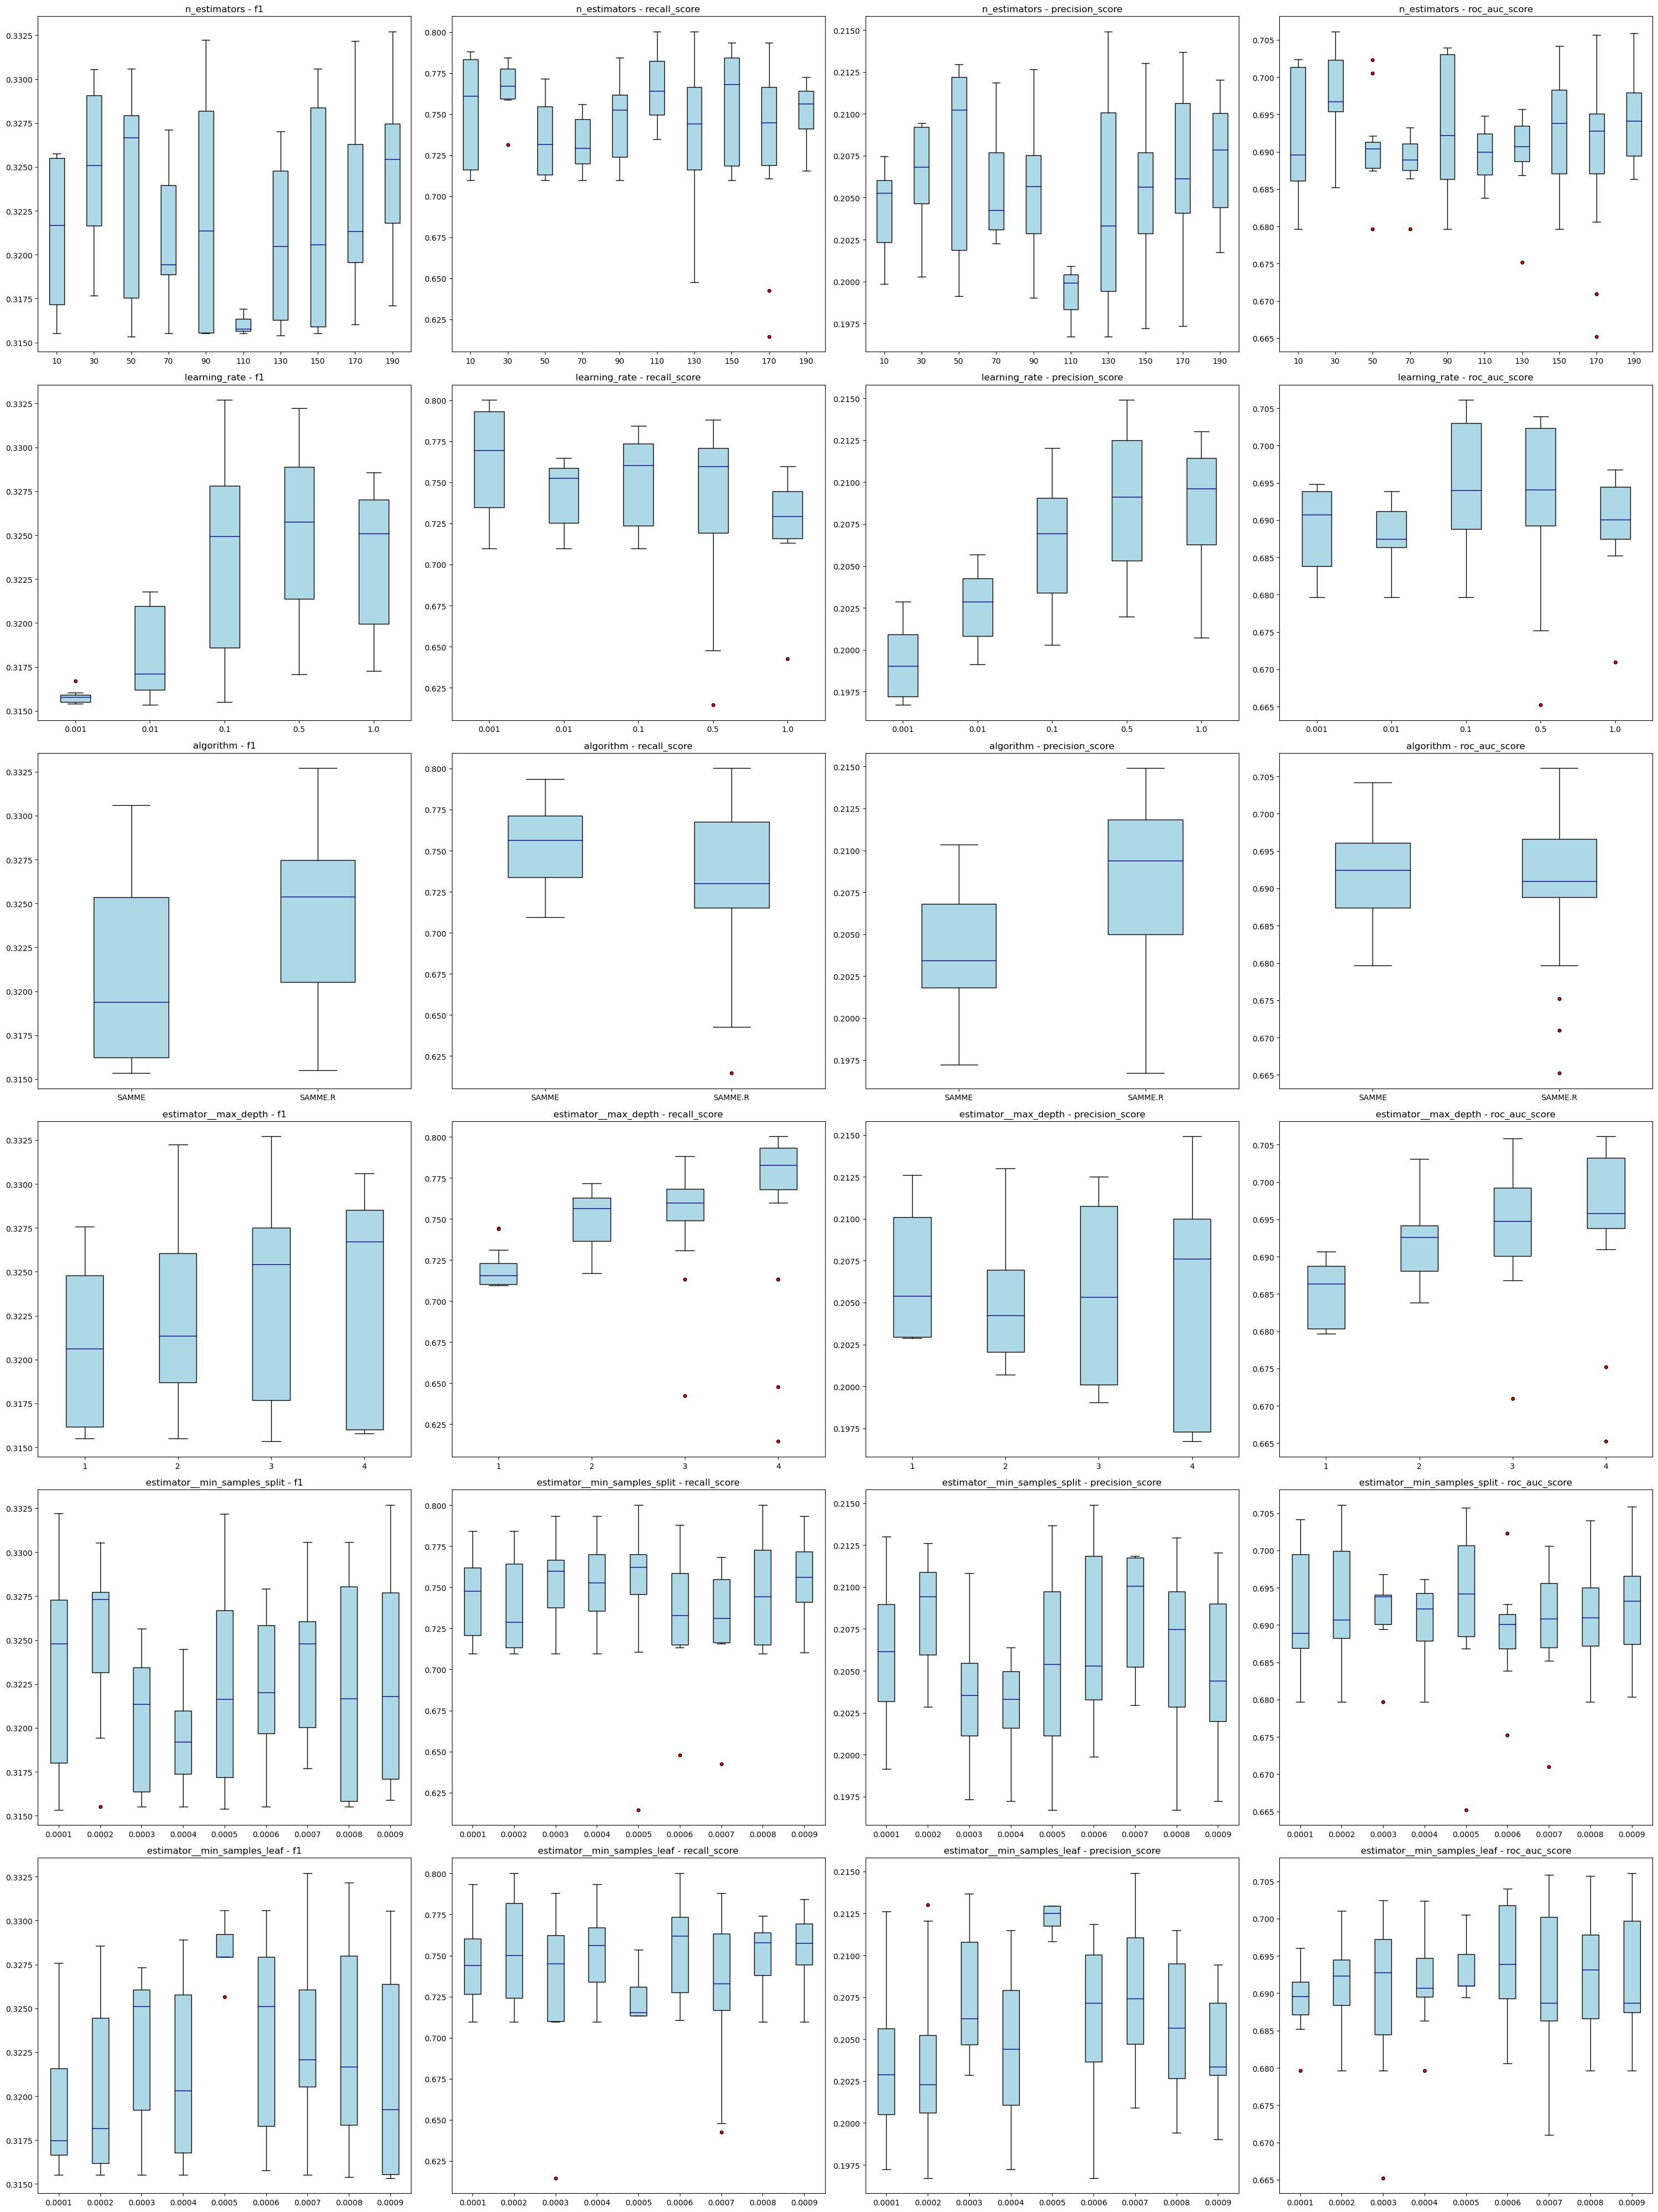

In [238]:
num_best_models = 90

best_models = sorted(adaboost_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

plot_metrics(adaboost_result, adaboost_params, best_models, figsize_param = (30,40))

In [239]:
best_adaboost = sorted(adaboost_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(best_adaboost[0]))
print('F1: {}'.format(round(best_adaboost[1]['f1'][1],4)))

Best Model: {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 0.0007, 'estimator__min_samples_split': 0.0009000000000000001, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.0004,
                       min_samples_split=0.0009000000000000001), 'learning_rate': 0.1, 'n_estimators': 190, 'random_state': 42}
F1: 0.3327


#### SGD

In [275]:
from sklearn.linear_model import SGDClassifier

###logloss optimization

model = SGDClassifier(max_iter=2000, tol=1e-4, class_weight = 'balanced')


sgd_log_params = {
    'alpha': np.arange(0.0001, 0.0011, 0.0001),
    'penalty': ['l2', 'l1'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01, 0.1, 0.5, 1.0],
    'loss': ['log_loss'],
    'epsilon': [0.01, 0.1, 0.2],
    'power_t': [0.1, 0.5, 1.0],
}

sgd_log_result = []
for i in tqdm(range(100)):
    random_params = {}
    for key, values in sgd_log_params.items():
        random_params[key] = random.choice(values)
        
    sgd_log_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = False, 
                     cv=5))

  1%|▍                                          | 1/100 [00:01<02:11,  1.32s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.231, F1_val: 0.223


  2%|▊                                          | 2/100 [00:12<11:11,  6.85s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=0.1, learning_rate='adaptive', loss='log_loss',
              max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.298, F1_val: 0.298


  3%|█▎                                         | 3/100 [00:17<10:05,  6.25s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', epsilon=0.2,
              eta0=0.01, learning_rate='adaptive', loss='log_loss',
              max_iter=2000, tol=0.0001)
F1 train: 0.281, F1_val: 0.274


  4%|█▋                                         | 4/100 [00:18<06:47,  4.25s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=0.5, learning_rate='constant', loss='log_loss',
              max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.184, F1_val: 0.182


  5%|██▏                                        | 5/100 [00:26<08:40,  5.47s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.262, F1_val: 0.251


  6%|██▌                                        | 6/100 [00:27<06:20,  4.05s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.212, F1_val: 0.199


  7%|███                                        | 7/100 [00:29<04:55,  3.18s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.01, learning_rate='constant',
              loss='log_loss', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.228, F1_val: 0.213


  8%|███▍                                       | 8/100 [00:35<06:16,  4.09s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.288, F1_val: 0.288


  9%|███▊                                       | 9/100 [00:42<07:41,  5.07s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.261, F1_val: 0.260


 10%|████▏                                     | 10/100 [00:43<05:53,  3.93s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.196, F1_val: 0.165


 11%|████▌                                     | 11/100 [00:54<08:45,  5.90s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.315, F1_val: 0.316


 12%|█████                                     | 12/100 [00:55<06:36,  4.50s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=1.0, learning_rate='constant', loss='log_loss',
              max_iter=2000, penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.212, F1_val: 0.195


 13%|█████▍                                    | 13/100 [01:04<08:29,  5.85s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.01, eta0=1.0,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.272, F1_val: 0.276


 14%|█████▉                                    | 14/100 [01:15<10:38,  7.42s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.2, eta0=0.1, learning_rate='adaptive', loss='log_loss',
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.310, F1_val: 0.311


 15%|██████▎                                   | 15/100 [01:17<08:14,  5.82s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.2, eta0=0.1,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.230, F1_val: 0.228


 16%|██████▋                                   | 16/100 [01:25<09:07,  6.51s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.01,
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.275, F1_val: 0.265


 17%|███████▏                                  | 17/100 [01:33<09:36,  6.95s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=1.0,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.312, F1_val: 0.322


 18%|███████▌                                  | 18/100 [01:37<08:05,  5.92s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', eta0=0.001,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.304, F1_val: 0.301


 19%|███████▉                                  | 19/100 [01:41<07:18,  5.41s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.309, F1_val: 0.305


 20%|████████▍                                 | 20/100 [01:51<09:04,  6.80s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', eta0=0.1,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.291, F1_val: 0.289


 21%|████████▊                                 | 21/100 [02:02<10:30,  7.98s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.299, F1_val: 0.303


 22%|█████████▏                                | 22/100 [02:05<08:36,  6.62s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.271, F1_val: 0.268


 23%|█████████▋                                | 23/100 [02:07<06:45,  5.26s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.279, F1_val: 0.268


 24%|██████████                                | 24/100 [02:16<08:06,  6.40s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.2, eta0=0.01,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.312, F1_val: 0.320


 25%|██████████▌                               | 25/100 [02:28<10:02,  8.03s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.2, eta0=0.1, learning_rate='adaptive', loss='log_loss',
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.311, F1_val: 0.313


 26%|██████████▉                               | 26/100 [02:30<07:48,  6.34s/it]

SGDClassifier(class_weight='balanced', eta0=0.01, learning_rate='invscaling',
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.248, F1_val: 0.238


 27%|███████████▎                              | 27/100 [02:38<08:13,  6.75s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', eta0=0.1, loss='log_loss',
              max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.243, F1_val: 0.217


 28%|███████████▊                              | 28/100 [02:40<06:19,  5.27s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.5, learning_rate='invscaling',
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.239, F1_val: 0.216


 29%|████████████▏                             | 29/100 [02:42<05:10,  4.38s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=0.1, learning_rate='invscaling',
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.239, F1_val: 0.219


 30%|████████████▌                             | 30/100 [02:49<06:03,  5.19s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.01,
              loss='log_loss', max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.313, F1_val: 0.310


 31%|█████████████                             | 31/100 [02:57<06:49,  5.93s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.01, eta0=0.001,
              loss='log_loss', max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.296, F1_val: 0.304


 32%|█████████████▍                            | 32/100 [02:58<05:08,  4.54s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.229, F1_val: 0.221


 33%|█████████████▊                            | 33/100 [03:07<06:31,  5.85s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.01,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.279, F1_val: 0.288


 34%|██████████████▎                           | 34/100 [03:18<07:54,  7.19s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', eta0=0.1,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.303, F1_val: 0.306


 35%|██████████████▋                           | 35/100 [03:23<07:17,  6.73s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.290, F1_val: 0.290


 36%|███████████████                           | 36/100 [03:24<05:26,  5.10s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.186, F1_val: 0.171


 37%|███████████████▌                          | 37/100 [03:34<06:47,  6.47s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=0.001, loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.264, F1_val: 0.245


 38%|███████████████▉                          | 38/100 [03:44<07:39,  7.42s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=1.0, loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.277, F1_val: 0.279


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 39%|████████████████▍                         | 39/100 [03:45<05:40,  5.59s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=0.5, learning_rate='constant', loss='log_loss',
              max_iter=2000, tol=0.0001)
F1 train: 0.158, F1_val: 0.156


 40%|████████████████▊                         | 40/100 [03:46<04:16,  4.28s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', eta0=1.0,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.259, F1_val: 0.253


 41%|█████████████████▏                        | 41/100 [03:48<03:20,  3.39s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.001, learning_rate='constant',
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.219, F1_val: 0.203


 42%|█████████████████▋                        | 42/100 [03:59<05:29,  5.68s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.312, F1_val: 0.313


 43%|██████████████████                        | 43/100 [04:00<04:10,  4.40s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.2, eta0=0.1, learning_rate='constant', loss='log_loss',
              max_iter=2000, penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.178, F1_val: 0.177


 44%|██████████████████▍                       | 44/100 [04:04<03:59,  4.28s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.313, F1_val: 0.303


 45%|██████████████████▉                       | 45/100 [04:15<05:38,  6.15s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.1, loss='log_loss',
              max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.165, F1_val: 0.176


 46%|███████████████████▎                      | 46/100 [04:24<06:27,  7.18s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.301, F1_val: 0.303


 47%|███████████████████▋                      | 47/100 [04:25<04:46,  5.40s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.1, learning_rate='invscaling',
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.214, F1_val: 0.172


 48%|████████████████████▏                     | 48/100 [04:32<04:58,  5.74s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=0.001, loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.268, F1_val: 0.276


 49%|████████████████████▌                     | 49/100 [04:35<04:13,  4.96s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=0.001,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.269, F1_val: 0.267


 50%|█████████████████████                     | 50/100 [04:38<03:38,  4.37s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', eta0=0.1,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.306, F1_val: 0.289


 51%|█████████████████████▍                    | 51/100 [04:41<03:09,  3.87s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.01,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.292, F1_val: 0.281


 52%|█████████████████████▊                    | 52/100 [04:46<03:19,  4.15s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.001,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.307, F1_val: 0.300


 53%|██████████████████████▎                   | 53/100 [04:54<04:14,  5.41s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.5, loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.245, F1_val: 0.239


 54%|██████████████████████▋                   | 54/100 [05:00<04:20,  5.67s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.262, F1_val: 0.248


 55%|███████████████████████                   | 55/100 [05:08<04:38,  6.19s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced', epsilon=0.2,
              eta0=1.0, loss='log_loss', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.263, F1_val: 0.266


 56%|███████████████████████▌                  | 56/100 [05:10<03:41,  5.02s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', eta0=0.5,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.156, F1_val: 0.147


 57%|███████████████████████▉                  | 57/100 [05:11<02:47,  3.90s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.220, F1_val: 0.217


 58%|████████████████████████▎                 | 58/100 [05:23<04:20,  6.21s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.01, eta0=0.01,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.301, F1_val: 0.309


 59%|████████████████████████▊                 | 59/100 [05:24<03:17,  4.82s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.285, F1_val: 0.259


 60%|█████████████████████████▏                | 60/100 [05:26<02:36,  3.91s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.263, F1_val: 0.259


 61%|█████████████████████████▌                | 61/100 [05:28<02:02,  3.15s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.210, F1_val: 0.152


 62%|██████████████████████████                | 62/100 [05:38<03:20,  5.28s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.5, learning_rate='adaptive', loss='log_loss',
              max_iter=2000, penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.311, F1_val: 0.313


 63%|██████████████████████████▍               | 63/100 [05:44<03:24,  5.54s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.244, F1_val: 0.242


 64%|██████████████████████████▉               | 64/100 [05:47<02:51,  4.76s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', eta0=0.5,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.253, F1_val: 0.251


 65%|███████████████████████████▎              | 65/100 [05:57<03:48,  6.52s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.312, F1_val: 0.312


 66%|███████████████████████████▋              | 66/100 [06:04<03:42,  6.53s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=0.01,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.318, F1_val: 0.320


 67%|████████████████████████████▏             | 67/100 [06:15<04:17,  7.80s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.312, F1_val: 0.313


 68%|████████████████████████████▌             | 68/100 [06:16<03:08,  5.89s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.196, F1_val: 0.183


 69%|████████████████████████████▉             | 69/100 [06:20<02:46,  5.35s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.254, F1_val: 0.252


 70%|█████████████████████████████▍            | 70/100 [06:32<03:33,  7.10s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.317, F1_val: 0.317


 71%|█████████████████████████████▊            | 71/100 [06:33<02:34,  5.33s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.216, F1_val: 0.196


 72%|██████████████████████████████▏           | 72/100 [06:43<03:12,  6.87s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced', eta0=0.5,
              loss='log_loss', max_iter=2000, tol=0.0001)
F1 train: 0.282, F1_val: 0.283


 73%|██████████████████████████████▋           | 73/100 [06:45<02:21,  5.24s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.2, eta0=0.01,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.211, F1_val: 0.207


 74%|███████████████████████████████           | 74/100 [06:55<02:56,  6.79s/it]

SGDClassifier(class_weight='balanced', eta0=1.0, loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.196, F1_val: 0.201


 75%|███████████████████████████████▌          | 75/100 [07:03<03:00,  7.21s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.01, eta0=0.5,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.280, F1_val: 0.281


 76%|███████████████████████████████▉          | 76/100 [07:05<02:11,  5.49s/it]

SGDClassifier(class_weight='balanced', eta0=0.001, learning_rate='constant',
              loss='log_loss', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.215, F1_val: 0.184


 77%|████████████████████████████████▎         | 77/100 [07:06<01:37,  4.23s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.201, F1_val: 0.158


 78%|████████████████████████████████▊         | 78/100 [07:16<02:12,  6.02s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.305, F1_val: 0.306


 79%|█████████████████████████████████▏        | 79/100 [07:26<02:27,  7.03s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.303, F1_val: 0.305


 80%|█████████████████████████████████▌        | 80/100 [07:27<01:45,  5.26s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.170, F1_val: 0.168


 81%|██████████████████████████████████        | 81/100 [07:28<01:17,  4.06s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', eta0=0.5,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.205, F1_val: 0.203


 82%|██████████████████████████████████▍       | 82/100 [07:29<00:57,  3.21s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.138, F1_val: 0.121


 83%|██████████████████████████████████▊       | 83/100 [07:33<00:56,  3.33s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.5, learning_rate='invscaling',
              loss='log_loss', max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.264, F1_val: 0.261


 84%|███████████████████████████████████▎      | 84/100 [07:45<01:34,  5.90s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', eta0=1.0,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.294, F1_val: 0.294


 85%|███████████████████████████████████▋      | 85/100 [07:46<01:07,  4.49s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.215, F1_val: 0.183


 86%|████████████████████████████████████      | 86/100 [07:55<01:23,  5.95s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.01,
              loss='log_loss', max_iter=2000, tol=0.0001)
F1 train: 0.216, F1_val: 0.210


 87%|████████████████████████████████████▌     | 87/100 [08:05<01:32,  7.09s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.1, loss='log_loss',
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.290, F1_val: 0.300


 88%|████████████████████████████████████▉     | 88/100 [08:13<01:27,  7.27s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.001,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.300, F1_val: 0.301


 89%|█████████████████████████████████████▍    | 89/100 [08:14<00:59,  5.45s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.143, F1_val: 0.144


 90%|█████████████████████████████████████▊    | 90/100 [08:22<01:03,  6.39s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced', epsilon=0.2,
              eta0=1.0, loss='log_loss', max_iter=2000, power_t=1.0,
              tol=0.0001)
F1 train: 0.278, F1_val: 0.266


 91%|██████████████████████████████████████▏   | 91/100 [08:25<00:47,  5.23s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', eta0=0.001,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.215, F1_val: 0.181


 92%|██████████████████████████████████████▋   | 92/100 [08:26<00:32,  4.00s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.212, F1_val: 0.207


 93%|███████████████████████████████████████   | 93/100 [08:35<00:37,  5.42s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', eta0=0.1,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.304, F1_val: 0.307


 94%|███████████████████████████████████████▍  | 94/100 [08:40<00:31,  5.32s/it]

SGDClassifier(class_weight='balanced', eta0=0.01, learning_rate='adaptive',
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.303, F1_val: 0.307


 95%|███████████████████████████████████████▉  | 95/100 [08:44<00:25,  5.07s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.309, F1_val: 0.306


 96%|████████████████████████████████████████▎ | 96/100 [08:46<00:15,  3.98s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', epsilon=0.2,
              eta0=0.001, learning_rate='constant', loss='log_loss',
              max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.230, F1_val: 0.229


 97%|████████████████████████████████████████▋ | 97/100 [08:47<00:09,  3.15s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.266, F1_val: 0.241


 98%|█████████████████████████████████████████▏| 98/100 [08:58<00:11,  5.51s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.256, F1_val: 0.251


 99%|█████████████████████████████████████████▌| 99/100 [09:05<00:05,  5.99s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=0.5,
              loss='log_loss', max_iter=2000, tol=0.0001)
F1 train: 0.267, F1_val: 0.242


100%|█████████████████████████████████████████| 100/100 [09:07<00:00,  5.47s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.224, F1_val: 0.194


In [281]:
with open('Learning_results/sgd_log_model_selection.pkl', 'wb') as file:
    pickle.dump(sgd_log_result, file)

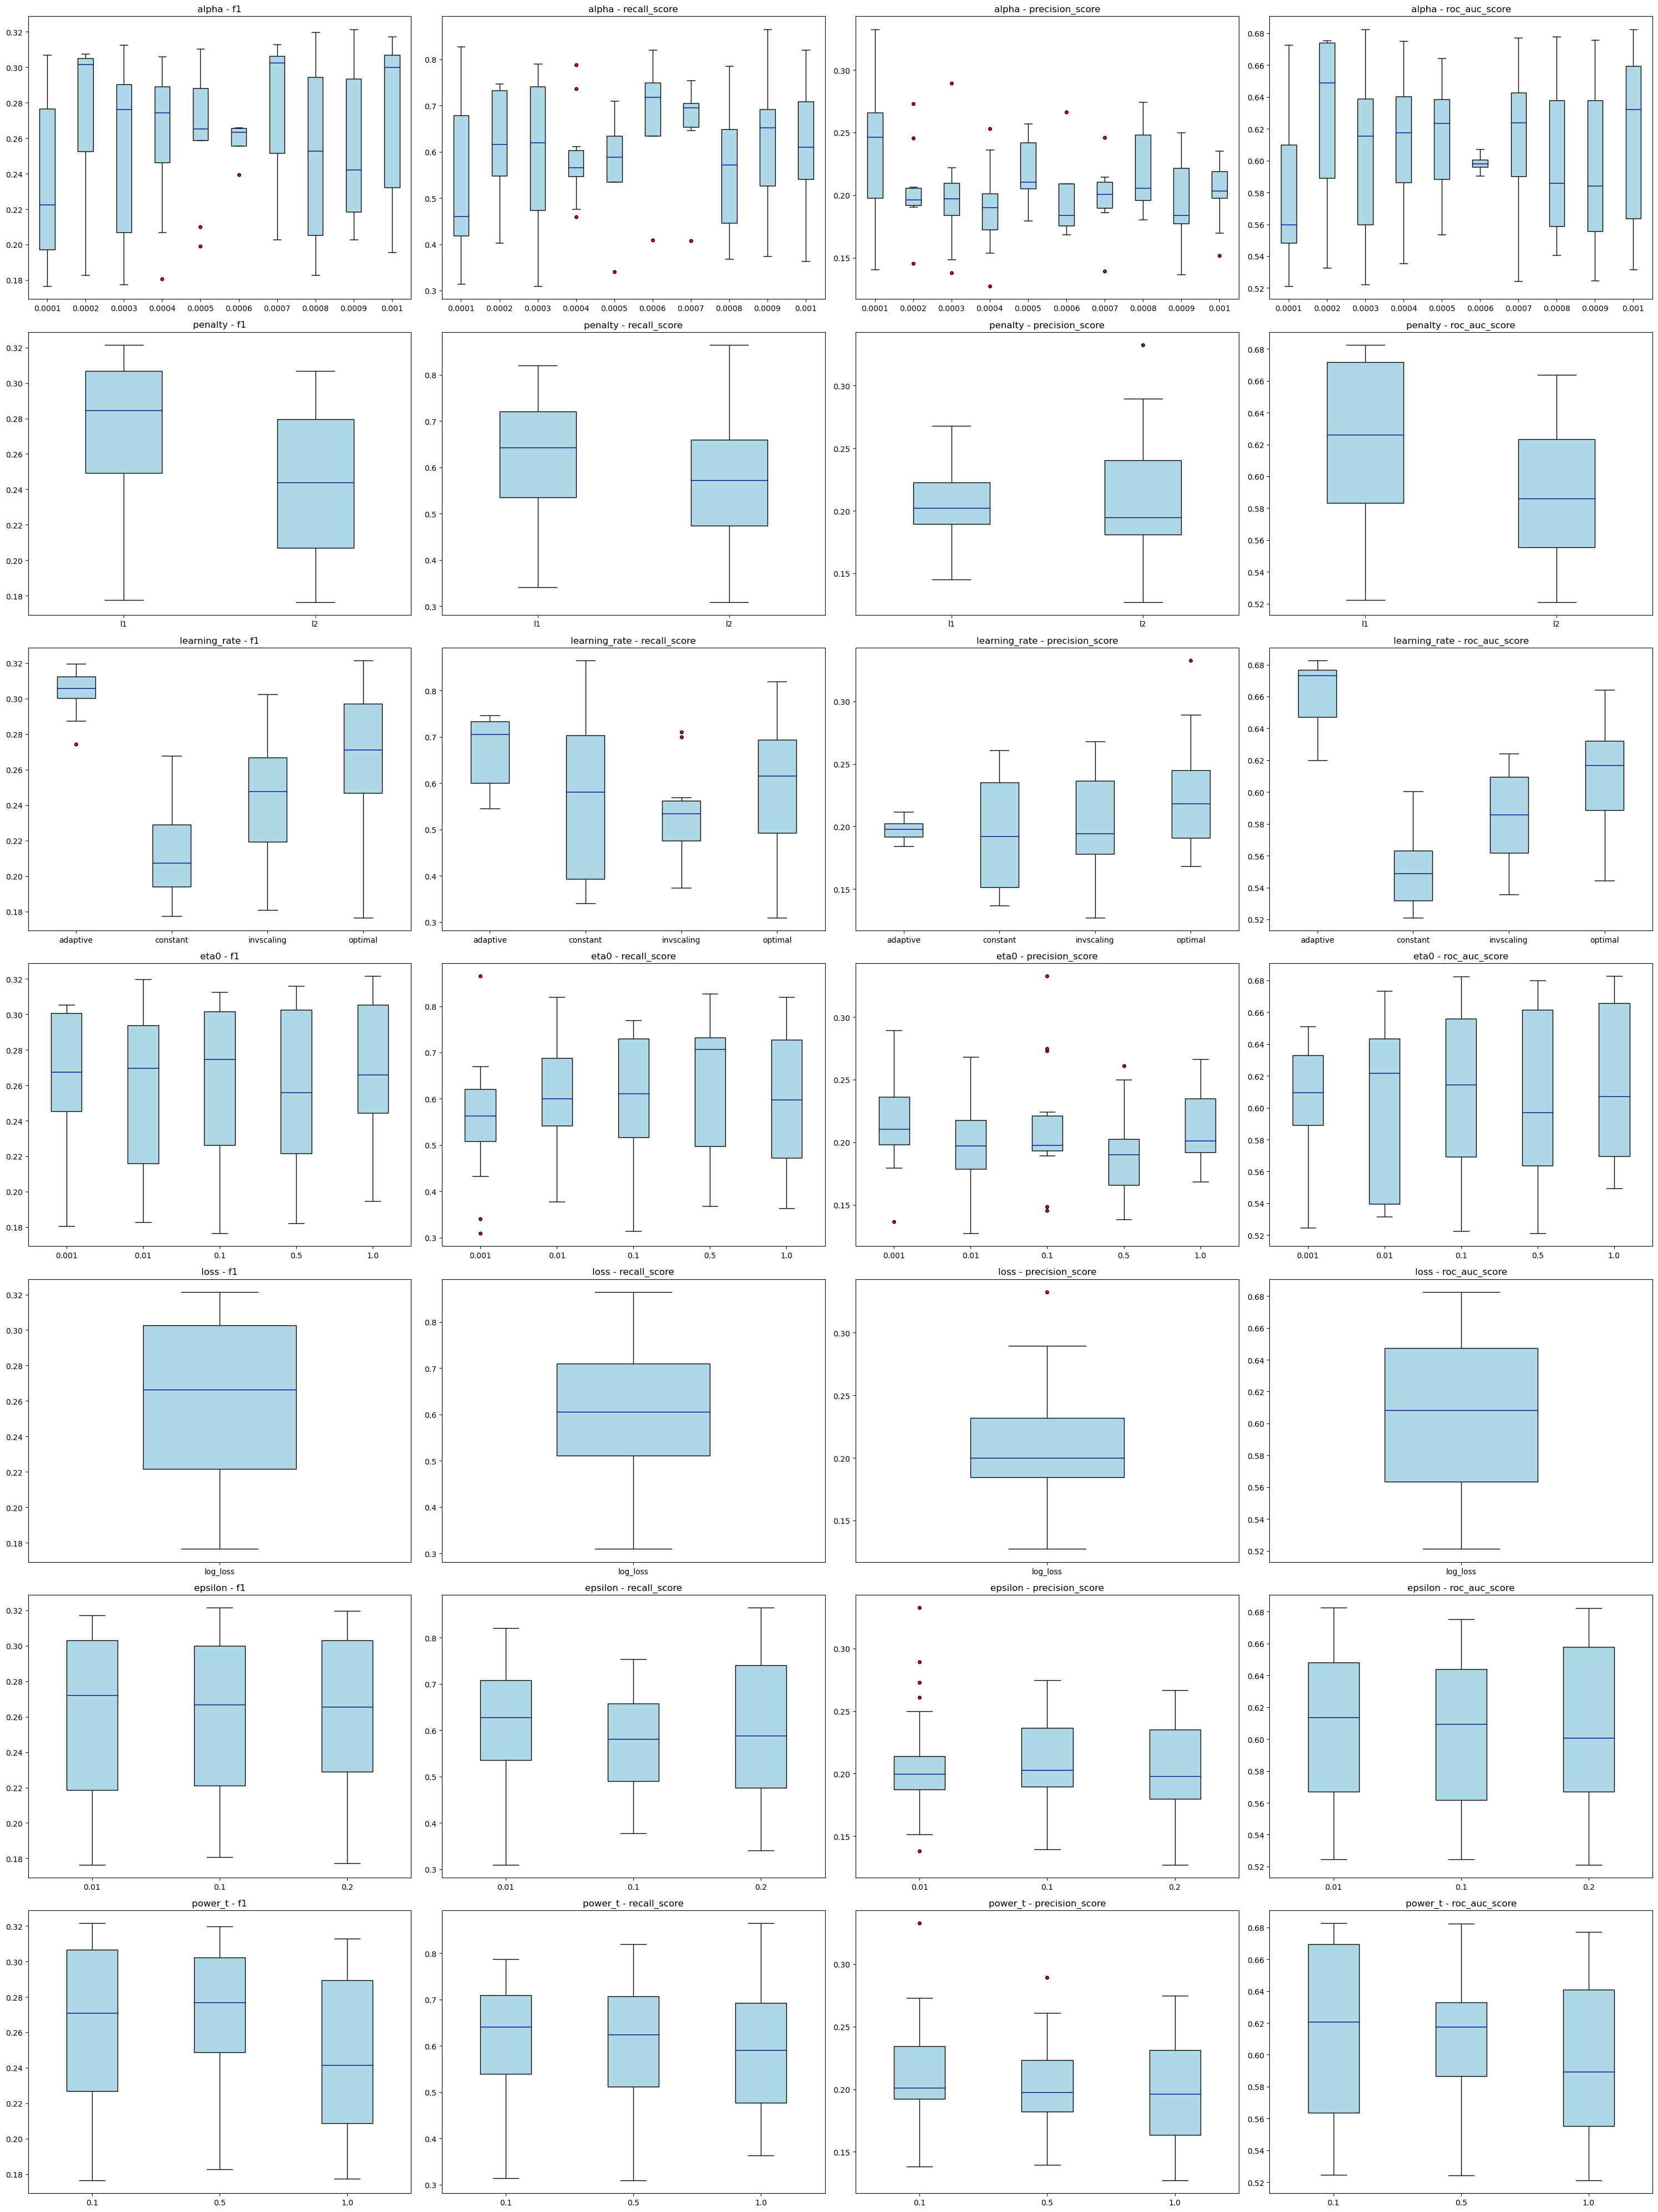

In [282]:
num_best_models = 90

best_models = sorted(sgd_log_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

plot_metrics(sgd_log_result, sgd_log_params, best_models, figsize_param = (30,40))

In [283]:
best_sgd_log = sorted(sgd_log_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(SGDClassifier(**best_sgd_log[0])))
print('F1: {}'.format(round(best_sgd_log[1]['f1'][1],4)))

Best Model: SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=1.0,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1: 0.3215


In [280]:
from sklearn.linear_model import SGDClassifier

###hinge loss (svm) optimization

model = SGDClassifier(max_iter=2000, tol=1e-4, class_weight = 'balanced', )


sgd_svm_params = {
    'alpha': [ 0.0001, 0.0005, 0.001, 0.01],
    'penalty': ['l2', 'l1'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01, 0.1, 0.5, 1.0],
    'loss': ['hinge', 'squared_hinge'],
    'epsilon': [0.01, 0.1, 0.2],
    'power_t': [0.1, 0.5, 1.0],
}

sgd_svm_result = []
for i in tqdm(range(100)):
    random_params = {}
    for key, values in sgd_svm_params.items():
        random_params[key] = random.choice(values)
        
    sgd_svm_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = False, 
                     cv=5))

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▍                                          | 1/100 [00:01<01:51,  1.12s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.1,
              learning_rate='constant', max_iter=2000, tol=0.0001)
F1 train: 0.091, F1_val: 0.090


  2%|▊                                          | 2/100 [00:02<02:05,  1.28s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.212, F1_val: 0.142


  3%|█▎                                         | 3/100 [00:04<02:18,  1.43s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='invscaling', max_iter=2000, penalty='l1',
              power_t=0.1, tol=0.0001)
F1 train: 0.249, F1_val: 0.243


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warning

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.001,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.249, F1_val: 0.261


  5%|██▏                                        | 5/100 [01:03<28:34, 18.05s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.305, F1_val: 0.321


  6%|██▌                                        | 6/100 [01:22<28:35, 18.25s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.306, F1_val: 0.320


  7%|███                                        | 7/100 [01:29<22:27, 14.48s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=1.0,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.295, F1_val: 0.299


  8%|███▍                                       | 8/100 [01:31<16:27, 10.73s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.001, max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.279, F1_val: 0.260


  9%|███▊                                       | 9/100 [01:33<11:43,  7.73s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='constant', max_iter=2000, tol=0.0001)
F1 train: 0.092, F1_val: 0.090


 10%|████▏                                     | 10/100 [01:42<12:17,  8.20s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.302, F1_val: 0.307


 11%|████▌                                     | 11/100 [01:43<08:53,  6.00s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='invscaling', max_iter=2000, power_t=1.0,
              tol=0.0001)
F1 train: 0.162, F1_val: 0.161


 12%|█████                                     | 12/100 [01:54<11:04,  7.56s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=1.0,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.273, F1_val: 0.281


 13%|█████▍                                    | 13/100 [01:59<09:53,  6.82s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.291, F1_val: 0.276


 14%|█████▉                                    | 14/100 [02:10<11:39,  8.13s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.1,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.287, F1_val: 0.288


 15%|██████▎                                   | 15/100 [02:11<08:29,  5.99s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='invscaling', max_iter=2000, power_t=1.0,
              tol=0.0001)
F1 train: 0.180, F1_val: 0.178


 16%|██████▋                                   | 16/100 [02:16<07:49,  5.59s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.244, F1_val: 0.235


 17%|███████▏                                  | 17/100 [02:21<07:41,  5.57s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.01,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.294, F1_val: 0.277


 18%|███████▌                                  | 18/100 [02:28<08:07,  5.95s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.1,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.316, F1_val: 0.315


 19%|███████▉                                  | 19/100 [02:29<06:02,  4.48s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              tol=0.0001)
F1 train: 0.198, F1_val: 0.166


 20%|████████▍                                 | 20/100 [02:44<09:53,  7.41s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.01,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.277, F1_val: 0.293


 21%|████████▊                                 | 21/100 [02:46<07:36,  5.78s/it]

SGDClassifier(class_weight='balanced', eta0=0.01, learning_rate='invscaling',
              loss='squared_hinge', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.229, F1_val: 0.198


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warning

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.01,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.224, F1_val: 0.222


 23%|█████████▋                                | 23/100 [03:46<22:07, 17.24s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              tol=0.0001)
F1 train: 0.261, F1_val: 0.276


 24%|██████████                                | 24/100 [04:02<21:14, 16.77s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.1,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.278, F1_val: 0.288


 25%|██████████▌                               | 25/100 [04:03<15:11, 12.16s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='constant', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.185, F1_val: 0.169


 26%|██████████▉                               | 26/100 [04:26<18:50, 15.28s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.255, F1_val: 0.264


 27%|███████████▎                              | 27/100 [04:33<15:26, 12.69s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              tol=0.0001)
F1 train: 0.228, F1_val: 0.200


 28%|███████████▊                              | 28/100 [04:34<11:10,  9.31s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.240, F1_val: 0.206


 29%|████████████▏                             | 29/100 [04:42<10:39,  9.01s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.01,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.204, F1_val: 0.220


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 30%|████████████▌                             | 30/100 [04:43<07:44,  6.64s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.103, F1_val: 0.104


 31%|█████████████                             | 31/100 [04:47<06:42,  5.83s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.1, max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.308, F1_val: 0.320


 32%|█████████████▍                            | 32/100 [04:59<08:39,  7.64s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.001,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.255, F1_val: 0.261


 33%|█████████████▊                            | 33/100 [05:05<07:47,  6.98s/it]

SGDClassifier(class_weight='balanced', eta0=0.01, max_iter=2000, tol=0.0001)
F1 train: 0.266, F1_val: 0.268


 34%|██████████████▎                           | 34/100 [05:08<06:34,  5.97s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', max_iter=2000, tol=0.0001)
F1 train: 0.245, F1_val: 0.229


 35%|██████████████▋                           | 35/100 [05:10<05:06,  4.72s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.1,
              learning_rate='invscaling', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.230, F1_val: 0.227


 36%|███████████████                           | 36/100 [05:13<04:19,  4.06s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.5,
              max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.280, F1_val: 0.274


 37%|███████████████▌                          | 37/100 [05:20<05:17,  5.04s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='adaptive', max_iter=2000, tol=0.0001)
F1 train: 0.292, F1_val: 0.296


 38%|███████████████▉                          | 38/100 [05:41<10:15,  9.93s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.1,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.302, F1_val: 0.320


 39%|████████████████▍                         | 39/100 [05:53<10:40, 10.50s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.5,
              loss='squared_hinge', max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.282, F1_val: 0.289


 40%|████████████████▊                         | 40/100 [06:00<09:22,  9.37s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.311, F1_val: 0.311


 41%|█████████████████▏                        | 41/100 [06:06<08:24,  8.55s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.5,
              learning_rate='adaptive', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.262, F1_val: 0.257


 42%|█████████████████▋                        | 42/100 [06:08<06:20,  6.55s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', max_iter=2000, power_t=0.1,
              tol=0.0001)
F1 train: 0.184, F1_val: 0.177


 43%|██████████████████                        | 43/100 [06:13<05:40,  5.98s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.1,
              learning_rate='adaptive', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.265, F1_val: 0.255


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 44%|██████████████████▍                       | 44/100 [06:15<04:31,  4.85s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=1.0,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.121, F1_val: 0.122


 45%|██████████████████▉                       | 45/100 [06:20<04:20,  4.74s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='adaptive', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.265, F1_val: 0.252


 46%|███████████████████▎                      | 46/100 [06:26<04:34,  5.08s/it]

SGDClassifier(class_weight='balanced', eta0=0.01, max_iter=2000, power_t=0.1,
              tol=0.0001)
F1 train: 0.228, F1_val: 0.222


 47%|███████████████████▋                      | 47/100 [06:46<08:34,  9.71s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.001,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.305, F1_val: 0.318


 48%|████████████████████▏                     | 48/100 [06:47<06:14,  7.19s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='constant', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.206, F1_val: 0.201


 49%|████████████████████▌                     | 49/100 [06:58<06:53,  8.10s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='adaptive', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.282, F1_val: 0.286


 50%|█████████████████████                     | 50/100 [07:00<05:23,  6.48s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.1,
              learning_rate='invscaling', max_iter=2000, tol=0.0001)
F1 train: 0.268, F1_val: 0.250


 51%|█████████████████████▍                    | 51/100 [07:04<04:42,  5.77s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.01,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              power_t=0.1, tol=0.0001)
F1 train: 0.310, F1_val: 0.311


 52%|█████████████████████▊                    | 52/100 [07:10<04:32,  5.67s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              power_t=0.1, tol=0.0001)
F1 train: 0.294, F1_val: 0.277


 53%|██████████████████████▎                   | 53/100 [07:11<03:25,  4.36s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.206, F1_val: 0.189


 54%|██████████████████████▋                   | 54/100 [07:12<02:37,  3.41s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.215, F1_val: 0.194


 55%|███████████████████████                   | 55/100 [07:21<03:44,  4.98s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.001,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.215, F1_val: 0.235


 56%|███████████████████████▌                  | 56/100 [07:23<03:03,  4.17s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.1, max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.269, F1_val: 0.249


 57%|███████████████████████▉                  | 57/100 [07:25<02:23,  3.33s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.180, F1_val: 0.139


 58%|████████████████████████▎                 | 58/100 [07:32<03:08,  4.49s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.295, F1_val: 0.300


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 59%|████████████████████████▊                 | 59/100 [08:12<10:21, 15.17s/it]

SGDClassifier(class_weight='balanced', eta0=0.01, learning_rate='invscaling',
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.218, F1_val: 0.217


 60%|█████████████████████████▏                | 60/100 [08:15<07:35, 11.39s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.001, max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.249, F1_val: 0.244


 61%|█████████████████████████▌                | 61/100 [08:21<06:31, 10.05s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=1.0,
              learning_rate='adaptive', max_iter=2000, tol=0.0001)
F1 train: 0.267, F1_val: 0.257


 62%|██████████████████████████                | 62/100 [08:30<06:05,  9.63s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.302, F1_val: 0.307


 63%|██████████████████████████▍               | 63/100 [08:44<06:38, 10.76s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.01,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.282, F1_val: 0.295


 64%|██████████████████████████▉               | 64/100 [08:45<04:43,  7.88s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='constant', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.218, F1_val: 0.205


 65%|███████████████████████████▎              | 65/100 [08:46<03:28,  5.95s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.245, F1_val: 0.212


 66%|███████████████████████████▋              | 66/100 [08:53<03:32,  6.25s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.1,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.294, F1_val: 0.298


 67%|████████████████████████████▏             | 67/100 [08:54<02:36,  4.75s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.01,
              learning_rate='constant', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.218, F1_val: 0.200


 68%|████████████████████████████▌             | 68/100 [09:09<04:05,  7.66s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              tol=0.0001)
F1 train: 0.305, F1_val: 0.321


 69%|████████████████████████████▉             | 69/100 [09:10<02:59,  5.79s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.228, F1_val: 0.186


 70%|█████████████████████████████▍            | 70/100 [09:15<02:45,  5.51s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.5,
              max_iter=2000, penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.286, F1_val: 0.264


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 71%|█████████████████████████████▊            | 71/100 [09:17<02:04,  4.29s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='invscaling', max_iter=2000, power_t=1.0,
              tol=0.0001)
F1 train: 0.158, F1_val: 0.158


 72%|██████████████████████████████▏           | 72/100 [09:21<02:01,  4.34s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.001,
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.260, F1_val: 0.240


 73%|██████████████████████████████▋           | 73/100 [09:26<02:01,  4.49s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.01,
              max_iter=2000, tol=0.0001)
F1 train: 0.179, F1_val: 0.135


 74%|███████████████████████████████           | 74/100 [09:34<02:24,  5.55s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='adaptive', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.272, F1_val: 0.269


 75%|███████████████████████████████▌          | 75/100 [09:37<01:59,  4.78s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.1, max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.290, F1_val: 0.278


 76%|███████████████████████████████▉          | 76/100 [09:40<01:44,  4.34s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='invscaling', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.265, F1_val: 0.263


 77%|████████████████████████████████▎         | 77/100 [09:41<01:18,  3.41s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.01,
              learning_rate='constant', max_iter=2000, tol=0.0001)
F1 train: 0.184, F1_val: 0.172


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='invscaling', max_iter=2000, power_t=0.1,
              tol=0.0001)
F1 train: 0.081, F1_val: 0.081


 79%|█████████████████████████████████▏        | 79/100 [09:44<00:50,  2.40s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='constant', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.245, F1_val: 0.225


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 80%|█████████████████████████████████▌        | 80/100 [09:46<00:40,  2.04s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.1,
              learning_rate='constant', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.139, F1_val: 0.141


 81%|██████████████████████████████████        | 81/100 [09:47<00:35,  1.86s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='constant', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.267, F1_val: 0.232


 82%|██████████████████████████████████▍       | 82/100 [09:48<00:31,  1.76s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=1.0,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.238, F1_val: 0.229


 83%|██████████████████████████████████▊       | 83/100 [09:50<00:27,  1.64s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.233, F1_val: 0.183


 84%|███████████████████████████████████▎      | 84/100 [09:57<00:50,  3.17s/it]

SGDClassifier(class_weight='balanced', eta0=1.0, learning_rate='invscaling',
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.238, F1_val: 0.219


 85%|███████████████████████████████████▋      | 85/100 [10:02<00:55,  3.70s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=1.0, max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.270, F1_val: 0.277


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warning

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.5,
              loss='squared_hinge', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.239, F1_val: 0.243


 87%|████████████████████████████████████▌     | 87/100 [10:43<02:18, 10.63s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.246, F1_val: 0.218


 88%|████████████████████████████████████▉     | 88/100 [10:46<01:41,  8.43s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              power_t=0.1, tol=0.0001)
F1 train: 0.308, F1_val: 0.298


 89%|█████████████████████████████████████▍    | 89/100 [10:50<01:15,  6.87s/it]

SGDClassifier(class_weight='balanced', eta0=0.5, learning_rate='invscaling',
              max_iter=2000, tol=0.0001)
F1 train: 0.230, F1_val: 0.198


 90%|█████████████████████████████████████▊    | 90/100 [11:12<01:56, 11.65s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.292, F1_val: 0.325


 91%|██████████████████████████████████████▏   | 91/100 [11:14<01:17,  8.59s/it]

SGDClassifier(class_weight='balanced', eta0=0.5, learning_rate='constant',
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.181, F1_val: 0.167


 92%|██████████████████████████████████████▋   | 92/100 [11:17<00:54,  6.87s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=1.0,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.245, F1_val: 0.236


 93%|███████████████████████████████████████   | 93/100 [11:22<00:45,  6.51s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.001,
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.254, F1_val: 0.259


 94%|███████████████████████████████████████▍  | 94/100 [11:26<00:33,  5.57s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='invscaling', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.247, F1_val: 0.247


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 95%|███████████████████████████████████████▉  | 95/100 [12:04<01:17, 15.49s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.202, F1_val: 0.199


 96%|████████████████████████████████████████▎ | 96/100 [12:07<00:46, 11.70s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.001,
              max_iter=2000, tol=0.0001)
F1 train: 0.285, F1_val: 0.273


 97%|████████████████████████████████████████▋ | 97/100 [12:31<00:46, 15.40s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.01,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.262, F1_val: 0.276


 98%|█████████████████████████████████████████▏| 98/100 [12:39<00:25, 12.99s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.235, F1_val: 0.212


 99%|█████████████████████████████████████████▌| 99/100 [12:49<00:12, 12.32s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.306, F1_val: 0.320


100%|█████████████████████████████████████████| 100/100 [12:50<00:00,  7.71s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.158, F1_val: 0.157


In [284]:
with open('Learning_results/sgd_svm_model_selection.pkl', 'wb') as file:
    pickle.dump(sgd_svm_result, file)

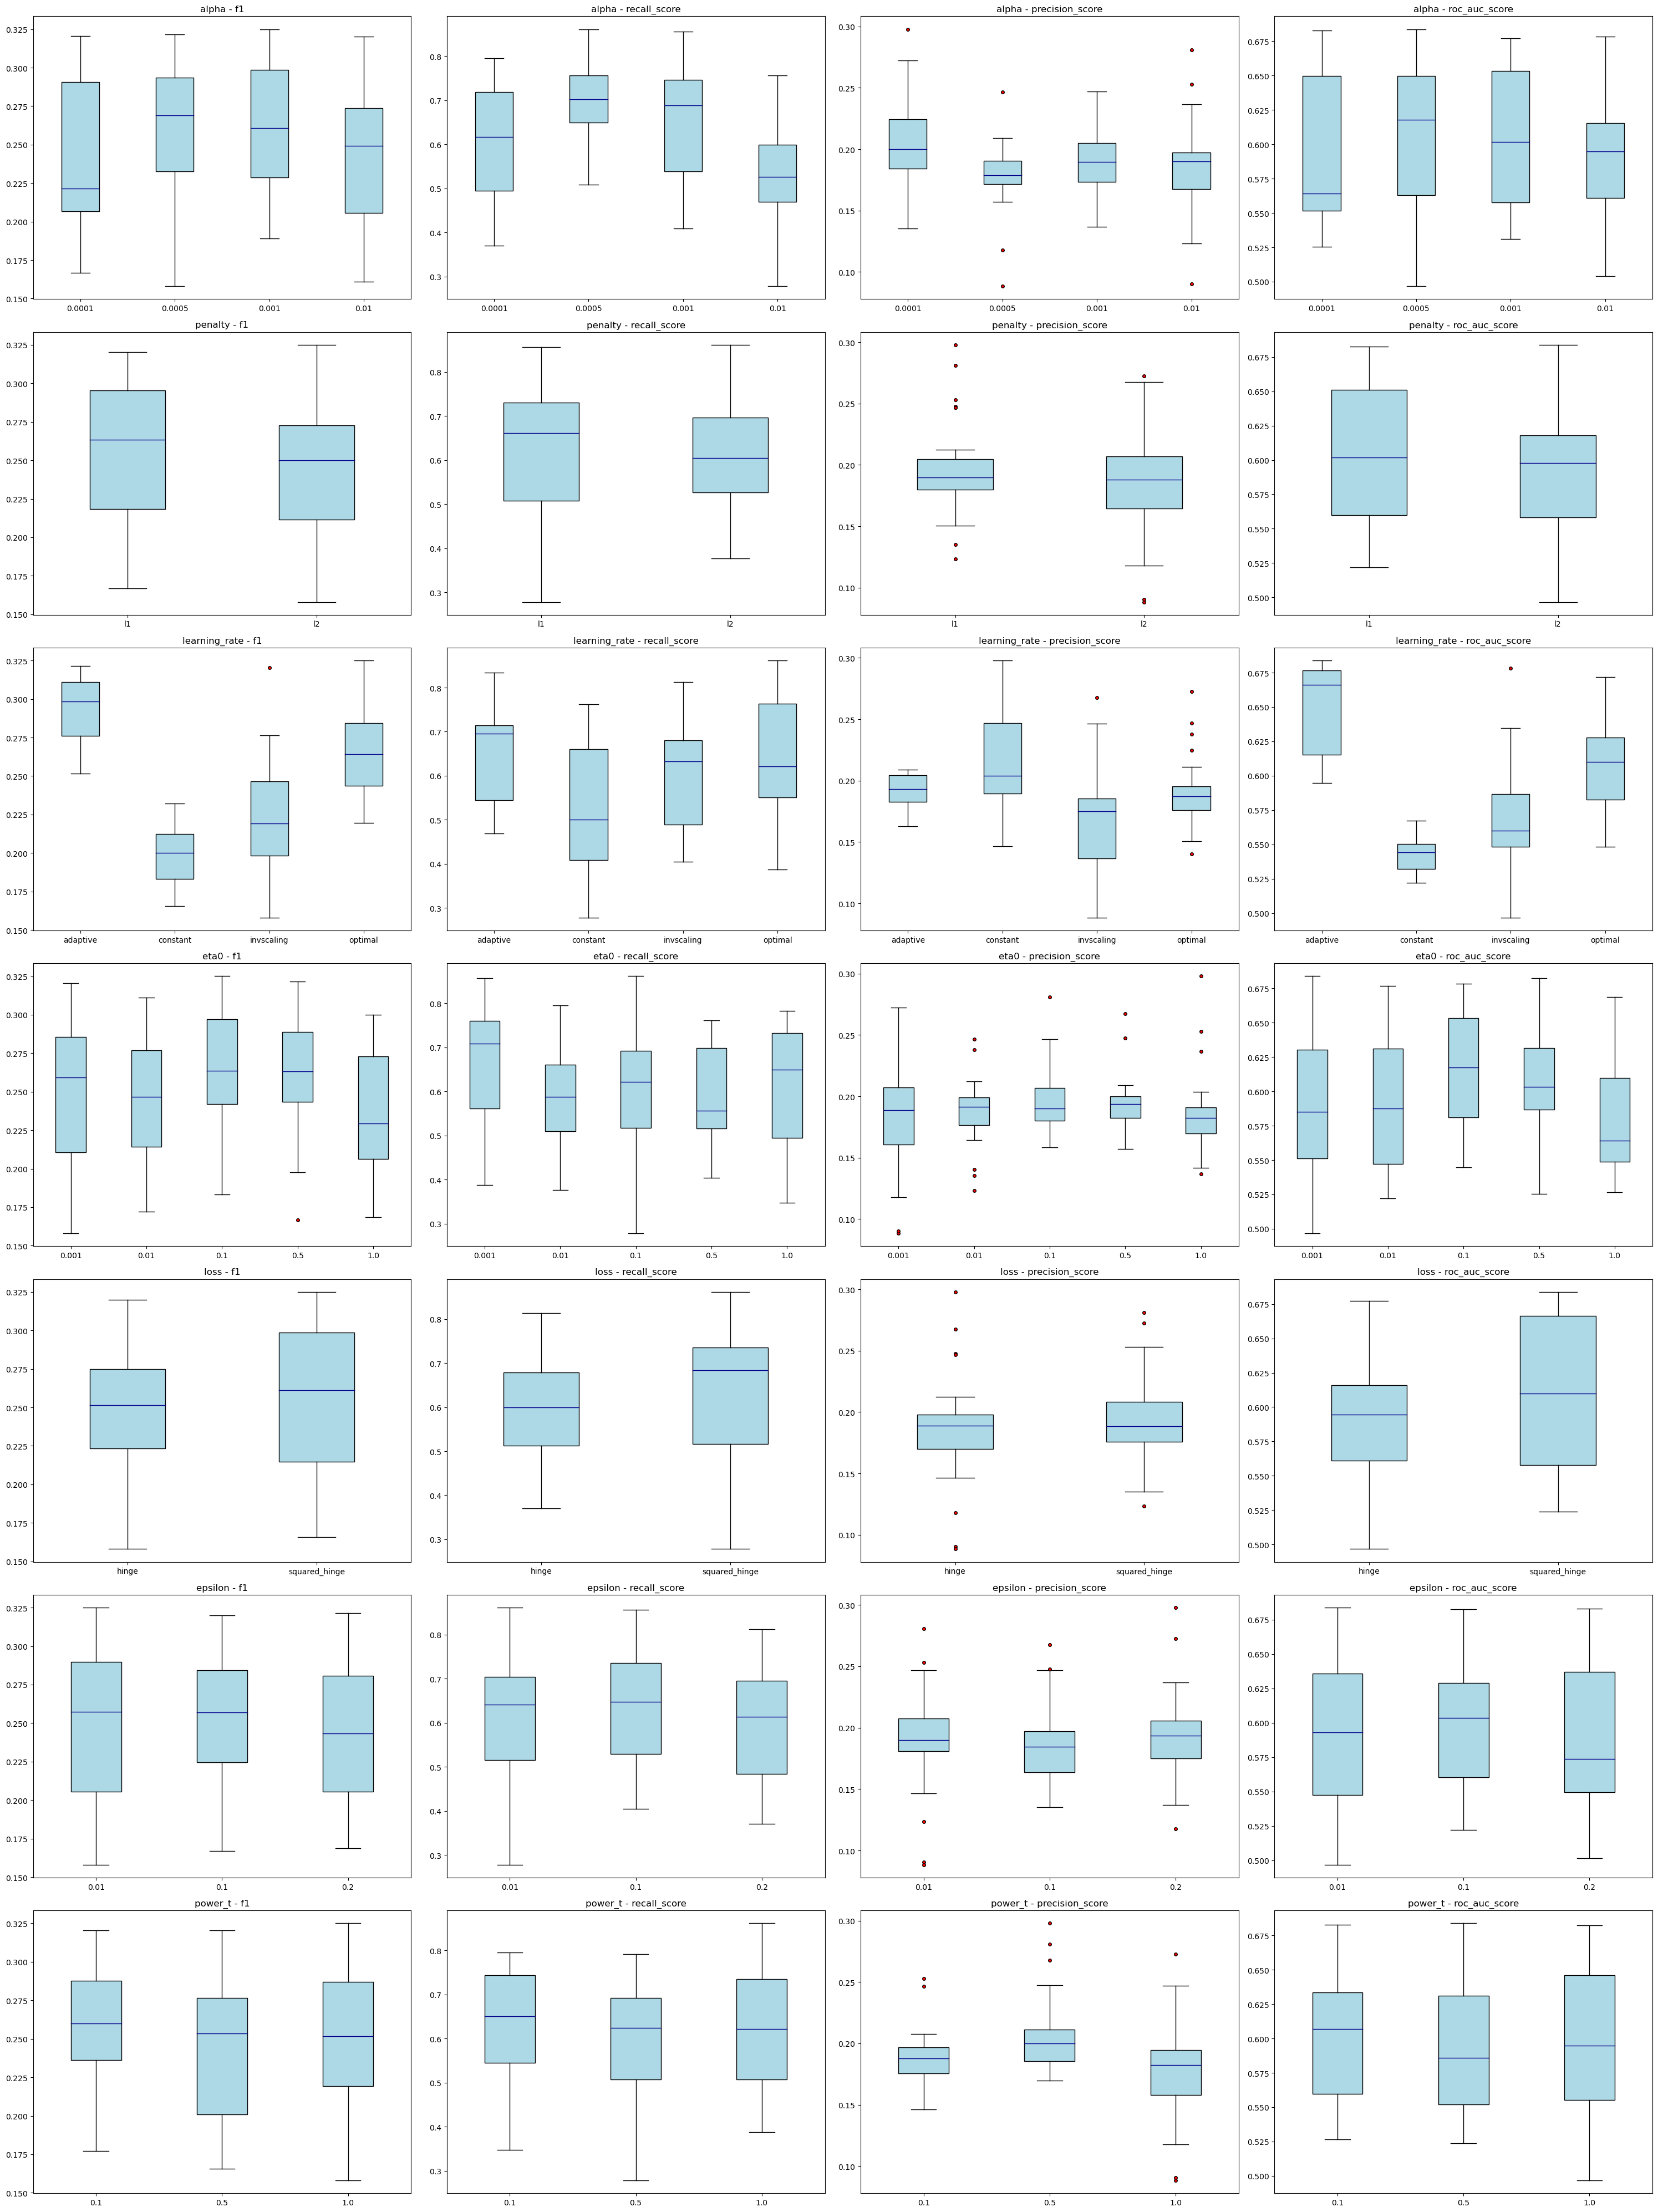

In [285]:
num_best_models = 90

best_models = sorted(sgd_svm_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

plot_metrics(sgd_svm_result, sgd_svm_params, best_models, figsize_param = (30,40))

In [286]:
best_sgd_svm = sorted(sgd_svm_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(SGDClassifier(**best_sgd_svm[0])))
print('F1: {}'.format(round(best_sgd_svm[1]['f1'][1],4)))

Best Model: SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1: 0.325


#### SVC

In [268]:
model = LinearSVC(max_iter = 2000)
svc_params = svc_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'loss': ['hinge', 'squared_hinge'],    # Loss function
    # 'penalty': ['l1', 'l2'],                # Regularization term ('l1' or 'l2')
    # 'dual': [False],                  # Formulation ('True' for dual, 'False' for primal)
    'class_weight': ['balanced', 
                     # {1: 0.7, 0:0.3}, 
                     # {1: 0.8, 0:0.2}, 
                     {1: 0.9, 0:0.1}, 
                     {1: 0.95, 0:0.05}]
}

svc_result = []
for i in tqdm(range(10)):
    random_params = {}
    for key, values in svc_params.items():
        random_params[key] = random.choice(values)
        
    svc_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = False, 
                     cv=5))

  0%|                                                    | 0/10 [00:00<?, ?it/s]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

LinearSVC(C=0.1, class_weight={0: 0.1, 1: 0.9}, loss='hinge', max_iter=2000)
F1 train: 0.297, F1_val: 0.296


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 20%|████████▊                                   | 2/10

LinearSVC(C=1, class_weight='balanced', loss='hinge', max_iter=2000)
F1 train: 0.096, F1_val: 0.104


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 30%|█████████████▏                              | 3/10

LinearSVC(C=10, class_weight={0: 0.05, 1: 0.95}, max_iter=2000)
F1 train: 0.069, F1_val: 0.092


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 40%|█████████████████▌                          | 4/10

LinearSVC(C=0.001, class_weight='balanced', loss='hinge', max_iter=2000)
F1 train: 0.297, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 50%|██████████████████████                      | 5/10

LinearSVC(C=1, class_weight={0: 0.1, 1: 0.9}, loss='hinge', max_iter=2000)
F1 train: 0.297, F1_val: 0.300


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 60%|██████████████████████████▍                 | 6/10

LinearSVC(C=0.001, class_weight='balanced', loss='hinge', max_iter=2000)
F1 train: 0.297, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 70%|██████████████████████████████▊             | 7/10

LinearSVC(C=0.01, class_weight='balanced', max_iter=2000)
F1 train: 0.313, F1_val: 0.313


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 80%|███████████████████████████████████▏        | 8/10

LinearSVC(C=0.01, class_weight={0: 0.1, 1: 0.9}, loss='hinge', max_iter=2000)
F1 train: 0.288, F1_val: 0.282


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 90%|███████████████████████████████████████▌    | 9/10

LinearSVC(C=0.001, class_weight={0: 0.05, 1: 0.95}, loss='hinge', max_iter=2000)
F1 train: 0.201, F1_val: 0.201


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|███████████████████████████████████████████| 10/10

LinearSVC(C=1, class_weight={0: 0.05, 1: 0.95}, loss='hinge', max_iter=2000)
F1 train: 0.282, F1_val: 0.285


#### Gaussian NB

In [297]:
model = GaussianNB()

gnb_params = {
    'var_smoothing': [1e-9],
}

gnb_upsample_params = []
gnb_result = []
for upsample in [True,False]:
    for upsample_type in ['simple', 'SMOTE']:
        if upsample == False:
           upsample_type = None 
        gnb_upsample_params.append([upsample, upsample_type])
        print(upsample, upsample_type)
        gnb_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = upsample, 
                     upsample_type = upsample_type,
                     cv=5))
        
    

True simple
GaussianNB()
F1 train: 0.688, F1_val: 0.234
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


GaussianNB()
F1 train: 0.797, F1_val: 0.238
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


GaussianNB()
F1 train: 0.269, F1_val: 0.269
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


GaussianNB()
F1 train: 0.269, F1_val: 0.269


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


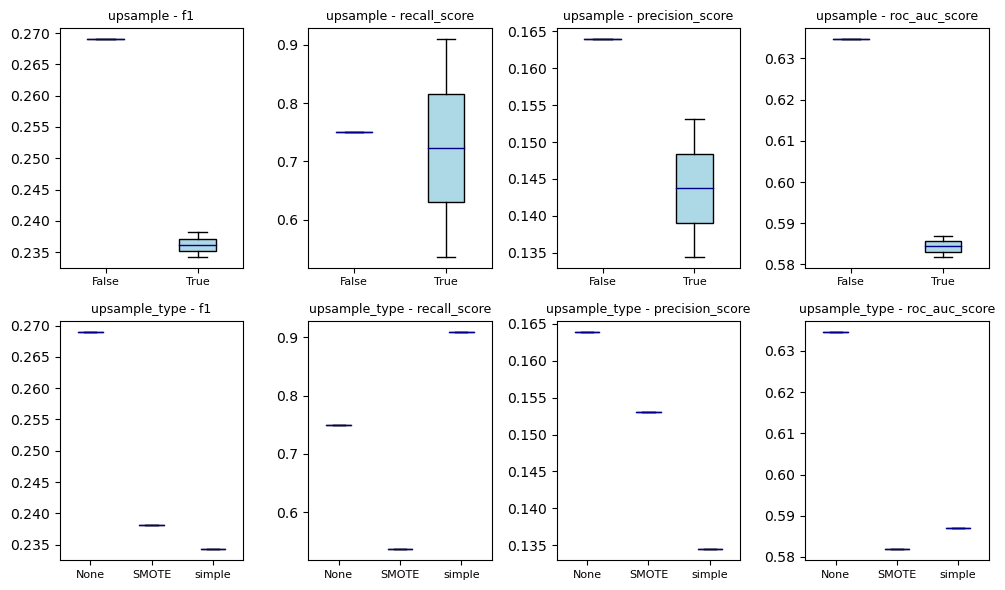

In [298]:
upsample_list = ['upsample', 'upsample_type']

fig,ax = plt.subplots(ncols = len(cnb_result[0][1]), nrows = len(upsample_list), figsize = (10,6))
    
for m in range(len(cnb_result[0][1])):
    for key in range(len(upsample_list)):
        hyperparam = upsample_list[key]
        metric = list(cnb_result[0][1].keys())[m]
        hyperparam_df = pd.DataFrame(list(zip([i[key] for i in cnb_upsample_params], [( cnb_result[i][1][metric][1]) for i in range(len(cnb_result))])),
                                     columns = ['hyperparameter', metric]).fillna('None')
        if hyperparam_df['hyperparameter'].dtype == 'O':
            hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
        hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
        
        ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
        labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
        patch_artist=True,
        widths=0.4,         
        medianprops=dict(color='darkblue'),
        boxprops=dict(facecolor='lightblue', edgecolor='black'),
         whiskerprops=dict(color='black'), 
         capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
                          ) 
        ax[key, m].tick_params(axis='x', labelsize=8)
        ax[key, m].set_title(hyperparam + ' - ' + metric, fontsize=9)

        ax[key, m].xaxis.grid(False)
        ax[key, m].yaxis.grid(False)
plt.tight_layout()
plt.savefig('Images/gradient_boosting_upsample_results.png')
plt.show()

In [301]:
model = GaussianNB()

gnb_result = []
gnb_params = {
    'var_smoothing': 1e-9,
}

gnb_result.append(cross_validation(data, 
                     target, 
                     model, 
                     gnb_params, 
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = False, 
                     cv=5))

GaussianNB()
F1 train: 0.269, F1_val: 0.269


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [302]:
with open('Learning_results/gnb_model_selection.pkl', 'wb') as file:
    pickle.dump(gnb_result, file)

#### MLP Classifier

In [230]:
model = MLPClassifier(verbose = False)

params = {
    'hidden_layer_sizes': [(50, 50), (100,), (30,30)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [50]
}

mlp_upsample_params = []
mlp_result = []
for i in tqdm(range(30)):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
        
    upsample = random.choice([True,False])
    if upsample == True:
       upsample_type = random.choice(['simple', 'SMOTE'])
    else:
       upsample_type = None
    mlp_upsample_params.append([upsample, upsample_type])
    print(upsample, upsample_type)
    mlp_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = upsample, 
                     upsample_type = upsample_type,
                     cv=5))

  0%|                                                    | 0/30 [00:00<?, ?it/s]

False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarni

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.000, F1_val: 0.000
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', learning_rate='invscaling', max_iter=50)
F1 train: 0.755, F1_val: 0.312
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', learning_rate='adaptive', max_iter=50,
              solver='sgd')
F1 train: 0.575, F1_val: 0.249
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=50)
F1 train: 0.889, F1_val: 0.203
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              max_iter=50)
F1 train: 0.730, F1_val: 0.310
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(alpha=0.001, learning_rate='invscaling', max_iter=50)
F1 train: 0.080, F1_val: 0.095
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=50)
F1 train: 0.056, F1_val: 0.070
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=50)
F1 train: 0.682, F1_val: 0.313
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

MLPClassifier(alpha=0.01, learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.017, F1_val: 0.001
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=50)
F1 train: 0.892, F1_val: 0.199
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='adaptive',
              max_iter=50, solver='sgd')
F1 train: 0.010, F1_val: 0.001
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarni

MLPClassifier(activation='logistic', max_iter=50, solver='sgd')
F1 train: 0.000, F1_val: 0.000
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=50)
F1 train: 0.741, F1_val: 0.316
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarni

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and t

MLPClassifier(activation='tanh', max_iter=50, solver='sgd')
F1 train: 0.004, F1_val: 0.001
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.01, learning_rate='invscaling',
              max_iter=50)
F1 train: 0.046, F1_val: 0.046
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(learning_rate='adaptive', max_iter=50)
F1 train: 0.894, F1_val: 0.180
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 63%|███████████████████████████▏               | 19/30 [09:53<06:31, 35.62s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.771, F1_val: 0.210
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.001, learning_rate='adaptive',
              max_iter=50, solver='sgd')
F1 train: 0.639, F1_val: 0.285
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50)
F1 train: 0.892, F1_val: 0.210
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='invscaling',
              max_iter=50)
F1 train: 0.712, F1_val: 0.323
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              max_iter=50, solver='sgd')
F1 train: 0.639, F1_val: 0.282
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.001, learning_rate='adaptive',
              max_iter=50)
F1 train: 0.079, F1_val: 0.075
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.01, learning_rate='invscaling',
              max_iter=50)
F1 train: 0.050, F1_val: 0.051
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and t

MLPClassifier(learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.025, F1_val: 0.001
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and t

MLPClassifier(activation='tanh', learning_rate='adaptive', max_iter=50,
              solver='sgd')
F1 train: 0.005, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(learning_rate='invscaling', max_iter=50)
F1 train: 0.078, F1_val: 0.097
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50)
F1 train: 0.047, F1_val: 0.029
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████

MLPClassifier(alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.000, F1_val: 0.001


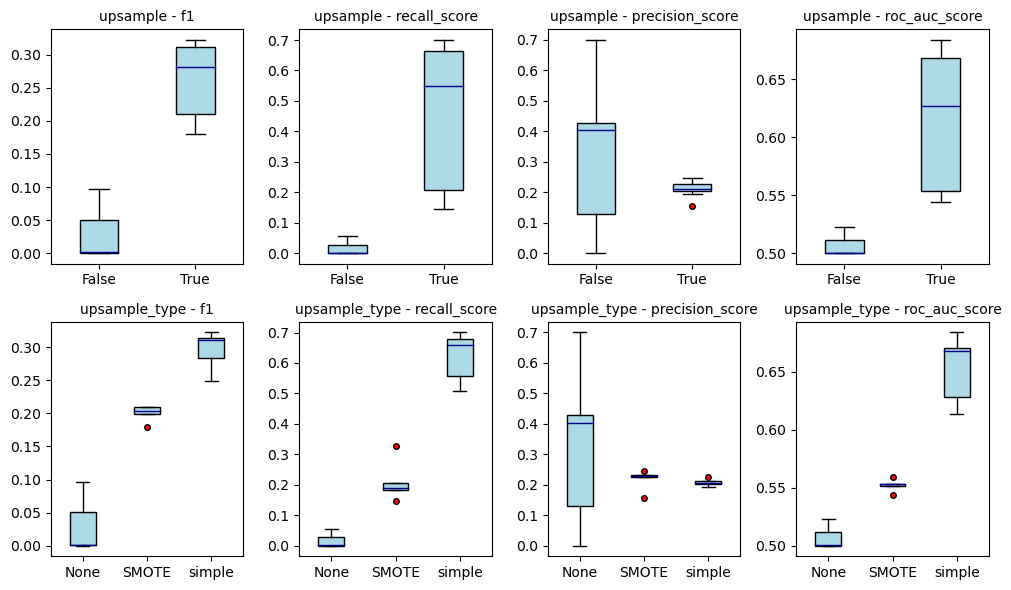

<Figure size 640x480 with 0 Axes>

In [231]:
upsample_list = ['upsample', 'upsample_type']

fig,ax = plt.subplots(ncols = len(mlp_result[0][1]), nrows = len(upsample_list), figsize = (10,6))
    
for m in range(len(mlp_result[0][1])):
    for key in range(len(upsample_list)):
        hyperparam = upsample_list[key]
        metric = list(mlp_result[0][1].keys())[m]
        hyperparam_df = pd.DataFrame(list(zip([i[key] for i in mlp_upsample_params], [( mlp_result[i][1][metric][1]) for i in range(len(mlp_result))])),
                                     columns = ['hyperparameter', metric]).fillna('None')
        if hyperparam_df['hyperparameter'].dtype == 'O':
            hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
        hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
        
        ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
        labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
        patch_artist=True,
        widths=0.4,         
        medianprops=dict(color='darkblue'),
        boxprops=dict(facecolor='lightblue', edgecolor='black'),
         whiskerprops=dict(color='black'), 
         capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
                          ) 
        ax[key, m].tick_params(axis='x', labelsize=10)
        ax[key, m].set_title(hyperparam + ' - ' + metric, fontsize=10)

        ax[key, m].xaxis.grid(False)
        ax[key, m].yaxis.grid(False)
plt.tight_layout()
plt.show()
plt.savefig('Images/mlp_upsample_results.png')

In [241]:
## Rerun with simple upsampling

model = MLPClassifier(verbose = False)

params = {
    'hidden_layer_sizes': [(50, 50), (100,), (30,30), (80,80), (30,30,30), (100,100)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 300, 400]
}

mlp_upsample_params = []
mlp_result = []
for i in tqdm(range(100)):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)

    mlp_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = True, 
                     upsample_type = 'simple',
                     cv=5))

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  1%|▍                                          | 1/100 [00:21<34:42, 21.03s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(80, 80),
              learning_rate='invscaling', solver='sgd')
F1 train: 0.599, F1_val: 0.267


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', solver='sgd')
F1 train: 0.610, F1_val: 0.275


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  3%|█▏                                      | 3/100 [06:00<3:44:20, 138.77s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30, 30), max_iter=300,
              solver='sgd')
F1 train: 0.595, F1_val: 0.251


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30, 30),
              max_iter=400)
F1 train: 0.781, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  5%|██                                      | 5/100 [15:25<5:47:12, 219.28s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=400)
F1 train: 0.785, F1_val: 0.295


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(80, 80),
              learning_rate='invscaling')
F1 train: 0.812, F1_val: 0.291


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50))
F1 train: 0.806, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  8%|███▏                                    | 8/100 [25:31<5:01:55, 196.91s/it]

MLPClassifier(activation='tanh', alpha=0.001, max_iter=300, solver='sgd')
F1 train: 0.638, F1_val: 0.293


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30))
F1 train: 0.748, F1_val: 0.309


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_m

MLPClassifier(hidden_layer_sizes=(50, 50), solver='sgd')
F1 train: 0.574, F1_val: 0.269


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 11%|████▎                                  | 11/100 [30:07<2:53:28, 116.95s/it]

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=300, solver='sgd')
F1 train: 0.659, F1_val: 0.204


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 12%|████▋                                  | 12/100 [37:55<5:28:09, 223.74s/it]

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 100),
              max_iter=400, solver='sgd')
F1 train: 0.659, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100),
              learning_rate='adaptive', solver='sgd')
F1 train: 0.662, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=300)
F1 train: 0.812, F1_val: 0.296


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 15%|█████▊                                 | 15/100 [50:37<5:30:06, 233.01s/it]

MLPClassifier(activation='tanh', hidden_layer_sizes=(30, 30, 30),
              learning_rate='adaptive', max_iter=300, solver='sgd')
F1 train: 0.656, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|██████▏                                | 16/100 [56:27<6:15:29, 268.20s/it]

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100),
              max_iter=300, solver='sgd')
F1 train: 0.674, F1_val: 0.281


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|██████▋                                | 17/100 [59:27<5:34:23, 241.73s/it]

MLPClassifier(learning_rate='adaptive', max_iter=300)
F1 train: 0.777, F1_val: 0.299


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30), solver='sgd')
F1 train: 0.661, F1_val: 0.279


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 19%|███████                              | 19/100 [1:08:33<6:06:17, 271.32s/it]

MLPClassifier(hidden_layer_sizes=(80, 80), learning_rate='invscaling',
              max_iter=400)
F1 train: 0.872, F1_val: 0.262


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30))
F1 train: 0.762, F1_val: 0.301


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100),
              learning_rate='adaptive', max_iter=400, solver='sgd')
F1 train: 0.670, F1_val: 0.284


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 22%|████████▏                            | 22/100 [1:24:57<6:34:49, 303.71s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=300)
F1 train: 0.748, F1_val: 0.307


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 50),
              max_iter=300)
F1 train: 0.799, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive')
F1 train: 0.808, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30), max_iter=300)
F1 train: 0.775, F1_val: 0.296


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

MLPClassifier(activation='logistic', alpha=0.001,
              hidden_layer_sizes=(30, 30, 30), learning_rate='invscaling',
              solver='sgd')
F1 train: 0.128, F1_val: 0.040


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh')
F1 train: 0.796, F1_val: 0.293


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 28%|██████████▎                          | 28/100 [1:46:00<4:43:54, 236.59s/it]

MLPClassifier(hidden_layer_sizes=(80, 80), learning_rate='adaptive',
              max_iter=400)
F1 train: 0.859, F1_val: 0.269


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 29%|██████████▋                          | 29/100 [1:46:10<3:19:26, 168.54s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=400, solver='sgd')
F1 train: 0.458, F1_val: 0.197


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 30%|█████████

MLPClassifier(activation='logistic', alpha=0.001,
              hidden_layer_sizes=(30, 30, 30), learning_rate='invscaling',
              max_iter=300, solver='sgd')
F1 train: 0.533, F1_val: 0.161


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 31%|███████████▊                          | 31/100 [1:46:31<1:41:03, 87.87s/it]

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=400, solver='sgd')
F1 train: 0.270, F1_val: 0.101


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(80, 80),
              max_iter=300)
F1 train: 0.893, F1_val: 0.259


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|████████████▏                        | 33/100 [1:53:43<2:30:50, 135.08s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30, 30),
              learning_rate='invscaling', solver='sgd')
F1 train: 0.558, F1_val: 0.232


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 34%|████████████▉                         | 34/100 [1:53:59<1:49:19, 99.38s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=300, solver='sgd')
F1 train: 0.577, F1_val: 0.235


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=300)
F1 train: 0.760, F1_val: 0.302


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 36%|█████████████▎                       | 36/100 [2:00:59<2:46:42, 156.29s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30, 30),
              learning_rate='adaptive', max_iter=300, solver='sgd')
F1 train: 0.664, F1_val: 0.293


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 37%|█████████████▋                       | 37/100 [2:11:07<5:06:17, 291.70s/it]

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 100),
              learning_rate='adaptive', max_iter=400, solver='sgd')
F1 train: 0.654, F1_val: 0.291


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', hidden_layer_sizes=(30, 30, 30),
              learning_rate='adaptive', solver='sgd')
F1 train: 0.657, F1_val: 0.289


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 39%|██████████████▍                      | 39/100 [2:15:59<3:38:43, 215.14s/it]

MLPClassifier(max_iter=300, solver='sgd')
F1 train: 0.620, F1_val: 0.264


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 40%|██████████████▊                      | 40/100 [2:16:13<2:34:46, 154.77s/it]

MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='invscaling',
              max_iter=300, solver='sgd')
F1 train: 0.605, F1_val: 0.261


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(80, 80),
              learning_rate='invscaling', max_iter=300)
F1 train: 0.895, F1_val: 0.255


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 42%|███████████████▌                     | 42/100 [2:24:42<3:03:52, 190.22s/it]

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(30, 30),
              solver='sgd')
F1 train: 0.574, F1_val: 0.259


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001)
F1 train: 0.803, F1_val: 0.294


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', solver='sgd')
F1 train: 0.665, F1_val: 0.275


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 45%|████████████████▋                    | 45/100 [2:37:31<3:56:07, 257.59s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(80, 80),
              max_iter=400)
F1 train: 0.879, F1_val: 0.257


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 46%|█████████████████                    | 46/100 [2:39:23<3:12:44, 214.16s/it]

MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30), max_iter=400)
F1 train: 0.730, F1_val: 0.317


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 47%|█████████████████▍                   | 47/100 [2:39:36<2:15:41, 153.62s/it]

MLPClassifier(activation='logistic', alpha=0.001, learning_rate='invscaling',
              solver='sgd')
F1 train: 0.582, F1_val: 0.229


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, learning_rate='invscaling',
              max_iter=300)
F1 train: 0.808, F1_val: 0.286


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 49%|██████████████████▏                  | 49/100 [2:43:32<1:47:29, 126.46s/it]

MLPClassifier(activation='logistic', hidden_layer_sizes=(80, 80),
              learning_rate='invscaling', solver='sgd')
F1 train: 0.515, F1_val: 0.162


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=400)
F1 train: 0.770, F1_val: 0.300


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 80))
F1 train: 0.879, F1_val: 0.269


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 52%|███████████████████▏                 | 52/100 [2:55:13<2:32:13, 190.29s/it]

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30), max_iter=400,
              solver='sgd')
F1 train: 0.637, F1_val: 0.284


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 53%|███████████████████▌                 | 53/100 [2:55:41<1:50:56, 141.62s/it]

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100),
              learning_rate='invscaling', max_iter=400, solver='sgd')
F1 train: 0.589, F1_val: 0.246


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(learning_rate='adaptive')
F1 train: 0.773, F1_val: 0.297


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 55%|████████████████████▎                | 55/100 [2:59:49<1:38:43, 131.63s/it]

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=400)
F1 train: 0.724, F1_val: 0.314


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 56%|█████████████████████▎                | 56/100 [3:00:00<1:10:06, 95.61s/it]

MLPClassifier(activation='logistic', alpha=0.01,
              hidden_layer_sizes=(30, 30, 30), max_iter=400, solver='sgd')
F1 train: 0.632, F1_val: 0.204


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 57%|█████████████████████                | 57/100 [3:05:51<2:03:26, 172.25s/it]

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(80, 80),
              max_iter=300, solver='sgd')
F1 train: 0.663, F1_val: 0.283


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='invscaling')
F1 train: 0.754, F1_val: 0.302


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(80, 80),
              learning_rate='adaptive')
F1 train: 0.809, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 60%|██████████████████████▏              | 60/100 [3:14:41<1:55:17, 172.95s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30), max_iter=300,
              solver='sgd')
F1 train: 0.663, F1_val: 0.282


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              solver='sgd')
F1 train: 0.688, F1_val: 0.272


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh')
F1 train: 0.797, F1_val: 0.291


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 63%|███████████████████████▎             | 63/100 [3:22:39<1:27:57, 142.63s/it]

MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              solver='sgd')
F1 train: 0.611, F1_val: 0.268


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30, 30),
              max_iter=300)
F1 train: 0.767, F1_val: 0.289


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 65%|█████████

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', solver='sgd')
F1 train: 0.412, F1_val: 0.152


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, learning_rate='adaptive',
              solver='sgd')
F1 train: 0.663, F1_val: 0.271


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 100))
F1 train: 0.888, F1_val: 0.250


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(hidden_layer_sizes=(50, 50), solver='sgd')
F1 train: 0.627, F1_val: 0.264


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001)
F1 train: 0.801, F1_val: 0.286


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 70%|█████████████████████████▉           | 70/100 [3:42:05<1:18:11, 156.39s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=400)
F1 train: 0.755, F1_val: 0.300


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(hidden_layer_sizes=(80, 80))
F1 train: 0.850, F1_val: 0.259


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=400)
F1 train: 0.838, F1_val: 0.286


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=300)
F1 train: 0.817, F1_val: 0.280


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 74%|███████████████████████████▍         | 74/100 [4:00:33<1:43:55, 239.84s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=300)
F1 train: 0.800, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 50),
              max_iter=300)
F1 train: 0.799, F1_val: 0.291


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 76%|████████████████████████████         | 76/100 [4:05:18<1:11:19, 178.32s/it]

MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='invscaling',
              max_iter=400, solver='sgd')
F1 train: 0.594, F1_val: 0.253


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(30, 30))
F1 train: 0.745, F1_val: 0.304


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_m

MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=300,
              solver='sgd')
F1 train: 0.652, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 100),
              learning_rate='adaptive', solver='sgd')
F1 train: 0.626, F1_val: 0.284


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 80%|█████████████████████████████▌       | 80/100 [4:20:59<1:10:40, 212.01s/it]

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=400)
F1 train: 0.732, F1_val: 0.307


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 81%|█████████████████████████████▉       | 81/100 [4:25:08<1:10:40, 223.18s/it]

MLPClassifier(activation='tanh', alpha=0.001, learning_rate='adaptive',
              max_iter=400)
F1 train: 0.812, F1_val: 0.276


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_m

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(80, 80),
              solver='sgd')
F1 train: 0.644, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 83%|████████████████████████████████▎      | 83/100 [4:29:25<46:36, 164.47s/it]

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=400, solver='sgd')
F1 train: 0.264, F1_val: 0.111


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_m

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(80, 80),
              max_iter=300, solver='sgd')
F1 train: 0.627, F1_val: 0.293


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 85%|█████████████████████████████████▏     | 85/100 [4:37:54<50:17, 201.19s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30, 30),
              learning_rate='invscaling')
F1 train: 0.761, F1_val: 0.299


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_m

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(80, 80),
              learning_rate='adaptive', max_iter=300, solver='sgd')
F1 train: 0.668, F1_val: 0.291


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 87%|█████████████████████████████████▉     | 87/100 [4:48:46<57:32, 265.61s/it]

MLPClassifier(alpha=0.01, hidden_layer_sizes=(80, 80), max_iter=400)
F1 train: 0.850, F1_val: 0.272


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 88%|██████████████████████████████████▎    | 88/100 [4:51:31<47:06, 235.56s/it]

MLPClassifier(hidden_layer_sizes=(30, 30, 30), max_iter=400, solver='sgd')
F1 train: 0.625, F1_val: 0.273


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001)
F1 train: 0.789, F1_val: 0.292


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', learning_rate='invscaling', max_iter=400)
F1 train: 0.829, F1_val: 0.282


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', learning_rate='invscaling', max_iter=300)
F1 train: 0.817, F1_val: 0.278


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 92%|███████████████████████████████████▉   | 92/100 [5:07:41<33:26, 250.84s/it]

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(80, 80),
              learning_rate='invscaling', max_iter=300)
F1 train: 0.746, F1_val: 0.304


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(30, 30))
F1 train: 0.757, F1_val: 0.301


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive')
F1 train: 0.808, F1_val: 0.281


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30, 30),
              learning_rate='adaptive')
F1 train: 0.760, F1_val: 0.305


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 96%|█████████████████████████████████████▍ | 96/100 [5:18:52<13:00, 195.15s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=300, solver='sgd')
F1 train: 0.657, F1_val: 0.294


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling')
F1 train: 0.790, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 98%|█████████

MLPClassifier(activation='logistic', alpha=0.001,
              hidden_layer_sizes=(30, 30, 30), max_iter=300, solver='sgd')
F1 train: 0.532, F1_val: 0.161


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 99%|███████████████████████████████████████▌| 99/100 [5:21:58<01:36, 96.45s/it]

MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=300, solver='sgd')
F1 train: 0.590, F1_val: 0.253


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████| 100/100 [5:30:48<00:00, 198.48s/it]

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100),
              max_iter=400, solver='sgd')
F1 train: 0.607, F1_val: 0.292


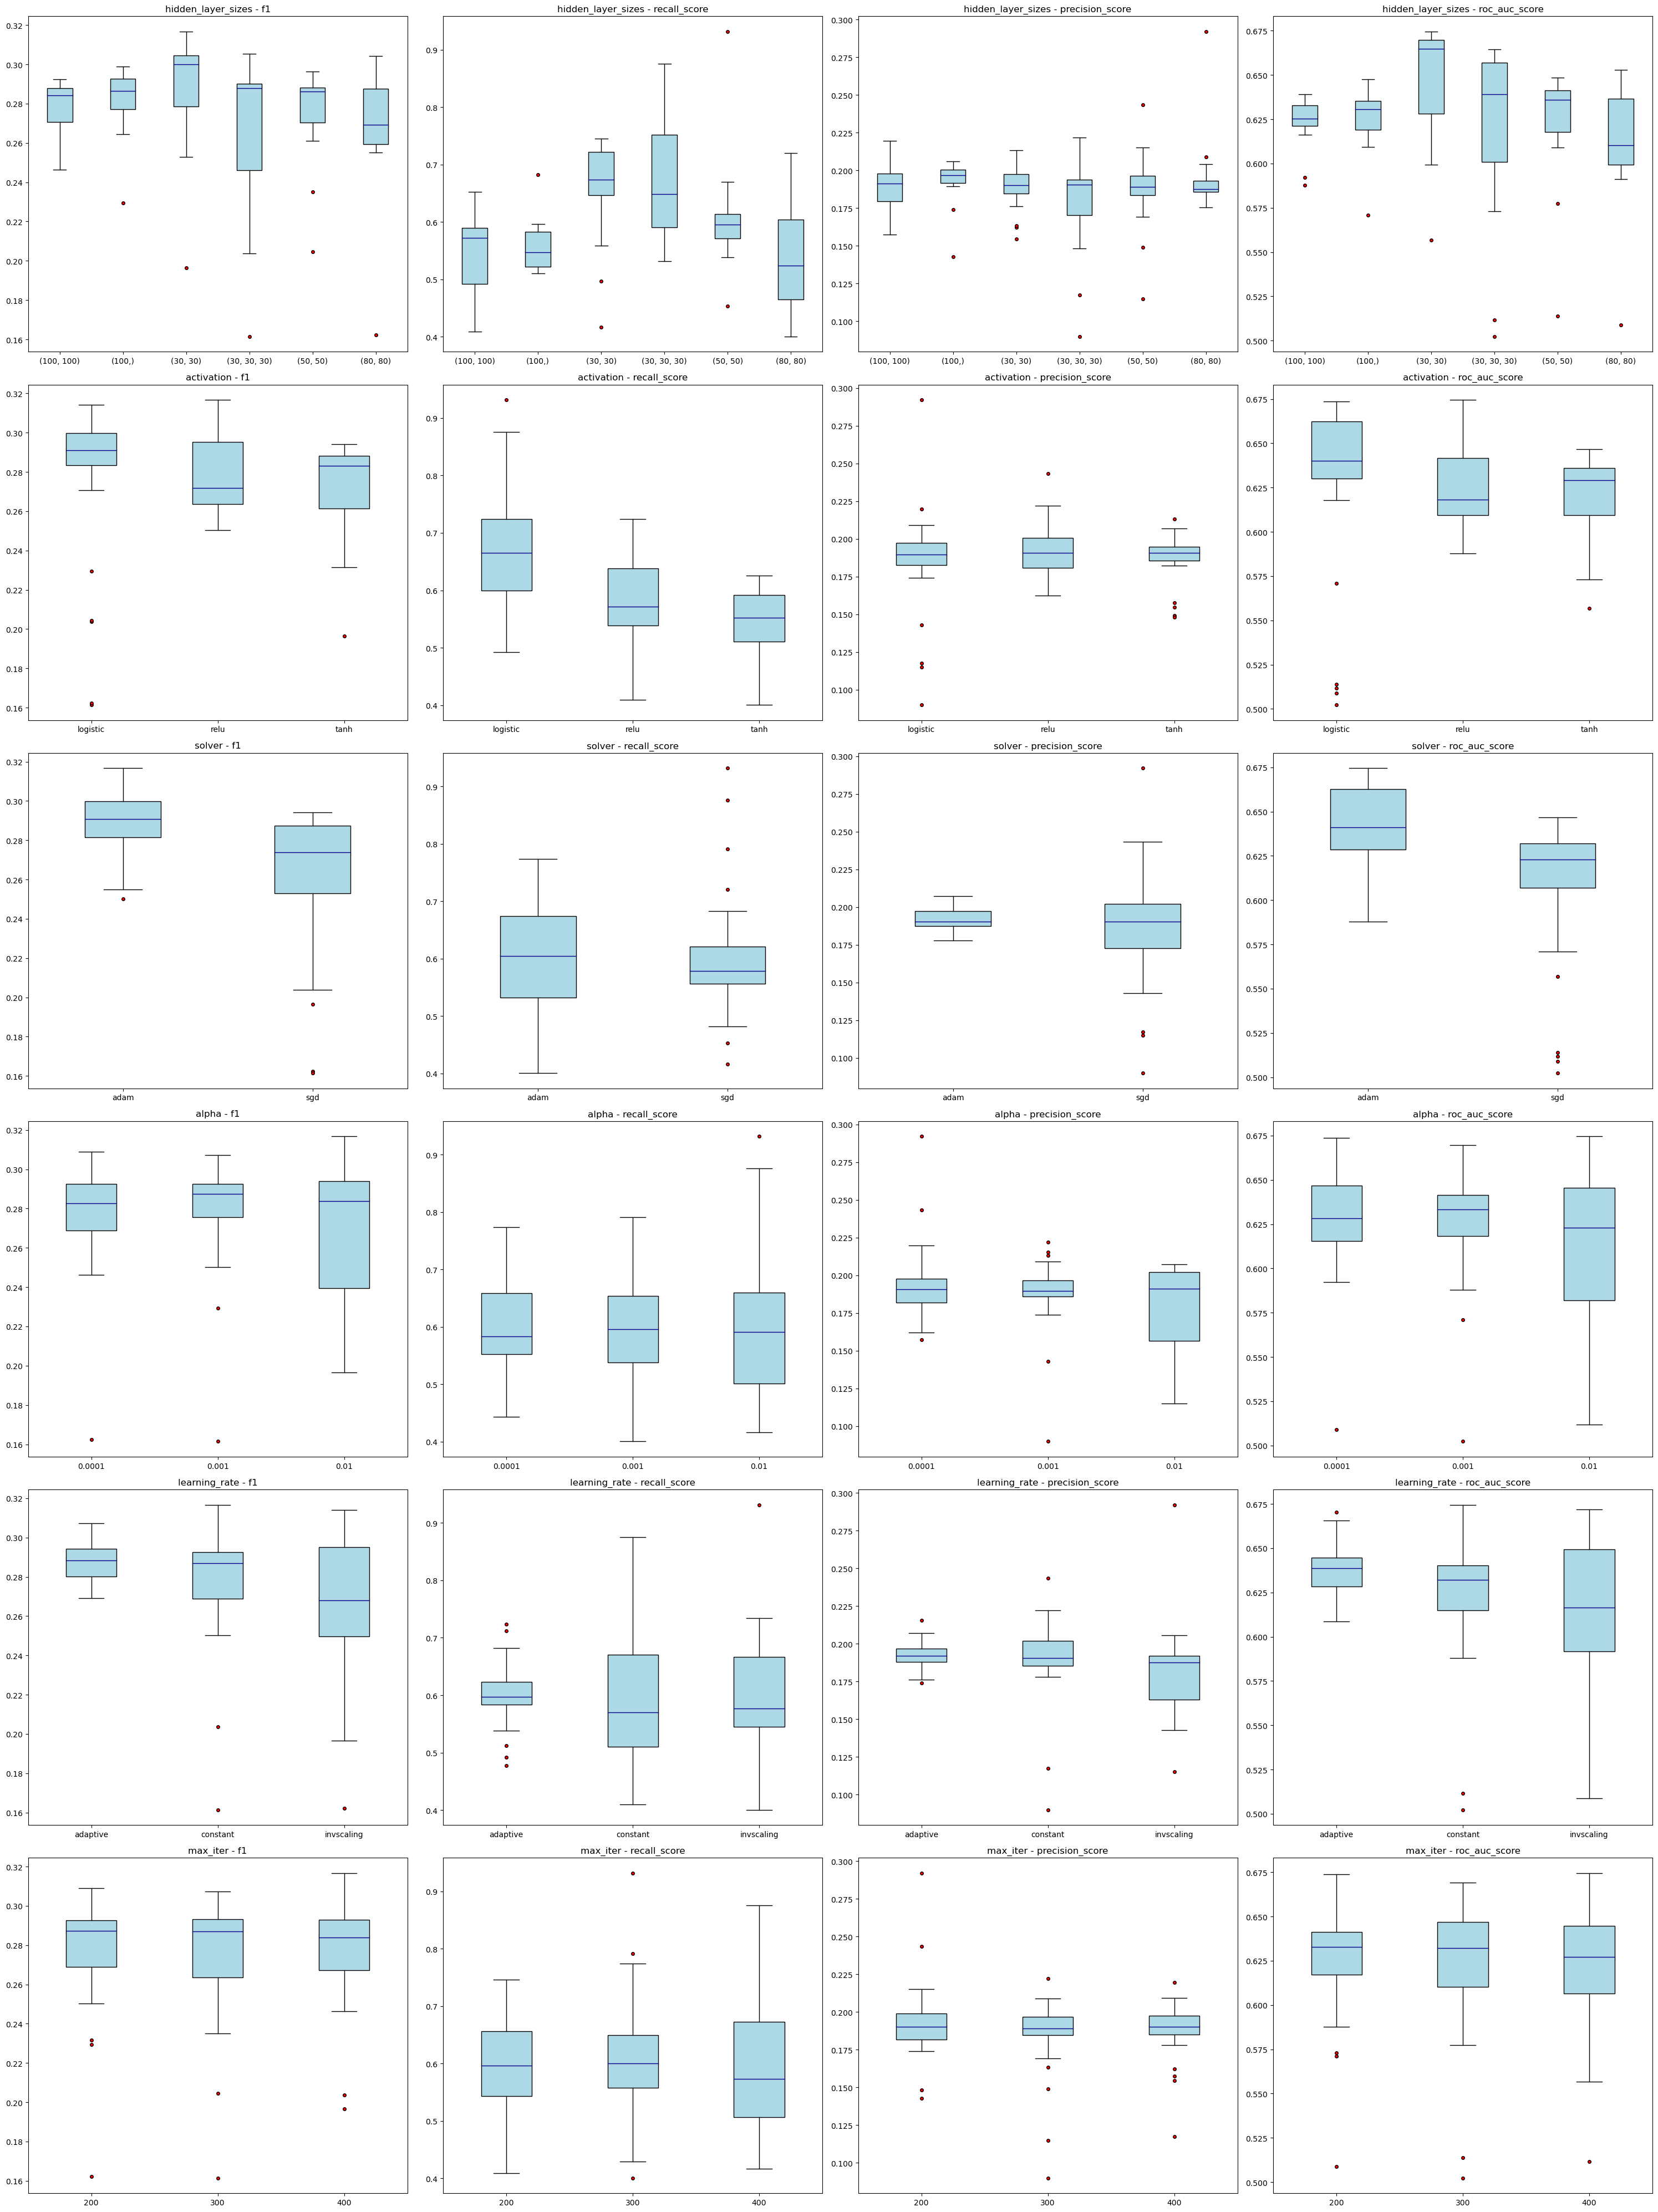

In [242]:
num_best_models = 95

best_models = sorted(mlp_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

plot_metrics(mlp_result, params, best_models, figsize_param = (30,40))

In [243]:
with open('Learning_results/mlp_model_selection.pkl', 'wb') as file:
    pickle.dump(mlp_result, file)

In [244]:
best_mlp = sorted(mlp_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(best_mlp[0]))
print('F1: {}'.format(round(best_mlp[1]['f1'][1],4)))

Best Model: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (30, 30), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 400, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
F1: 0.3167


#### Logistic Regression

In [ ]:
model = LogisticRegression(solver='saga', max_iter = 400, 
                           class_weight = 'balanced', random_state = random_state )
params = {
    'penalty': ['l1', 'l2'],      
    'C': [ 0.01, 0.1, 0.5, 1], 
    'max_iter': np.arange(100,1000,100)
}

result = []
for i in range(10):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                                   
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,

                     target_encoding = True,
                     features_for_encoding = features_for_encoding,
                                   
                     upsample = False, 
                     cv=5))

#### Handmade Stacking Classifier

In [410]:
with open('Learning_results/rf_model_selection.pkl', 'rb') as file:
    rf_result_loaded = pickle.load(file)
with open('Learning_results/gb_model_selection.pkl', 'rb') as file:
    gb_result_loaded = pickle.load(file)
with open('Learning_results/adaboost_model_selection.pkl', 'rb') as file:
    adaboost_result_loaded = pickle.load(file)
with open('Learning_results/mlp_model_selection.pkl', 'rb') as file:
    mlp_result_loaded = pickle.load(file)
with open('Learning_results/sgd_svm_model_selection.pkl', 'rb') as file:
    sgd_svm_result_loaded = pickle.load(file)

In [428]:
best_rf_loaded = sorted(rf_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
rf = RandomForestClassifier(**best_rf_loaded[0])
best_gb_loaded = sorted(gb_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
gb = GradientBoostingClassifier(**best_gb_loaded[0])
best_sgd_svm_loaded = sorted(sgd_svm_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
sgd_svm = SGDClassifier(**best_sgd_svm_loaded[0])
best_mlp_loaded = sorted(mlp_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
mlp = MLPClassifier(**best_mlp_loaded[0])

In [429]:
models_all = [[rf, False],[gb, True], [sgd_svm, False], [mlp, True]]

In [430]:
from itertools import combinations

models_comb = list(combinations(models_all, 2))
models_comb.extend(list(combinations(models_all, 3)))
len(models_comb)

10

In [443]:
# Defining some lists to collect data
stacking_results = []

for models in tqdm(models_comb):
    f1 = []
    confusion_matrix_list = []
    precision_score_list = []
    recall_score_list = []
    roc_auc_score_list = []
    
    scaling = True
    cv = 5
    multiclass = False
    upsample_type ='simple'
    features_for_scaling_minmax_full = features_for_scaling_minmax
    upsample_size = 1
    
    # create stratified folds
    skf = StratifiedKFold(n_splits=cv, shuffle = True, random_state = random_state)
    split = list(skf.split(data.drop(columns = target), data[target]))
    all_train_index = [i[0] for i in split]
    all_val_index = [i[1] for i in split]
    
    for i in tqdm(range(cv)):
        df_stacked_train = pd.DataFrame()
        df_stacked_val = pd.DataFrame()
        for j in models:
            upsample = j[1]
            val_index = all_val_index[i]
            train_index = all_train_index[i]
            train_data, val_data = data.loc[train_index], data.loc[val_index]
        
            #creating features on patient level that we will use
            train_data, val_data, pat_features_scale = patient_features(train_data, val_data, multiclass = multiclass)
            features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale
        
            # Scaling features
            if scaling == True:
                if len(features_for_scaling_minmax) > 0:
                    val_data = scaler(train_data, val_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                    train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                if len(features_for_scaling_standard) > 0:
                    val_data = scaler(train_data, val_data, features_for_scaling_standard, scaling_type = 'standard')
                    train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')
            
            y_train_general = train_data.set_index('encounter_id')[target]
            # Upsampling only train data 
            if upsample == True:
                train_data = upsampler(train_data, target, upsample_type = upsample_type,  upsample_size = upsample_size)
        
            # Defining train and val datasets
            X_train = train_data.set_index('encounter_id').drop(target, axis=1).drop(columns = ['patient_id'])
            y_train = train_data.set_index('encounter_id')[target]
            
            X_val = val_data.set_index('encounter_id').drop(target, axis=1).drop(columns = ['patient_id'])
            y_val = val_data.set_index('encounter_id')[target]
    
            # Fit and predict
            model = j[0]
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_val = model.predict(X_val)
    
            # print(str(model).split('(')[0], [f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
    
            X_train[target] = y_pred_train
            X_train = X_train.drop_duplicates().sort_index()
    
            df_stacked_train[str(model).split('(')[0]] = X_train[target]
            df_stacked_val[str(model).split('(')[0]] = y_pred_val
    
        # Defining train and val datasets
        df_stacked_train[target] = y_train_general.sort_index()
        X_train = df_stacked_train.drop(columns = [target]).fillna(0).astype(int)
        y_train = df_stacked_train[target]
            
        X_val = df_stacked_val
        y_val = val_data[target]
    
        model = LogisticRegression(class_weight = 'balanced', )
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        print(f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val))
        
        f1.append([f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
        recall_score_list.append([recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)])
        precision_score_list.append([precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)])
        roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)])
            
        confusion_matrix_list.append([confusion_matrix(y_train, y_pred_train), confusion_matrix(y_val, y_pred_val)])
    
        # Printing results
    print(models)
    print('F1 train: {:.4f}, F1_val: {:.4f}'.format(np.array(f1).mean(axis = 0)[0],
                                                   np.array(f1).mean(axis = 0)[1]))
    stacking_results.append([models, 
            {'f1' : np.array(f1).mean(axis = 0), 
             'recall_score' : np.array(recall_score_list).mean(axis = 0),
             'precision_score' : np.array(precision_score_list).mean(axis = 0),
             'roc_auc_score' : np.array(roc_auc_score_list).mean(axis = 0)
            }, 
            {'f1' : f1, 
             'recall_score' : recall_score_list,
             'precision_score' : precision_score_list,
             'roc_auc_score' : roc_auc_score_list,
             'confusion_matrix': confusion_matrix_list
            },
            X_train.columns
            ])
    stacking_results

 10%|████▎                                      | 1/10 [02:14<20:10, 134.50s/it]

([RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.4,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42), False], [GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7), True])
F1 train: 0.4652, F1_val: 0.3507



 20%|█████████                                    | 1/5 [00:18<01:13, 18.34s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 40%|██████████████████                           | 2/5 [00:40<01:01, 20.52s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 60%|███████████████████████████                  | 3/5 [01:04<00:44, 22.36s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



([RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.4,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42), False], [SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001), False])
F1 train: 0.4652, F1_val: 0.3507



 30%|████████████▉                              | 3/10 [07:31<18:29, 158.47s/it]

([RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.4,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42), False], [MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30), max_iter=400), True])
F1 train: 0.4652, F1_val: 0.3507



  0%|                                                     | 0/5 [00:00<?, ?it/s]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 20%|█████████                                    | 1/5 [00:21<01:25, 21.30s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 40%|██████████████████                           | 2/5 [00:43<01:05, 21.68s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



([GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7), True], [SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001), False])
F1 train: 0.3740, F1_val: 0.3387



 50%|█████████████████████▌                     | 5/10 [12:49<13:36, 163.25s/it]

([GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7), True], [MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30), max_iter=400), True])
F1 train: 0.3740, F1_val: 0.3387



 20%|█████████                                    | 1/5 [00:27<01:49, 27.46s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 40%|██████████████████                           | 2/5 [00:59<01:30, 30.27s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 60%|███████████████████████████                  | 3/5 [01:35<01:05, 32.86s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



([SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001), False], [MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30), max_iter=400), True])
F1 train: 0.3627, F1_val: 0.3116



 20%|█████████                                    | 1/5 [00:31<02:05, 31.35s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 40%|██████████████████                           | 2/5 [01:07<01:43, 34.34s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 60%|███████████████████████████                  | 3/5 [01:46<01:12, 36.48s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



([RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.4,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42), False], [GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7), True], [SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001), False])
F1 train: 0.4653, F1_val: 0.3512



 80%|██████████████████████████████████▍        | 8/10 [23:23<06:49, 204.78s/it]

([RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.4,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42), False], [GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7), True], [MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30), max_iter=400), True])
F1 train: 0.4653, F1_val: 0.3512



 20%|█████████                                    | 1/5 [00:36<02:26, 36.60s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 40%|██████████████████                           | 2/5 [01:28<02:16, 45.45s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 60%|███████████████████████████                  | 3/5 [02:17<01:34, 47.32s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



([RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.4,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42), False], [SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001), False], [MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30), max_iter=400), True])
F1 train: 0.4653, F1_val: 0.3512



 20%|█████████                                    | 1/5 [00:44<02:59, 44.94s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 40%|██████████████████                           | 2/5 [01:32<02:19, 46.40s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 60%|███████████████████████████                  | 3/5 [02:16<01:31, 45.52s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



([GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7), True], [SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001), False], [MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30), max_iter=400), True])
F1 train: 0.3952, F1_val: 0.3400


In [ ]:
#### can optimise by making predictions and then run all of combinations

### Submissions

In [ ]:
### Submit_v6

columns_to_use = ['encounter_id', 'patient_id', 
                  
                  'gender', 'age', 
                  'has_weight',
                  
                  
                  'outpatient_visits_in_previous_year',
                  'emergency_visits_in_previous_year',
                  'inpatient_visits_in_previous_year', 
                  'total_visits', 
                  'max_visits_of_one_type',
                  
                  'average_pulse_bpm', 
                  'length_of_stay_in_hospital', 
                  
                  'number_lab_tests', 'more_than_one_lab_test',
                  'non_lab_procedures', 
                  'number_of_medications', 
                  'number_diagnoses',
                  
                  'glucose_test_result', 'glucose_test_performed', 
                  'a1c_test_result','a1c_test_performed',
                  
                  'change_in_meds_during_hospitalization', 
                  'prescribed_diabetes_meds', 
                  
                  'race_Asian', 'race_Caucasian', 'race_Hispanic',
                  'race_Other', 'race_nan', 
                  
                  'payer_code_HM', 'payer_code_MC',
                  'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
                  'payer_code_SP', 
                  
                  'high_admission_source', 
                  # 'medium_admission_source', 
                  'low_admission_source',
                  
                  'admission_type_big_share_Elective', 'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',
                  
                  'no_medical_specialty', 
                  
                  'high_medical_specialty',
                  # 'medium_medical_specialty',
                  'low_medical_specialty',
                  
                  'discharged_home_hospice', 'expired', 'very_high_discharge_disposition', 'high_discharge_disposition',
                  # 'medium_discharge_disposition', 


       'high_primary_diagnosis_category', 
                  # 'medium_primary_diagnosis_category',
       'low_primary_diagnosis_category', 'high_secondary_diagnosis_category',
       # 'medium_secondary_diagnosis_category',
       'low_secondary_diagnosis_category',
       'high_additional_diagnosis_category',
       # 'medium_additional_diagnosis_category',
                  
       'low_additional_diagnosis_category',
                   
                  'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
                  'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
                  'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
                  'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
                  'rosiglitazone', 'glipizide', 
                  
                  'insulin'
                 ]
                 
features_for_encoding = [
    'admission_type',
       'medical_specialty', 'discharge_disposition',
       'admission_source', 
    'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis',
        'primary_diagnosis_category', 'secondary_diagnosis_category', 'additional_diagnosis_category'
                        ]

features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 
                               'glucose_test_result',
       'a1c_test_result'
                              ]
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

columns_to_use_full = columns_to_use #+ features_for_encoding

X_train = df_train[columns_to_use_full]
y_train = df_train[target]
X_test = df_test[columns_to_use_full]

data = pd.concat([X_train, y_train], axis = 1)

target = 'readmitted_binary'

params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 24,
 'max_features': 0.4,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.000501,
 'min_samples_split': 1e-06,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 260,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

model = RandomForestClassifier(**params)

y_pred_test, y_pred_train, X_train = submit(X_train, 
           y_train, 
           X_test, 
           model,
           scaling = True,
           features_for_scaling_minmax = features_for_scaling_minmax,
           features_for_scaling_standard = features_for_scaling_standard,
                                           )



print(f1_score(y_pred_train, y_train))

df_test['readmitted_binary'] = y_pred_test
df_test['readmitted_binary'].replace({1:'Yes', 0:'No'}, inplace = True)
df_test[['encounter_id', 'readmitted_binary']].to_csv('submit_v6.csv', index = False)

In [ ]:
### Submit_v5

df_train = pd.read_csv('Data/df_train_preprocessed.csv')
df_test = pd.read_csv('Data/df_test_preprocessed.csv')
columns_to_use = ['encounter_id', 'patient_id', 
                  
                  'gender', 'age', 'has_weight',
                  
                  'outpatient_visits_in_previous_year',
                  'emergency_visits_in_previous_year',
                  'inpatient_visits_in_previous_year', 
                  'total_visits', 'max_visits_of_one_type',
                  
                  'average_pulse_bpm', 
                  'length_of_stay_in_hospital', 
                  
                  'number_lab_tests', 'more_than_one_lab_test',
                  'non_lab_procedures', 
                  'number_of_medications', 
                  'number_diagnoses',
                  
                  'glucose_test_result', 'glucose_test_performed', 
                  'a1c_test_result','a1c_test_performed',
                  
                  'change_in_meds_during_hospitalization', 
                  'prescribed_diabetes_meds', 
                  
                  'race_Asian', 'race_Caucasian', 'race_Hispanic',
                  'race_Other', 'race_nan', 
                  
                  'payer_code_HM', 'payer_code_MC',
                  'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
                  'payer_code_SP', 
                  
                  'high_admission_source', 'medium_admission_source', 'low_admission_source',
                  
                  'admission_type_big_share_Elective', 'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',
                  
                  'no_medical_specialty', 'high_medical_specialty',
                  'medium_medical_specialty', 'low_medical_specialty',
                  
                  'discharged_home_hospice', 'expired', 'high_discharge_disposition',
                  'medium_discharge_disposition', 
                   
                  'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
                  'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
                  'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
                  'medication_binary',
                  'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
                  'rosiglitazone', 'glipizide', 'insulin']
                 
target =  'readmitted_binary'

X_train = df_train[columns_to_use]
y_train = df_train[target]
X_test = df_test[columns_to_use]


features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result']

features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

target = 'readmitted_binary'


model = RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=16, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=156)

y_pred_test, y_pred_train, X_train = submit(X_train, 
           y_train, 
           X_test, 
           model,
           scaling = True,
           features_for_scaling_minmax = features_for_scaling_minmax,
           features_for_scaling_standard = features_for_scaling_standard)


f1_score(y_pred_train, y_train)

In [ ]:
### Submit_v5

df_train = pd.read_csv('Data/df_train_preprocessed.csv')
df_test = pd.read_csv('Data/df_test_preprocessed.csv')
columns_to_use = ['encounter_id', 'patient_id', 
                  
                  'gender', 'age', 'has_weight',
                  
                  'outpatient_visits_in_previous_year',
                  'emergency_visits_in_previous_year',
                  'inpatient_visits_in_previous_year', 
                  'total_visits', 'max_visits_of_one_type',
                  
                  'average_pulse_bpm', 
                  'length_of_stay_in_hospital', 
                  
                  'number_lab_tests', 'more_than_one_lab_test',
                  'non_lab_procedures', 
                  'number_of_medications', 
                  'number_diagnoses',
                  
                  'glucose_test_result', 'glucose_test_performed', 
                  'a1c_test_result','a1c_test_performed',
                  
                  'change_in_meds_during_hospitalization', 
                  'prescribed_diabetes_meds', 
                  
                  'race_Asian', 'race_Caucasian', 'race_Hispanic',
                  'race_Other', 'race_nan', 
                  
                  'payer_code_HM', 'payer_code_MC',
                  'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
                  'payer_code_SP', 
                  
                  'high_admission_source', 'medium_admission_source', 'low_admission_source',
                  
                  'admission_type_big_share_Elective', 'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',
                  
                  'no_medical_specialty', 'high_medical_specialty',
                  'medium_medical_specialty', 'low_medical_specialty',
                  
                  'discharged_home_hospice', 'expired', 'high_discharge_disposition',
                  'medium_discharge_disposition', 
                   
                  'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
                  'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
                  'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
                  'medication_binary',
                  'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
                  'rosiglitazone', 'glipizide', 'insulin']
                 
target =  'readmitted_binary'

X_train = df_train[columns_to_use]
y_train = df_train[target]
X_test = df_test[columns_to_use]


features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result']

features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

target = 'readmitted_binary'


model = RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=16, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=156)

y_pred_test, y_pred_train, X_train = submit(X_train, 
           y_train, 
           X_test, 
           model,
           scaling = True,
           features_for_scaling_minmax = features_for_scaling_minmax,
           features_for_scaling_standard = features_for_scaling_standard)


f1_score(y_pred_train, y_train)

# df_test['readmitted_binary'] = y_pred_test
# df_test['readmitted_binary'].replace({1:'Yes', 0:'No'}, inplace = True)
# df_test[['encounter_id', 'readmitted_binary']].to_csv('submit_v5.csv', index = False)

In [ ]:
feature_names = [i for i in X_train.columns]
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Create a DataFrame to store the feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Std': std})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the sorted feature importances
fig, ax = plt.subplots()
feature_importance_df.head(15).plot.bar(x='Feature', y='Importance', yerr='Std', ax=ax, color='skyblue')
ax.set_title("Feature Importances Sorted by Importance")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

# Show the plot
plt.show()